In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q numpy==1.23.5 mediapipe==0.10.21

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.3/977.3 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.4 MB/s eta 0:00:00


In [ ]:
import mediapipe as mp

In [ ]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow
import cv2
import os
from IPython.display import display, HTML, clear_output
import base64
import numpy as np
from google.colab import output
import json
import asyncio
import time
import nest_asyncio
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

In [ ]:
#@title !Убираем 2двойной проход. Отображаем рамку и ID-персоны - С 0 кадра - отображение номера кадра !!!Создание видео и координат! с позами с учетом приведения к одной частоте и нумерацией с начала видео
import subprocess
from pathlib import Path
import cv2
import pandas as pd
from tqdm import tqdm
import mediapipe as mp
from ultralytics import YOLO  # Используем YOLO для распознавания объектов
import logging
from ultralytics import YOLO

# Отключаем логи YOLO
logging.getLogger("ultralytics").setLevel(logging.WARNING)

# Инициализация YOLO и MediaPipe Pose
yolo_model = YOLO("yolov8n.pt")  # Загружаем предобученную модель YOLO
yolo_model.verbose = False  # Дополнительно отключаем verbose режим

# Функция для обрезки и изменения FPS с отображением прогресса
def trim_and_change_fps(input_path, output_path, start_time, end_time, target_fps=30):
    duration = end_time - start_time
    command = [
        "ffmpeg",
        "-y",
        "-i", str(input_path),
        "-ss", str(start_time),
        "-t", str(duration),
        "-filter:v", f"fps={target_fps}",
        "-c:a", "copy",
        str(output_path)
    ]

    # Запускаем процесс FFmpeg и отслеживаем прогресс
    process = subprocess.Popen(
        command,
        stderr=subprocess.PIPE,
        universal_newlines=True
    )

    # Создаем прогресс-бар
    total_frames = None
    with tqdm(desc=f"Обработка {Path(output_path).name}", unit="frame") as pbar:
        for line in process.stderr:
            if "frame=" in line:
                try:
                    # Извлекаем текущее количество обработанных кадров
                    current_frame = int(line.split("frame=")[1].split()[0])
                    if total_frames is None:
                        # Пытаемся извлечь общее количество кадров (если доступно)
                        total_frames = int(line.split("total=")[1].split()[0]) if "total=" in line else None
                    pbar.total = total_frames or current_frame
                    pbar.update(current_frame - pbar.n)
                except Exception:
                    pass  # Пропускаем строки, которые не удается распарсить
        process.wait()  # Ждем завершения процесса

    # Проверяем, что выходной файл существует и не пуст
    if not Path(output_path).exists() or Path(output_path).stat().st_size == 0:
        raise ValueError(f"FFmpeg не удалось обработать видео. Выходной файл пуст или отсутствует: {output_path}")

# Инициализация YOLO и MediaPipe Pose
yolo_model = YOLO("yolov8n.pt")  # Загружаем предобученную модель YOLO
yolo_model.verbose = False  # Отключаем вывод логов YOLO в консоль

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils  # Для рисования скелета

# Временная директория для преобразованных видео
temp_dir = Path('/content/temp_resampled_videos')
temp_dir.mkdir(parents=True, exist_ok=True)

# Список видео
video_1 = '/content/drive/MyDrive/Karate_2/cam1.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/cam2.mp4'
video_3 = '/content/drive/MyDrive/Karate_2/cam3.mp4'
video_4 = '/content/drive/MyDrive/Karate_2/cam4.mp4'
video_list = [video_1, video_2, video_3, video_4]

# Время начала и конца в секундах для каждого видео
time_intervals = {
    'cam1.mp4': (414, 456),
    'cam2.mp4': (732, 774),
    'cam3.mp4': (450, 492),
    'cam4.mp4': (388, 430),
}

# Преобразуем видео: обрезаем до временных рамок и меняем FPS
resampled_videos = []
for video_path in video_list:
    video_name = Path(video_path).name
    resampled_video_path = temp_dir / video_name

    # Проверка на существование видео в папке
    if resampled_video_path.exists() and resampled_video_path.stat().st_size > 0:
        print(f"Видео {video_name} уже существует в папке {temp_dir}. Пропускаем этап обрезки и изменения FPS.")
        resampled_videos.append(resampled_video_path)
        continue

    # Если видео не существует, выполняем обрезку и изменение FPS
    start_time, end_time = time_intervals[video_name]
    trim_and_change_fps(video_path, resampled_video_path, start_time, end_time, target_fps=30)
    resampled_videos.append(resampled_video_path)


import cv2
from tqdm import tqdm
import pandas as pd
from pathlib import Path

# Функция для обработки видео с использованием YOLO и MediaPipe
def process_video_with_yolo_and_mediapipe(video_path, start_time, fps, output_video_path):
    # Загружаем модель YOLO
    model = YOLO("yolov8n.pt")

    # Открываем видео
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0

    # Получаем разрешение видео
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Создаем VideoWriter для сохранения видео
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Кодек для MP4
    out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (frame_width, frame_height))

    # Вычисляем смещение для номера кадра
    frame_offset = int(start_time * fps)

    # Список для хранения данных о координатах точек позы
    pose_data = []

    # Создаем прогресс-бар
    with tqdm(total=total_frames, desc=f"Обработка {Path(video_path).name}") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Шаг 1: Трекинг объектов с помощью YOLO
            results = model.track(frame, conf=0.5, iou=0.4, persist=True)  # Включаем трекинг

            # Шаг 2: Обработка результатов трекинга
            if results[0].boxes.id is not None:  # Проверяем, есть ли ID треков
                boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding box
                ids = results[0].boxes.id.cpu().numpy().astype(int)  # ID треков

                # Рисуем рамки и ID на кадре
                for box, id in zip(boxes, ids):
                    x1, y1, x2, y2 = map(int, box)
                    # Рисуем рамку
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    # Отображаем ID
                    cv2.putText(frame, f"ID: {id}", (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

            # Шаг 3: Анализ позы с помощью MediaPipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pose_results = pose.process(rgb_frame)

            # Рисуем скелет на исходном кадре и сохраняем координаты точек
            frame_pose_data = {'frame_number': frame_count + frame_offset}
            if pose_results.pose_landmarks:
                # Корректируем координаты ключевых точек
                adjusted_landmarks = []
                for i, landmark in enumerate(pose_results.pose_landmarks.landmark):
                    adjusted_x = int(landmark.x * frame_width)
                    adjusted_y = int(landmark.y * frame_height)
                    adjusted_landmarks.append((adjusted_x, adjusted_y))

                    # Сохраняем координаты точек в словарь
                    frame_pose_data[f'x_{i}'] = adjusted_x
                    frame_pose_data[f'y_{i}'] = adjusted_y
                    frame_pose_data[f'visibility_{i}'] = landmark.visibility

                # Отрисовываем скорректированные ключевые точки и связи между ними
                for connection in mp_pose.POSE_CONNECTIONS:
                    start_idx, end_idx = connection
                    start_point = adjusted_landmarks[start_idx]
                    end_point = adjusted_landmarks[end_idx]
                    if all(start_point) and all(end_point):  # Проверяем, что точки существуют
                        cv2.line(frame, start_point, end_point, (255, 0, 0), 2)

                for point in adjusted_landmarks:
                    if all(point):  # Проверяем, что точка существует
                        cv2.circle(frame, point, 4, (0, 255, 0), -1)
            else:
                # Если поза не найдена, записываем None для всех точек
                for i in range(33):  # MediaPipe Pose имеет 33 ключевых точки
                    frame_pose_data[f'x_{i}'] = None
                    frame_pose_data[f'y_{i}'] = None
                    frame_pose_data[f'visibility_{i}'] = None

            # Добавляем данные о текущем кадре в общий список
            pose_data.append(frame_pose_data)

            # Отображаем номер кадра на видео
            cv2.putText(frame, f"Frame: {frame_count + frame_offset}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # Сохраняем кадр в выходное видео
            out.write(frame)
            frame_count += 1
            pbar.update(1)

    cap.release()
    out.release()

    # Возвращаем данные о координатах точек позы
    return pd.DataFrame(pose_data)


# Директория для сохранения видео с позами
output_video_dir = Path('/content/output_videos_with_poses')
output_video_dir.mkdir(parents=True, exist_ok=True)

# Директория для сохранения CSV файлов с координатами
output_csv_dir = Path('/content/output_csv_pose_data')
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Обработка всех видео за один проход
for video_path in resampled_videos:
    video_name = Path(video_path).name
    start_time, end_time = time_intervals[video_name]
    fps = 30

    # Путь для сохранения видео с позами
    output_video_path = output_video_dir / f'{video_name}_with_poses.mp4'

    # Обработка видео и сохранение результата
    pose_df = process_video_with_yolo_and_mediapipe(video_path, start_time, fps, output_video_path)
    print(f"Видео с позами сохранено: {output_video_path}")

    # Сохранение данных о координатах точек позы в CSV
    csv_output_path = output_csv_dir / f'{video_name}_pose_data.csv'
    pose_df.to_csv(csv_output_path, index=False)
    print(f"Данные о позах сохранены: {csv_output_path}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 172MB/s]
Обработка cam1.mp4: 100%|██████████| 1260/1260 [06:32<00:00,  3.21it/s]


Видео с позами сохранено: /content/output_videos_with_poses/cam1.mp4_with_poses.mp4
Данные о позах сохранены: /content/output_csv_pose_data/cam1.mp4_pose_data.csv


Обработка cam2.mp4: 100%|██████████| 1260/1260 [06:17<00:00,  3.34it/s]


Видео с позами сохранено: /content/output_videos_with_poses/cam2.mp4_with_poses.mp4
Данные о позах сохранены: /content/output_csv_pose_data/cam2.mp4_pose_data.csv


Обработка cam3.mp4: 100%|██████████| 1260/1260 [06:19<00:00,  3.32it/s]


Видео с позами сохранено: /content/output_videos_with_poses/cam3.mp4_with_poses.mp4
Данные о позах сохранены: /content/output_csv_pose_data/cam3.mp4_pose_data.csv


Обработка cam4.mp4: 100%|██████████| 1260/1260 [06:12<00:00,  3.39it/s]


Видео с позами сохранено: /content/output_videos_with_poses/cam4.mp4_with_poses.mp4
Данные о позах сохранены: /content/output_csv_pose_data/cam4.mp4_pose_data.csv


In [ ]:
!cp /content/output_csv_pose_data/cam4.mp4_pose_data.csv /content/drive/MyDrive/Karate_2/5_blue_belt

In [ ]:
#@title Вывод калибровочной конфигурации
import os
# Функция для загрузки калибровочных данных
def load_intrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'intrinsics', f'calibration_{cam}.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внутренних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    camera_matrix = fs.getNode("camera_matrix").mat()
    dist_coeffs = fs.getNode("distortion_coefficients").mat()
    fs.release()
    return camera_matrix, dist_coeffs

def load_extrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'extrinsics', f'calibration_{cam}_extrinsics.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внешних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    rotation_matrix = fs.getNode("rotation_matrix").mat()
    translation_vector = fs.getNode("translation_vector").mat()
    fs.release()
    return rotation_matrix, translation_vector


# Загрузка калибровочных данных
calib_dir = '/content/drive/MyDrive/Karate_2/3D-new'
cams = ['cam1', 'cam2', 'cam3', 'cam4']

intrinsics = {}
extrinsics = {}

for cam in cams:
    camera_matrix, dist_coeffs = load_intrinsics_opencv(calib_dir, cam)
    rotation_matrix, translation_vector = load_extrinsics_opencv(calib_dir, cam)
    intrinsics[cam] = {'camera_matrix': camera_matrix, 'dist_coeffs': dist_coeffs}
    extrinsics[cam] = {'rotation_matrix': rotation_matrix, 'translation_vector': translation_vector}

In [ ]:
intrinsics

{'cam1': {'camera_matrix': array([[     1428.8,           0,      1025.9],
         [          0,      1450.7,      384.24],
         [          0,           0,           1]]),
  'dist_coeffs': array([[   0.067538,    -0.08658,   -0.086798,      0.0371,     -12.772]])},
 'cam2': {'camera_matrix': array([[     1017.7,           0,      851.63],
         [          0,      1088.3,      362.08],
         [          0,           0,           1]]),
  'dist_coeffs': array([[   -0.47143,     0.51564,   -0.022958,    0.076147,    -0.33298]])},
 'cam3': {'camera_matrix': array([[     2265.2,           0,      1069.3],
         [          0,      2157.6,      778.87],
         [          0,           0,           1]]),
  'dist_coeffs': array([[    -1.3052,      23.588,   -0.027807,    0.026685,     -123.59]])},
 'cam4': {'camera_matrix': array([[     2473.4,           0,      1110.8],
         [          0,      2477.3,       533.3],
         [          0,           0,           1]]),
  'dist_co

In [ ]:
extrinsics

{'cam1': {'rotation_matrix': array([[   -0.83896,    -0.54296,   -0.036559],
         [   -0.11975,     0.24973,    -0.96088],
         [    0.53085,    -0.80177,    -0.27454]]),
  'translation_vector': array([[   -0.27166],
         [    0.27173],
         [     3.1016]])},
 'cam2': {'rotation_matrix': array([[   -0.84695,     0.50563,    -0.16437],
         [    0.17272,   -0.030741,    -0.98449],
         [   -0.50284,     -0.8622,   -0.061294]]),
  'translation_vector': array([[    0.30847],
         [    0.90408],
         [     3.0874]])},
 'cam3': {'rotation_matrix': array([[    0.93965,     0.34028,   -0.035574],
         [    0.12392,    -0.43541,    -0.89166],
         [    -0.3189,     0.83344,     -0.4513]]),
  'translation_vector': array([[    -0.6235],
         [   -0.36261],
         [     4.3449]])},
 'cam4': {'rotation_matrix': array([[    0.79618,    -0.60392,   -0.037024],
         [   -0.17751,    -0.17464,     -0.9685],
         [    0.57843,     0.77767,    -0.246

In [ ]:
import pandas as pd
# Пути к файлам
csv_file1 = "/content/drive/MyDrive/Karate_2/5_blue_belt/cam1.mp4_pose_data.csv"
csv_file2 = "/content/drive/MyDrive/Karate_2/5_blue_belt/cam2.mp4_pose_data.csv"
csv_file3 = "/content/drive/MyDrive/Karate_2/5_blue_belt/cam3.mp4_pose_data.csv"
csv_file4 = "/content/drive/MyDrive/Karate_2/5_blue_belt/cam4.mp4_pose_data.csv"

# Загрузка данных
df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)
df3 = pd.read_csv(csv_file3)
df4 = pd.read_csv(csv_file4)

In [ ]:
df4

,frame_number,x_0,y_0,visibility_0,x_1,y_1,visibility_1,x_2,y_2,visibility_2,...,visibility_29,x_30,y_30,visibility_30,x_31,y_31,visibility_31,x_32,y_32,visibility_32
0,11640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,12895,1078.0,200.0,0.999979,1083.0,192.0,0.999937,1085.0,192.0,0.999933,...,0.719413,1044.0,536.0,0.626593,1134.0,551.0,0.936931,1040.0,560.0,0.936053
1256,12896,1070.0,200.0,0.999980,1075.0,192.0,0.999939,1078.0,192.0,0.999935,...,0.720922,1042.0,535.0,0.629012,1133.0,550.0,0.938331,1040.0,558.0,0.936698
1257,12897,1065.0,200.0,0.999981,1070.0,192.0,0.999942,1073.0,192.0,0.999939,...,0.723063,1042.0,534.0,0.625858,1130.0,549.0,0.940196,1040.0,558.0,0.936889
1258,12898,1061.0,200.0,0.999982,1065.0,192.0,0.999944,1068.0,192.0,0.999942,...,0.727584,1043.0,528.0,0.627975,1120.0,546.0,0.942414,1040.0,557.0,0.937856


<ipython-input-21-915c9eca604e>:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  motion_1 = motion_1.fillna(method='bfill').fillna(0)
<ipython-input-21-915c9eca604e>:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  motion_2 = motion_2.fillna(method='bfill').fillna(0)


Сравнение cam1 и cam2:
Видео cam2 опережает cam1 на 33 кадров.

Сравнение cam1 и cam3:
Видео cam3 опережает cam1 на 50 кадров.

Сравнение cam1 и cam4:
Видео cam4 опережает cam1 на 5 кадров.

Сравнение cam2 и cam3:
Видео cam3 опережает cam2 на 17 кадров.

Сравнение cam2 и cam4:
Видео cam2 опережает cam4 на 27 кадров.

Сравнение cam3 и cam4:
Видео cam3 опережает cam4 на 44 кадров.


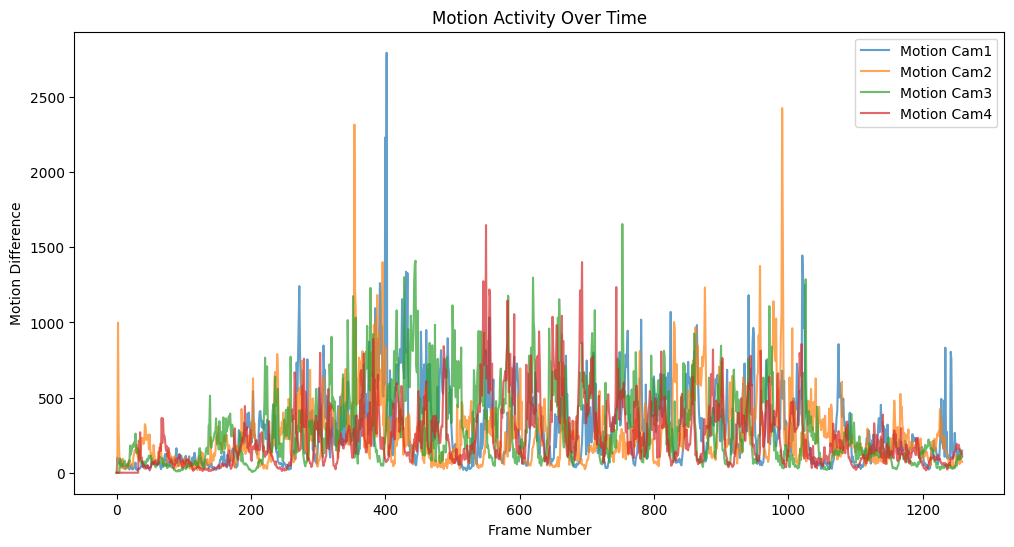

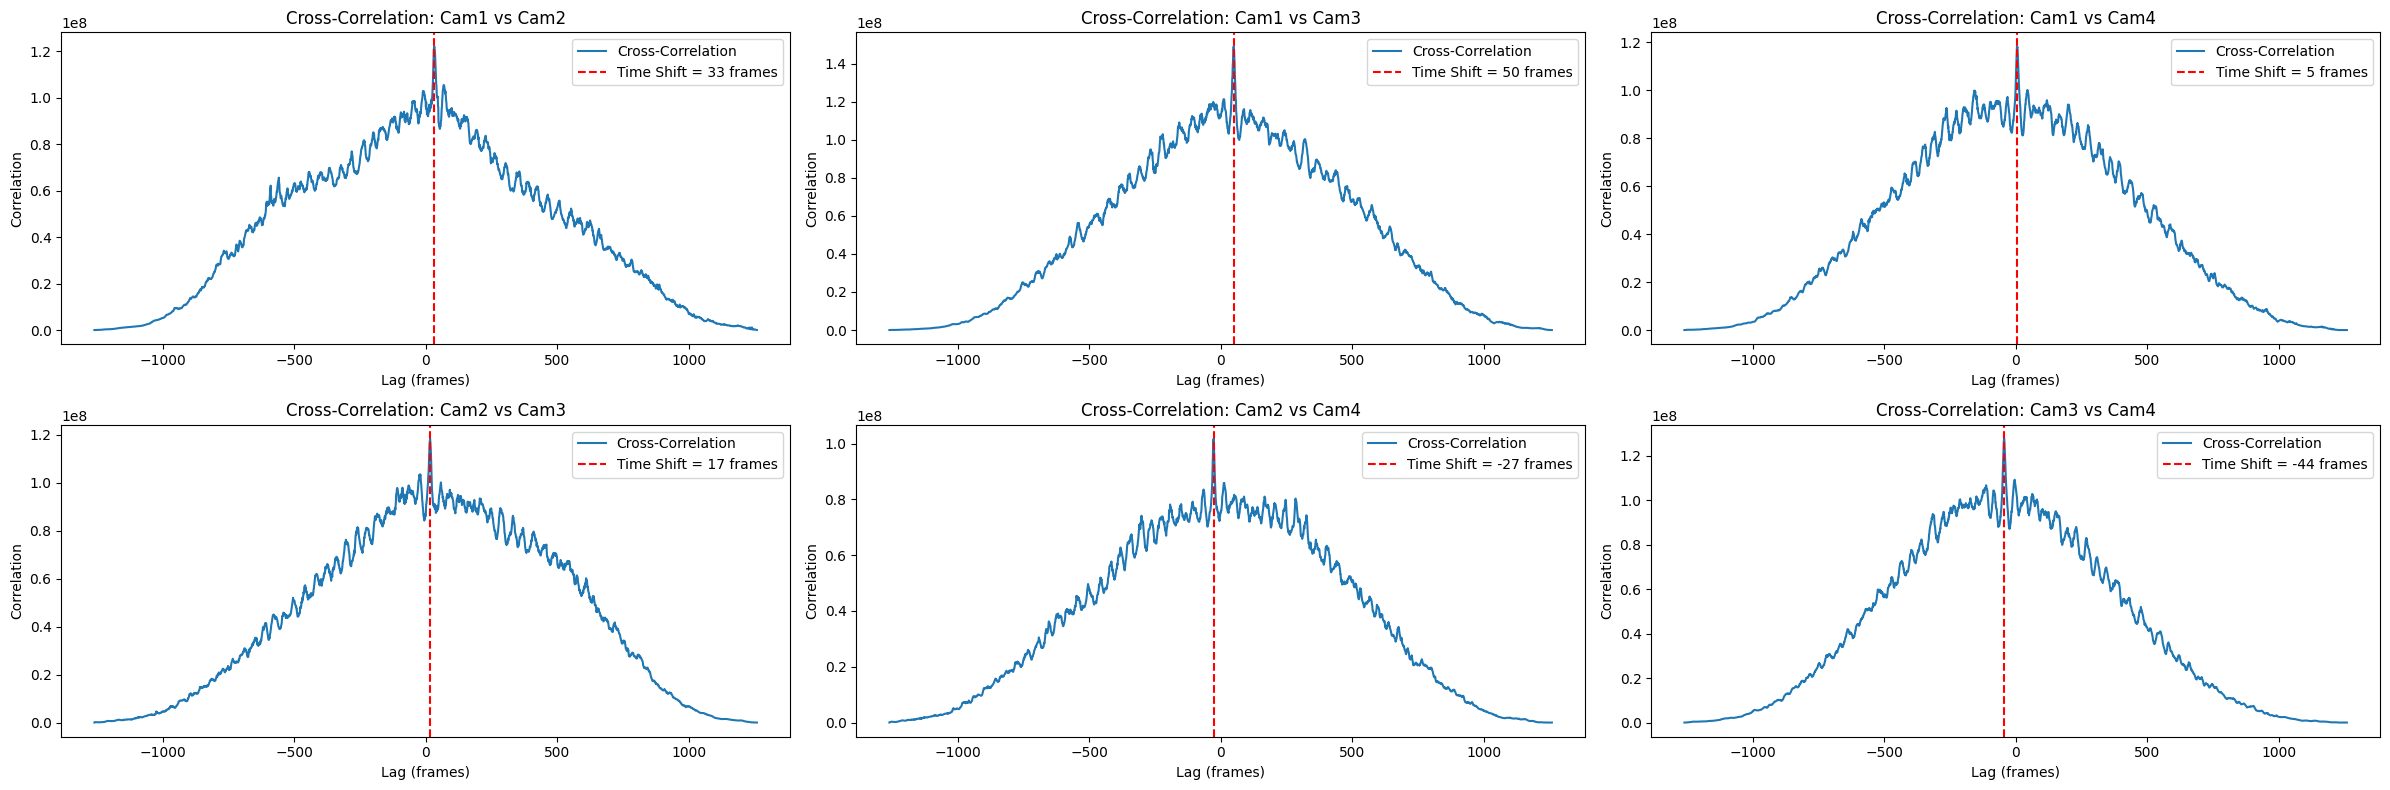

In [ ]:
#@title Анализ частоты движения и определения сдвига видео относительно друг друга !Если есть NAN заполнем псоледующими значениями
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Функция для вычисления изменений координат
def compute_motion_differences(df):
    motion_diffs = []
    for i in range(33):  # 33 ключевых точки Mediapipe Pose
        x_col = f'x_{i}'
        y_col = f'y_{i}'

        # Проверяем наличие столбцов и заполняем NaN значения
        if x_col not in df.columns:
            df[x_col] = 0  # Если столбец отсутствует, создаем его с нулями
        else:
            df[x_col] = df[x_col].bfill().fillna(0)

        if y_col not in df.columns:
            df[y_col] = 0
        else:
            df[y_col] = df[y_col].bfill().fillna(0)

        # Вычисляем разницу между последовательными кадрами
        dx = df[x_col].diff().fillna(0)
        dy = df[y_col].diff().fillna(0)

        # Суммарное изменение координат (без z)
        motion_diff = np.sqrt(dx**2 + dy**2)
        motion_diffs.append(motion_diff)

    # Общая активность движения как сумма по всем точкам
    total_motion = sum(motion_diffs)
    return total_motion

# Функция для нахождения временного сдвига
def find_time_shift(motion_1, motion_2):
    # Заполняем NaN значениями из следующего кадра
    motion_1 = motion_1.fillna(method='bfill').fillna(0)
    motion_2 = motion_2.fillna(method='bfill').fillna(0)

    # Обрезаем более длинный ряд до длины более короткого
    min_length = min(len(motion_1), len(motion_2))
    motion_1 = motion_1[:min_length]
    motion_2 = motion_2[:min_length]

    # Вычисляем перекрестную корреляцию
    correlation = correlate(motion_1, motion_2, mode='full')
    lags = np.arange(-len(motion_1) + 1, len(motion_1))

    # Находим лаг с максимальной корреляцией
    max_corr_index = np.argmax(correlation)
    time_shift = lags[max_corr_index]
    return time_shift, correlation, lags

# Вычисление изменений координат для всех четырех камер
motion_cam1 = compute_motion_differences(df1)
motion_cam2 = compute_motion_differences(df2)
motion_cam3 = compute_motion_differences(df3)  # Добавляем cam3
motion_cam4 = compute_motion_differences(df4)

# Нахождение временных сдвигов между парами камер
time_shift_1_2, correlation_1_2, lags_1_2 = find_time_shift(motion_cam1, motion_cam2)
time_shift_1_3, correlation_1_3, lags_1_3 = find_time_shift(motion_cam1, motion_cam3)  # Cam1 vs Cam3
time_shift_1_4, correlation_1_4, lags_1_4 = find_time_shift(motion_cam1, motion_cam4)
time_shift_2_3, correlation_2_3, lags_2_3 = find_time_shift(motion_cam2, motion_cam3)  # Cam2 vs Cam3
time_shift_2_4, correlation_2_4, lags_2_4 = find_time_shift(motion_cam2, motion_cam4)
time_shift_3_4, correlation_3_4, lags_3_4 = find_time_shift(motion_cam3, motion_cam4)  # Cam3 vs Cam4

# Интерпретация результатов
print("Сравнение cam1 и cam2:")
if time_shift_1_2 > 0:
    print(f"Видео cam2 опережает cam1 на {time_shift_1_2} кадров.")
elif time_shift_1_2 < 0:
    print(f"Видео cam1 опережает cam2 на {-time_shift_1_2} кадров.")
else:
    print("Видео cam1 и cam2 синхронизированы (временной сдвиг равен 0).")

print("\nСравнение cam1 и cam3:")
if time_shift_1_3 > 0:
    print(f"Видео cam3 опережает cam1 на {time_shift_1_3} кадров.")
elif time_shift_1_3 < 0:
    print(f"Видео cam1 опережает cam3 на {-time_shift_1_3} кадров.")
else:
    print("Видео cam1 и cam3 синхронизированы (временной сдвиг равен 0).")

print("\nСравнение cam1 и cam4:")
if time_shift_1_4 > 0:
    print(f"Видео cam4 опережает cam1 на {time_shift_1_4} кадров.")
elif time_shift_1_4 < 0:
    print(f"Видео cam1 опережает cam4 на {-time_shift_1_4} кадров.")
else:
    print("Видео cam1 и cam4 синхронизированы (временной сдвиг равен 0).")

print("\nСравнение cam2 и cam3:")
if time_shift_2_3 > 0:
    print(f"Видео cam3 опережает cam2 на {time_shift_2_3} кадров.")
elif time_shift_2_3 < 0:
    print(f"Видео cam2 опережает cam3 на {-time_shift_2_3} кадров.")
else:
    print("Видео cam2 и cam3 синхронизированы (временной сдвиг равен 0).")

print("\nСравнение cam2 и cam4:")
if time_shift_2_4 > 0:
    print(f"Видео cam4 опережает cam2 на {time_shift_2_4} кадров.")
elif time_shift_2_4 < 0:
    print(f"Видео cam2 опережает cam4 на {-time_shift_2_4} кадров.")
else:
    print("Видео cam2 и cam4 синхронизированы (временной сдвиг равен 0).")

print("\nСравнение cam3 и cam4:")
if time_shift_3_4 > 0:
    print(f"Видео cam4 опережает cam3 на {time_shift_3_4} кадров.")
elif time_shift_3_4 < 0:
    print(f"Видео cam3 опережает cam4 на {-time_shift_3_4} кадров.")
else:
    print("Видео cam3 и cam4 синхронизированы (временной сдвиг равен 0).")

# Визуализация частоты движения для всех четырех камер
plt.figure(figsize=(12, 6))
plt.plot(motion_cam1, label='Motion Cam1', alpha=0.7)
plt.plot(motion_cam2, label='Motion Cam2', alpha=0.7)
plt.plot(motion_cam3, label='Motion Cam3', alpha=0.7)  # Добавляем cam3
plt.plot(motion_cam4, label='Motion Cam4', alpha=0.7)
plt.title('Motion Activity Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Motion Difference')
plt.legend()
plt.show()

# Визуализация перекрестной корреляции для каждой пары камер
plt.figure(figsize=(24, 8))  # Увеличиваем размер для 6 графиков

# Cam1 vs Cam2
plt.subplot(2, 3, 1)
plt.plot(lags_1_2, correlation_1_2, label='Cross-Correlation')
plt.axvline(x=time_shift_1_2, color='red', linestyle='--', label=f'Time Shift = {time_shift_1_2} frames')
plt.title('Cross-Correlation: Cam1 vs Cam2')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

# Cam1 vs Cam3
plt.subplot(2, 3, 2)
plt.plot(lags_1_3, correlation_1_3, label='Cross-Correlation')
plt.axvline(x=time_shift_1_3, color='red', linestyle='--', label=f'Time Shift = {time_shift_1_3} frames')
plt.title('Cross-Correlation: Cam1 vs Cam3')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

# Cam1 vs Cam4
plt.subplot(2, 3, 3)
plt.plot(lags_1_4, correlation_1_4, label='Cross-Correlation')
plt.axvline(x=time_shift_1_4, color='red', linestyle='--', label=f'Time Shift = {time_shift_1_4} frames')
plt.title('Cross-Correlation: Cam1 vs Cam4')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

# Cam2 vs Cam3
plt.subplot(2, 3, 4)
plt.plot(lags_2_3, correlation_2_3, label='Cross-Correlation')
plt.axvline(x=time_shift_2_3, color='red', linestyle='--', label=f'Time Shift = {time_shift_2_3} frames')
plt.title('Cross-Correlation: Cam2 vs Cam3')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

# Cam2 vs Cam4
plt.subplot(2, 3, 5)
plt.plot(lags_2_4, correlation_2_4, label='Cross-Correlation')
plt.axvline(x=time_shift_2_4, color='red', linestyle='--', label=f'Time Shift = {time_shift_2_4} frames')
plt.title('Cross-Correlation: Cam2 vs Cam4')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

# Cam3 vs Cam4
plt.subplot(2, 3, 6)
plt.plot(lags_3_4, correlation_3_4, label='Cross-Correlation')
plt.axvline(x=time_shift_3_4, color='red', linestyle='--', label=f'Time Shift = {time_shift_3_4} frames')
plt.title('Cross-Correlation: Cam3 vs Cam4')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
  # Индекс кадра для cam1
print (time_shift_1_2, time_shift_1_3, time_shift_1_4)

33 50 5


33 50 5


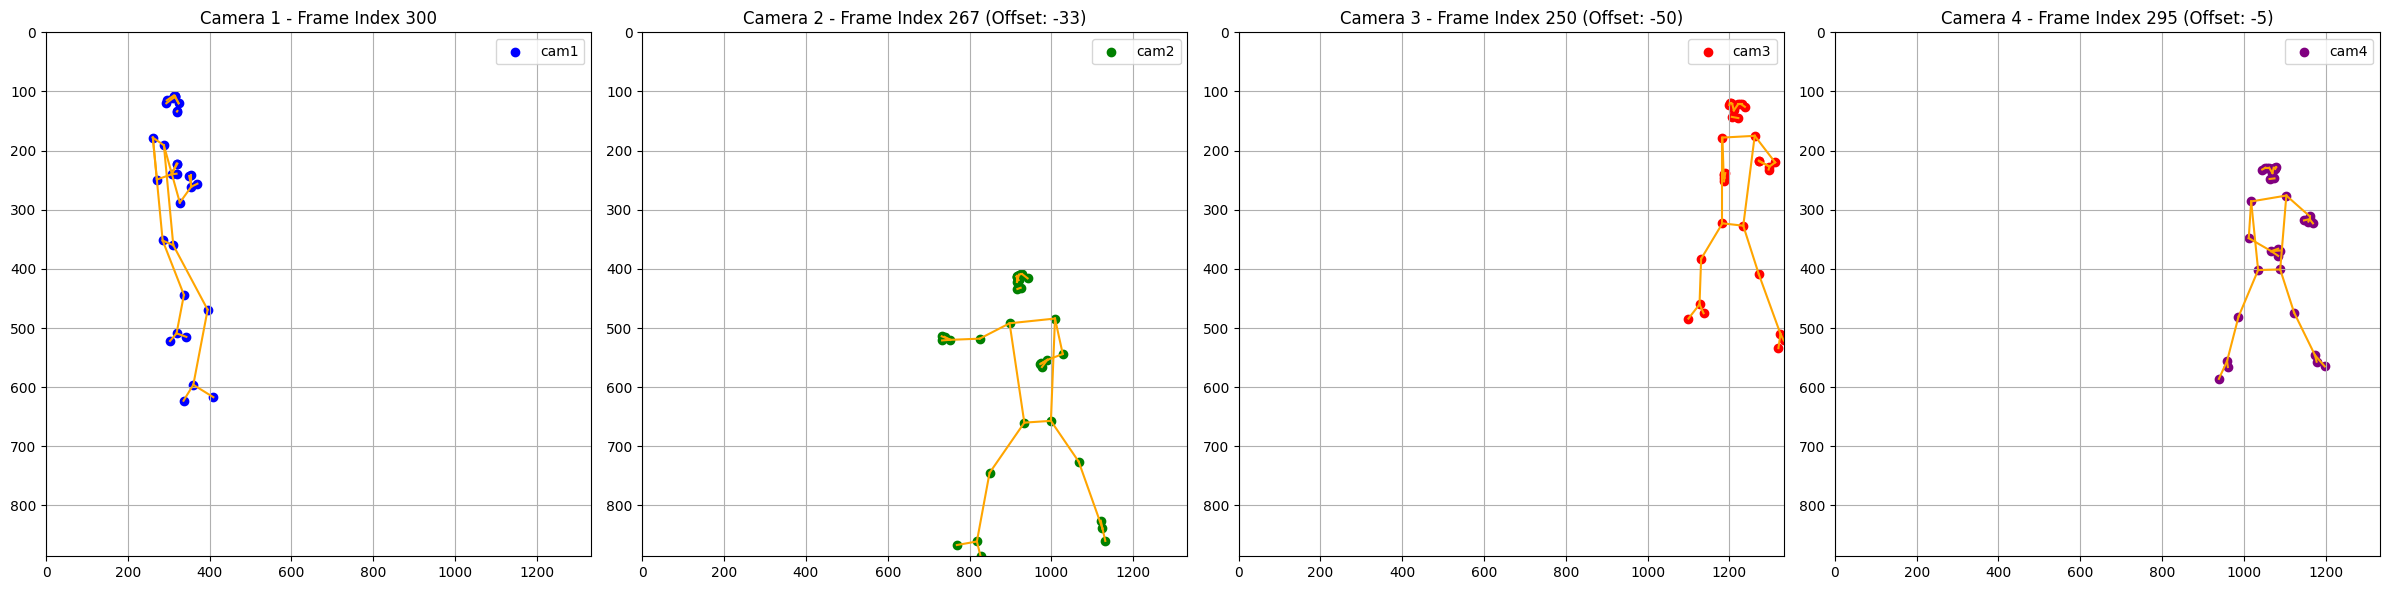

In [ ]:
#@title Отрисовываем скелет

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

def plot_frame(frame_index, offset_cam2, offset_cam3, offset_cam4):
    # Получаем данные для выбранного кадра по порядку
    frame_data1 = df1.iloc[frame_index]

    # Применяем сдвиги для второй, третьей и четвертой камер
    shifted_frame_index_cam2 = frame_index + offset_cam2
    shifted_frame_index_cam3 = frame_index + offset_cam3
    shifted_frame_index_cam4 = frame_index + offset_cam4

    # Проверка границ для cam2
    if shifted_frame_index_cam2 < 0 or shifted_frame_index_cam2 >= len(df2):
        print(f"Сдвинутый кадр {shifted_frame_index_cam2} выходит за пределы данных второй камеры.")
        return

    # Проверка границ для cam3
    if shifted_frame_index_cam3 < 0 or shifted_frame_index_cam3 >= len(df3):
        print(f"Сдвинутый кадр {shifted_frame_index_cam3} выходит за пределы данных третьей камеры.")
        return

    # Проверка границ для cam4
    if shifted_frame_index_cam4 < 0 or shifted_frame_index_cam4 >= len(df4):
        print(f"Сдвинутый кадр {shifted_frame_index_cam4} выходит за пределы данных четвертой камеры.")
        return

    frame_data2 = df2.iloc[shifted_frame_index_cam2]
    frame_data3 = df3.iloc[shifted_frame_index_cam3]
    frame_data4 = df4.iloc[shifted_frame_index_cam4]

    # Извлечение координат x и y для всех точек
    def extract_coordinates(frame_data):
        x_coords = []
        y_coords = []
        for col in frame_data.index:
            if col.startswith("x_"):
                x_coords.append(frame_data[col])
            elif col.startswith("y_"):
                y_coords.append(frame_data[col])
        return x_coords, y_coords

    x1, y1 = extract_coordinates(frame_data1)
    x2, y2 = extract_coordinates(frame_data2)
    x3, y3 = extract_coordinates(frame_data3)
    x4, y4 = extract_coordinates(frame_data4)

    # Определяем максимальные значения по осям X и Y
    max_x = max(max(x1), max(x2), max(x3), max(x4))
    max_y = max(max(y1), max(y2), max(y3), max(y4))

    # Создаем фигуру с четырьмя подграфиками
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # График для cam1
    axes[0].scatter(x1, y1, c='blue', label='cam1')
    axes[0].set_title(f"Camera 1 - Frame Index {frame_index}")
    axes[0].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[0].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[0].grid(True)  # Добавляем сетку
    axes[0].legend()

    # График для cam2
    axes[1].scatter(x2, y2, c='green', label='cam2')
    axes[1].set_title(f"Camera 2 - Frame Index {shifted_frame_index_cam2} (Offset: {offset_cam2})")
    axes[1].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[1].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[1].grid(True)  # Добавляем сетку
    axes[1].legend()

    # График для cam3
    axes[2].scatter(x3, y3, c='red', label='cam3')
    axes[2].set_title(f"Camera 3 - Frame Index {shifted_frame_index_cam3} (Offset: {offset_cam3})")
    axes[2].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[2].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[2].grid(True)  # Добавляем сетку
    axes[2].legend()

    # График для cam4
    axes[3].scatter(x4, y4, c='purple', label='cam4')
    axes[3].set_title(f"Camera 4 - Frame Index {shifted_frame_index_cam4} (Offset: {offset_cam4})")
    axes[3].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[3].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[3].grid(True)  # Добавляем сетку
    axes[3].legend()

    # Функция для рисования связей
    def draw_connections(ax, x_coords, y_coords, connections):
        for start, end in connections:
            if start < len(x_coords) and end < len(x_coords):  # Проверяем, что индексы существуют
                ax.plot([x_coords[start], x_coords[end]], [y_coords[start], y_coords[end]], c='orange')

    # Добавляем связи на графики
    draw_connections(axes[0], x1, y1, connections)
    draw_connections(axes[1], x2, y2, connections)
    draw_connections(axes[2], x3, y3, connections)
    draw_connections(axes[3], x4, y4, connections)

    # Отображение графиков
    plt.tight_layout()
    plt.show()

# Выбираем кадр и сдвиги
frame_index = 300
  # Индекс кадра для cam1
print (time_shift_1_2, time_shift_1_3, time_shift_1_4)

# Отрисовываем скелеты
plot_frame(frame_index, -time_shift_1_2, -time_shift_1_3, -time_shift_1_4)

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

def plot_frame(frame_index, offset_cam2, offset_cam3, offset_cam4):
    # Получаем данные для выбранного кадра по порядку
    frame_data1 = df1.iloc[frame_index]

    # Применяем сдвиги для второй, третьей и четвертой камер
    shifted_frame_index_cam2 = frame_index + offset_cam2
    shifted_frame_index_cam3 = frame_index + offset_cam3
    shifted_frame_index_cam4 = frame_index + offset_cam4

    # Проверка границ для cam2
    if shifted_frame_index_cam2 < 0 or shifted_frame_index_cam2 >= len(df2):
        print(f"Сдвинутый кадр {shifted_frame_index_cam2} выходит за пределы данных второй камеры.")
        return

    # Проверка границ для cam3
    if shifted_frame_index_cam3 < 0 or shifted_frame_index_cam3 >= len(df3):
        print(f"Сдвинутый кадр {shifted_frame_index_cam3} выходит за пределы данных третьей камеры.")
        return

    # Проверка границ для cam4
    if shifted_frame_index_cam4 < 0 or shifted_frame_index_cam4 >= len(df4):
        print(f"Сдвинутый кадр {shifted_frame_index_cam4} выходит за пределы данных четвертой камеры.")
        return

    frame_data2 = df2.iloc[shifted_frame_index_cam2]
    frame_data3 = df3.iloc[shifted_frame_index_cam3]
    frame_data4 = df4.iloc[shifted_frame_index_cam4]

    # Извлечение координат x и y для всех точек
    def extract_coordinates(frame_data):
        x_coords = []
        y_coords = []
        for col in frame_data.index:
            if col.startswith("x_"):
                x_coords.append(frame_data[col])
            elif col.startswith("y_"):
                y_coords.append(frame_data[col])
        return x_coords, y_coords

    x1, y1 = extract_coordinates(frame_data1)
    x2, y2 = extract_coordinates(frame_data2)
    x3, y3 = extract_coordinates(frame_data3)
    x4, y4 = extract_coordinates(frame_data4)

    # Определяем максимальные значения по осям X и Y
    max_x = max(max(x1), max(x2), max(x3), max(x4))
    max_y = max(max(y1), max(y2), max(y3), max(y4))

    # Создаем фигуру с четырьмя подграфиками
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # График для cam1
    axes[0].scatter(x1, y1, c='blue', label='cam1')
    axes[0].set_title(f"Camera 1 - Frame Index {frame_index}")
    axes[0].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[0].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[0].grid(True)  # Добавляем сетку
    axes[0].legend()

    # График для cam2
    axes[1].scatter(x2, y2, c='green', label='cam2')
    axes[1].set_title(f"Camera 2 - Frame Index {shifted_frame_index_cam2} (Offset: {offset_cam2})")
    axes[1].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[1].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[1].grid(True)  # Добавляем сетку
    axes[1].legend()

    # График для cam3
    axes[2].scatter(x3, y3, c='red', label='cam3')
    axes[2].set_title(f"Camera 3 - Frame Index {shifted_frame_index_cam3} (Offset: {offset_cam3})")
    axes[2].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[2].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[2].grid(True)  # Добавляем сетку
    axes[2].legend()

    # График для cam4
    axes[3].scatter(x4, y4, c='purple', label='cam4')
    axes[3].set_title(f"Camera 4 - Frame Index {shifted_frame_index_cam4} (Offset: {offset_cam4})")
    axes[3].set_xlim(0, max_x)  # Устанавливаем пределы оси X
    axes[3].set_ylim(max_y, 0)  # Меняем направление оси Y: от max_y до 0
    axes[3].grid(True)  # Добавляем сетку
    axes[3].legend()

    # Функция для рисования связей
    def draw_connections(ax, x_coords, y_coords, connections):
        for start, end in connections:
            if start < len(x_coords) and end < len(x_coords):  # Проверяем, что индексы существуют
                ax.plot([x_coords[start], x_coords[end]], [y_coords[start], y_coords[end]], c='orange')

    # Добавляем связи на графики
    draw_connections(axes[0], x1, y1, connections)
    draw_connections(axes[1], x2, y2, connections)
    draw_connections(axes[2], x3, y3, connections)
    draw_connections(axes[3], x4, y4, connections)

    # Отображение графиков
    plt.tight_layout()
    plt.show()

# Создание слайдеров для выбора кадра и временных сдвигов
frame_slider = IntSlider(min=0, max=min(len(df1), len(df2), len(df3), len(df4)) - 1, step=1, value=300, description="Frame Index")
offset_cam2_slider = IntSlider(min=-100, max=100, step=1, value=-time_shift_1_2, description="Offset Cam2")
offset_cam3_slider = IntSlider(min=-100, max=100, step=1, value=-time_shift_1_3, description="Offset Cam3")
offset_cam4_slider = IntSlider(min=-100, max=100, step=1, value=-time_shift_1_4, description="Offset Cam4")

# Привязка функции plot_frame к слайдерам
interact(plot_frame, frame_index=frame_slider, offset_cam2=offset_cam2_slider, offset_cam3=offset_cam3_slider, offset_cam4=offset_cam4_slider)

interactive(children=(IntSlider(value=300, description='Frame Index', max=1259), IntSlider(value=-33, descript…

<function __main__.plot_frame(frame_index, offset_cam2, offset_cam3, offset_cam4)>

In [ ]:
#@title Триангуляция
# Функция для создания проекционной матрицы
def create_projection_matrix(camera_matrix, rotation_matrix, translation_vector):
    """
    Создает проекционную матрицу P = K[R|t].
    """
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    projection_matrix = camera_matrix @ extrinsic_matrix
    return projection_matrix

# Обновленная функция для синхронизации данных
def synchronize_data(df1, df2, df3, df4, offset_cam2=0, offset_cam3=0, offset_cam4=0):
    """
    Синхронизирует данные четырех камер на основе временных сдвигов.
    """
    max_length = min(
        len(df1),
        len(df2) + abs(offset_cam2),
        len(df3) + abs(offset_cam3),
        len(df4) + abs(offset_cam4)
    )

    synchronized_data = {
        'cam1': df1.iloc[:max_length],
        'cam2': df2.iloc[offset_cam2:offset_cam2 + max_length] if offset_cam2 >= 0 else df2.iloc[:len(df2) + offset_cam2],
        'cam3': df3.iloc[offset_cam3:offset_cam3 + max_length] if offset_cam3 >= 0 else df3.iloc[:len(df3) + offset_cam3],
        'cam4': df4.iloc[offset_cam4:offset_cam4 + max_length] if offset_cam4 >= 0 else df4.iloc[:len(df4) + offset_cam4],
    }
    return synchronized_data

# Взвешенная триангуляция (из triangulation.txt)
def weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files):
    """
    Выполняет взвешенную триангуляцию для получения начальных 3D-координат.
    """
    A = []
    for i in range(len(projection_matrices)):
        P = projection_matrices[i]
        x, y = x_files[i], y_files[i]
        w = likelihood_files[i]  # Вес (достоверность)

        if np.isnan(x) or np.isnan(y) or np.isnan(w) or w == 0:
            continue  # Пропускаем камеры с недоступными данными

        # Уравнения для триангуляции
        A.append(w * (x * P[2] - P[0]))
        A.append(w * (y * P[2] - P[1]))

    if len(A) < 4:
        return np.array([np.nan, np.nan, np.nan, np.nan])  # Недостаточно данных для триангуляции

    A = np.array(A)

    # Решение системы уравнений методом SVD
    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]  # Последняя строка Vt содержит решение

    # Нормализация однородных координат
    X = X / X[3]

    return X

# Триангуляция для каждой ключевой точки
num_keypoints = 33  # Количество ключевых точек Mediapipe Pose
frames_3d = []

# Синхронизация данных
synchronized_data = synchronize_data(df1, df2, df3, df4, -time_shift_1_3, -time_shift_1_3, -time_shift_1_4)

# Проекционные матрицы
proj_mat1 = create_projection_matrix(intrinsics['cam1']['camera_matrix'], extrinsics['cam1']['rotation_matrix'], extrinsics['cam1']['translation_vector'])
# Добавление проекционной матрицы для второй камеры
proj_mat2 = create_projection_matrix(
    intrinsics['cam2']['camera_matrix'],
    extrinsics['cam2']['rotation_matrix'],
    extrinsics['cam2']['translation_vector']
)
proj_mat3 = create_projection_matrix(intrinsics['cam3']['camera_matrix'], extrinsics['cam3']['rotation_matrix'], extrinsics['cam3']['translation_vector'])
proj_mat4 = create_projection_matrix(intrinsics['cam4']['camera_matrix'], extrinsics['cam4']['rotation_matrix'], extrinsics['cam4']['translation_vector'])


# Обновление списка проекционных матриц
projection_matrices = [proj_mat1, proj_mat2, proj_mat3, proj_mat4]

print("Проекционые матрицы:")
print(projection_matrices)


# Определение минимальной длины данных

min_length = min(
    len(synchronized_data['cam1']),
    len(synchronized_data['cam2']),
    len(synchronized_data['cam3']),
    len(synchronized_data['cam4'])
)

# Обработка только тех кадров, которые доступны для всех камер
frames_3d = []
for frame_index in range(min_length):
    frame_3d = []
    for keypoint_index in range(num_keypoints):
        # Извлечение координат точки для всех камер
        try:
            x1 = synchronized_data['cam1'].iloc[frame_index][f'x_{keypoint_index}']
            y1 = synchronized_data['cam1'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood1 = synchronized_data['cam1'].iloc[frame_index][f'visibility_{keypoint_index}']

            x2 = synchronized_data['cam2'].iloc[frame_index][f'x_{keypoint_index}']
            y2 = synchronized_data['cam2'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood2 = synchronized_data['cam2'].iloc[frame_index][f'visibility_{keypoint_index}']

            x3 = synchronized_data['cam3'].iloc[frame_index][f'x_{keypoint_index}']
            y3 = synchronized_data['cam3'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood3 = synchronized_data['cam3'].iloc[frame_index][f'visibility_{keypoint_index}']

            x4 = synchronized_data['cam4'].iloc[frame_index][f'x_{keypoint_index}']
            y4 = synchronized_data['cam4'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood4 = synchronized_data['cam4'].iloc[frame_index][f'visibility_{keypoint_index}']
        except IndexError:
            print(f"Frame index {frame_index} is out of bounds for one of the cameras.")
            continue  # Пропустить текущий кадр

        # Координаты и достоверности
        x_files = [x1, x2, x3, x4]
        y_files = [y1, y2, y3, y4]
        likelihood_files = [likelihood1, likelihood2, likelihood3, likelihood4]

        # Взвешенная триангуляция
        point_3d = weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files)
        frame_3d.append(point_3d[:3])  # Берем только первые три координаты (X, Y, Z)

    frames_3d.append(frame_3d)
# Результат: список 3D-координат для каждого кадра
frames_3d = np.array(frames_3d)

Проекционые матрицы:
[array([[    -654.06,     -1598.3,     -333.89,      2793.9],
       [     30.257,      54.208,     -1499.4,        1586],
       [    0.53085,    -0.80177,    -0.27454,      3.1016]]), array([[    -1290.2,     -219.68,     -219.49,      2943.2],
       [     5.9042,     -345.64,     -1093.6,      2101.8],
       [   -0.50284,     -0.8622,   -0.061294,      3.0874]]), array([[     1787.5,        1662,     -563.17,      3233.7],
       [     18.992,     -290.32,     -2275.4,      2601.7],
       [    -0.3189,     0.83344,     -0.4513,      4.3449]]), array([[     2611.8,     -629.88,     -365.11,      4687.6],
       [    -131.27,     -17.917,     -2530.6,      3297.4],
       [    0.57843,     0.77767,    -0.24625,      4.4938]])]


In [ ]:
frames_3d

array([[[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[    0.56957,     0.82608,     0.99947],
        [    0.58811,     0.82604,      1.0182],
        [    0.59966,     0.82245,      1.0199],
        ...,
        [    0.63945,     0.92898,     0.18122],
        [    0.64246,     0.77725,     0.14504],
        [    0.56999,     0.84462,     0.14933]],

       [[    0.56581,     0.83033,     0.99872],
        [    0.58149,     0.83008,      1.0179],
        [    0.59472,     0.82565,      1.0186],
        ...,
        [    0.65183,     0.93944,    0.097683],
        [    0.71748,     0.72995,    0.066898],
        [    0.55111,      0.8816,    0.081508]],

       ...,

       [[    0.86399,     0.96159,     0.88365],
        [  

In [ ]:
np.save('/content/drive/MyDrive/Karate_2/5_blue_belt/frames_3d_5_blue_belt.npy', frames_3d)

In [ ]:
import numpy as np
frames_3d = np.load('/content/drive/MyDrive/Karate_2/5_blue_belt/frames_3d_5_blue_belt.npy')

In [ ]:
#@title Отрисовываем 3D скелет с масштабом
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, FloatSlider

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]


# Функция для отображения 3D-скелета с масштабированием
def plot_skeleton(frame_index, azimuth, elevation, scale):
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отфильтровываем точки с NaN или Inf
    valid_keypoints = keypoints[~np.isnan(keypoints).any(axis=1) & ~np.isinf(keypoints).any(axis=1)]

    if len(valid_keypoints) == 0:
        print(f"No valid keypoints found for frame {frame_index}. Skipping...")
        return

    # Отображение точек
    x, y, z = valid_keypoints[:, 0], valid_keypoints[:, 1], valid_keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=10)

    # Отображение связей между точками
    for start, end in connections:
        if (start < len(keypoints) and end < len(keypoints) and
                not np.any(np.isnan(keypoints[start])) and not np.any(np.isnan(keypoints[end]))):
            xs = [keypoints[start][0], keypoints[end][0]]
            ys = [keypoints[start][1], keypoints[end][1]]
            zs = [keypoints[start][2], keypoints[end][2]]
            ax.plot(xs, ys, zs, c='blue')

    # Настройка осей на основе данных
    all_x = frames_3d[:, :, 0].flatten()
    all_y = frames_3d[:, :, 1].flatten()
    all_z = frames_3d[:, :, 2].flatten()

    # Исключаем NaN и Inf при расчете пределов осей
    valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
    valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
    valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

    if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
        # Базовые пределы осей
        x_min, x_max = valid_x.min(), valid_x.max()
        y_min, y_max = valid_y.min(), valid_y.max()
        z_min, z_max = valid_z.min(), valid_z.max()

        # Применяем масштабирование
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        z_center = (z_min + z_max) / 2

        x_range = (x_max - x_min) * scale
        y_range = (y_max - y_min) * scale
        z_range = (z_max - z_min) * scale

        ax.set_xlim(x_center - x_range / 2, x_center + x_range / 2)
        ax.set_ylim(y_center - y_range / 2, y_center + y_range / 2)
        ax.set_zlim(z_center - z_range / 2, z_center + z_range / 2)
    else:
        print("No valid data to set axis limits. Skipping...")
        return

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    # Установка углов обзора
    ax.view_init(elev=elevation, azim=azimuth)

    plt.show()

# Создание слайдеров для выбора кадра, углов обзора и масштабирования
num_frames = frames_3d.shape[0]  # Общее количество кадров
frame_slider = IntSlider(min=0, max=num_frames - 1, step=1, value=0, description="Frame Index")
azimuth_slider = FloatSlider(min=0, max=360, step=1, value=30, description="Azimuth")
elevation_slider = FloatSlider(min=-180, max=180, step=1, value=30, description="Elevation")
scale_slider = FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description="Scale")

# Привязка функции plot_skeleton к слайдерам
interact(
    plot_skeleton,
    frame_index=frame_slider,
    azimuth=azimuth_slider,
    elevation=elevation_slider,
    scale=scale_slider
)

interactive(children=(IntSlider(value=0, description='Frame Index', max=1209), FloatSlider(value=30.0, descrip…

<function __main__.plot_skeleton(frame_index, azimuth, elevation, scale)>

In [ ]:
#@title Создание видео движения скелета
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import gc  # Импортируем сборщик мусора

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для сохранения кадра
def save_frame(frame_index, frames_3d, output_dir):
    fig = plt.figure(figsize=(18, 9))  # Уменьшаем размер графика
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отображение точек
    x, y, z = keypoints[:, 0], keypoints[:, 1], keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=10)

    # Отображение связей между точками
    for start, end in connections:
        xs = [keypoints[start][0], keypoints[end][0]]
        ys = [keypoints[start][1], keypoints[end][1]]
        zs = [keypoints[start][2], keypoints[end][2]]
        ax.plot(xs, ys, zs, c='blue')

    # Настройка осей, исключая NaN значения
    valid_x = frames_3d[:, :, 0].flatten()[~np.isnan(frames_3d[:, :, 0].flatten())]
    valid_y = frames_3d[:, :, 1].flatten()[~np.isnan(frames_3d[:, :, 1].flatten())]
    valid_z = frames_3d[:, :, 2].flatten()[~np.isnan(frames_3d[:, :, 2].flatten())]

    if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
        ax.set_xlim(np.min(valid_x), np.max(valid_x))
        ax.set_ylim(np.min(valid_y), np.max(valid_y))
        ax.set_zlim(np.min(valid_z), np.max(valid_z))
    else:
        raise ValueError("Все координаты содержат NaN. Невозможно построить график.")

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    # Сохранение кадра
    frame_path = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
    plt.savefig(frame_path, format='jpg', dpi=75)  # Уменьшаем разрешение
    plt.close(fig)

    # Очистка памяти
    del fig, ax, keypoints, x, y, z
    gc.collect()

# Генерация кадров
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

num_frames = frames_3d.shape[0]  # Общее количество кадров
batch_size = 100  # Размер пакета для обработки

for batch_start in range(0, num_frames, batch_size):
    batch_end = min(batch_start + batch_size, num_frames)
    for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
        save_frame(frame_index, frames_3d, output_dir)
    gc.collect()  # Освобождаем память после обработки пакета

# Создание видео с помощью FFmpeg
subprocess.run([
    "ffmpeg",
    "-framerate", "30",
    "-i", f"{output_dir}/frame_%04d.jpg",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "output.mp4"
])

print("Видео успешно создано: output.mp4")

Генерация кадров: 100%|██████████| 10/10 [00:38<00:00,  3.87s/frame]


Видео успешно создано: output.mp4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, FloatSlider
import os
import gc
import subprocess
from tqdm import tqdm

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для отображения 3D-скелета с масштабированием
def plot_skeleton(frame_index, azimuth, elevation, scale):
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отфильтровываем точки с NaN или Inf
    valid_keypoints = keypoints[~np.isnan(keypoints).any(axis=1) & ~np.isinf(keypoints).any(axis=1)]

    if len(valid_keypoints) == 0:
        print(f"No valid keypoints found for frame {frame_index}. Skipping...")
        return fig, ax  # Возвращаем пустой график

    # Отображение точек
    x, y, z = valid_keypoints[:, 0], valid_keypoints[:, 1], valid_keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=10)

    # Отображение связей между точками
    for start, end in connections:
        if (start < len(keypoints) and end < len(keypoints) and
                not np.any(np.isnan(keypoints[start])) and not np.any(np.isnan(keypoints[end]))):
            xs = [keypoints[start][0], keypoints[end][0]]
            ys = [keypoints[start][1], keypoints[end][1]]
            zs = [keypoints[start][2], keypoints[end][2]]
            ax.plot(xs, ys, zs, c='blue')

    # Настройка осей на основе данных
    all_x = frames_3d[:, :, 0].flatten()
    all_y = frames_3d[:, :, 1].flatten()
    all_z = frames_3d[:, :, 2].flatten()

    # Исключаем NaN и Inf при расчете пределов осей
    valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
    valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
    valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

    if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
        # Базовые пределы осей
        x_min, x_max = valid_x.min(), valid_x.max()
        y_min, y_max = valid_y.min(), valid_y.max()
        z_min, z_max = valid_z.min(), valid_z.max()

        # Применяем масштабирование
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        z_center = (z_min + z_max) / 2

        x_range = (x_max - x_min) * scale
        y_range = (y_max - y_min) * scale
        z_range = (z_max - z_min) * scale

        ax.set_xlim(x_center - x_range / 2, x_center + x_range / 2)
        ax.set_ylim(y_center - y_range / 2, y_center + y_range / 2)
        ax.set_zlim(z_center - z_range / 2, z_center + z_range / 2)
    else:
        print("No valid data to set axis limits. Skipping...")
        return fig, ax  # Возвращаем пустой график

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    # Установка углов обзора
    ax.view_init(elev=elevation, azim=azimuth)

    return fig, ax

# Функция для сохранения кадра
def save_frame(frame_index, frames_3d, output_dir):
    fig, ax = plot_skeleton(frame_index, azimuth=30, elevation=30, scale=1.0)
    plt.savefig(f"{output_dir}/frame_{frame_index:04d}.jpg", bbox_inches='tight')
    plt.close(fig)

# Создание слайдеров для выбора кадра, углов обзора и масштабирования
num_frames = frames_3d.shape[0]  # Общее количество кадров
frame_slider = IntSlider(min=0, max=num_frames - 1, step=1, value=0, description="Frame Index")
azimuth_slider = FloatSlider(min=0, max=360, step=1, value=30, description="Azimuth")
elevation_slider = FloatSlider(min=-180, max=180, step=1, value=30, description="Elevation")
scale_slider = FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description="Scale")

# Привязка функции plot_skeleton к слайдерам
interact(
    plot_skeleton,
    frame_index=frame_slider,
    azimuth=azimuth_slider,
    elevation=elevation_slider,
    scale=scale_slider
)

# Генерация кадров
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

num_frames = frames_3d.shape[0]  # Общее количество кадров
batch_size = 100  # Размер пакета для обработки

for batch_start in range(0, num_frames, batch_size):
    batch_end = min(batch_start + batch_size, num_frames)
    for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
        save_frame(frame_index, frames_3d, output_dir)
    gc.collect()  # Освобождаем память после обработки пакета

# Создание видео с помощью FFmpeg
subprocess.run([
    "ffmpeg",
    "-framerate", "30",
    "-i", f"{output_dir}/frame_%04d.jpg",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "output.mp4"
])

print("Видео успешно создано: output.mp4")

interactive(children=(IntSlider(value=0, description='Frame Index', max=1209), FloatSlider(value=30.0, descrip…

Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

No valid keypoints found for frame 0. Skipping...


Генерация кадров: 100%|██████████| 10/10 [00:02<00:00,  3.68frame/s]


Видео успешно создано: output.mp4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import gc
import subprocess
from tqdm import tqdm

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для отображения 3D-скелета с масштабированием
def plot_skeleton(frame_index, azimuth, elevation, scale):
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отфильтровываем точки с NaN или Inf
    valid_keypoints = keypoints[~np.isnan(keypoints).any(axis=1) & ~np.isinf(keypoints).any(axis=1)]

    if len(valid_keypoints) == 0:
        print(f"No valid keypoints found for frame {frame_index}. Skipping...")
        return fig, ax  # Возвращаем пустой график

    # Отображение точек
    x, y, z = valid_keypoints[:, 0], valid_keypoints[:, 1], valid_keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=10)
    # Отображение связей между точками
    for start, end in connections:
        if (start < len(keypoints) and end < len(keypoints) and
                not np.any(np.isnan(keypoints[start])) and not np.any(np.isnan(keypoints[end]))):
            xs = [keypoints[start][0], keypoints[end][0]]
            ys = [keypoints[start][1], keypoints[end][1]]
            zs = [keypoints[start][2], keypoints[end][2]]
            ax.plot(xs, ys, zs, c='green', linewidth=1)
    # Настройка осей на основе данных
    all_x = frames_3d[:, :, 0].flatten()
    all_y = frames_3d[:, :, 1].flatten()
    all_z = frames_3d[:, :, 2].flatten()

    # Исключаем NaN и Inf при расчете пределов осей
    valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
    valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
    valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

    if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
        # Базовые пределы осей
        x_min, x_max = valid_x.min(), valid_x.max()
        y_min, y_max = valid_y.min(), valid_y.max()
        z_min, z_max = valid_z.min(), valid_z.max()

        # Применяем масштабирование
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        z_center = (z_min + z_max) / 2

        x_range = (x_max - x_min) * scale
        y_range = (y_max - y_min) * scale
        z_range = (z_max - z_min) * scale

        ax.set_xlim(x_center - x_range / 2, x_center + x_range / 2)
        ax.set_ylim(y_center - y_range / 2, y_center + y_range / 2)
        ax.set_zlim(z_center - z_range / 2, z_center + z_range / 2)
    else:
        print("No valid data to set axis limits. Skipping...")
        return fig, ax  # Возвращаем пустой график

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    # Установка углов обзора
    ax.view_init(elev=elevation, azim=azimuth)

    return fig, ax

# Функция для сохранения кадра
def save_frame(frame_index, frames_3d, output_dir):
    print(f"Saving frame {frame_index}")
    fig, ax = plot_skeleton(frame_index, azimuth=30, elevation=30, scale=5.0)
    plt.savefig(f"{output_dir}/frame_{frame_index:04d}.jpg", bbox_inches='tight')
    plt.close(fig)

# Генерация кадров
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

num_frames = frames_3d.shape[0]  # Общее количество кадров
batch_size = 100  # Размер пакета для обработки

for batch_start in range(0, num_frames, batch_size):
    batch_end = min(batch_start + batch_size, num_frames)
    for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
        save_frame(frame_index, frames_3d, output_dir)
    gc.collect()  # Освобождаем память после обработки пакета

# Создание видео с помощью FFmpeg
subprocess.run([
    "ffmpeg",
    "-framerate", "30",
    "-i", f"{output_dir}/frame_%04d.jpg",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "output.mp4"
], check=True)

print("Видео успешно создано: output.mp4")

Saving frame 1116


Генерация кадров:  17%|█▋        | 17/100 [00:04<00:21,  3.79frame/s]

Saving frame 1117


Генерация кадров:  18%|█▊        | 18/100 [00:04<00:21,  3.83frame/s]

Saving frame 1118


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:20,  3.86frame/s]

Saving frame 1119


Генерация кадров:  20%|██        | 20/100 [00:05<00:20,  3.82frame/s]

Saving frame 1120


Генерация кадров:  21%|██        | 21/100 [00:05<00:20,  3.83frame/s]

Saving frame 1121


Генерация кадров:  22%|██▏       | 22/100 [00:05<00:20,  3.83frame/s]

Saving frame 1122


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:20,  3.83frame/s]

Saving frame 1123


Генерация кадров:  24%|██▍       | 24/100 [00:06<00:20,  3.76frame/s]

Saving frame 1124


Генерация кадров:  25%|██▌       | 25/100 [00:06<00:19,  3.78frame/s]

Saving frame 1125


Генерация кадров:  26%|██▌       | 26/100 [00:06<00:19,  3.79frame/s]

Saving frame 1126


Генерация кадров:  27%|██▋       | 27/100 [00:07<00:19,  3.81frame/s]

Saving frame 1127


Генерация кадров:  28%|██▊       | 28/100 [00:07<00:19,  3.76frame/s]

Saving frame 1128


Генерация кадров:  29%|██▉       | 29/100 [00:07<00:19,  3.73frame/s]

Saving frame 1129


Генерация кадров:  30%|███       | 30/100 [00:08<00:21,  3.32frame/s]

Saving frame 1130


Генерация кадров:  31%|███       | 31/100 [00:08<00:22,  3.10frame/s]

Saving frame 1131


Генерация кадров:  32%|███▏      | 32/100 [00:08<00:22,  3.00frame/s]

Saving frame 1132


Генерация кадров:  33%|███▎      | 33/100 [00:09<00:23,  2.91frame/s]

Saving frame 1133


Генерация кадров:  34%|███▍      | 34/100 [00:09<00:23,  2.82frame/s]

Saving frame 1134


Генерация кадров:  35%|███▌      | 35/100 [00:09<00:23,  2.80frame/s]

Saving frame 1135


Генерация кадров:  36%|███▌      | 36/100 [00:10<00:23,  2.77frame/s]

Saving frame 1136


Генерация кадров:  37%|███▋      | 37/100 [00:10<00:23,  2.68frame/s]

Saving frame 1137


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:23,  2.65frame/s]

Saving frame 1138


Генерация кадров:  39%|███▉      | 39/100 [00:11<00:22,  2.66frame/s]

Saving frame 1139


Генерация кадров:  40%|████      | 40/100 [00:11<00:22,  2.62frame/s]

Saving frame 1140


Генерация кадров:  41%|████      | 41/100 [00:12<00:20,  2.88frame/s]

Saving frame 1141


Генерация кадров:  42%|████▏     | 42/100 [00:12<00:18,  3.11frame/s]

Saving frame 1142


Генерация кадров:  43%|████▎     | 43/100 [00:12<00:17,  3.23frame/s]

Saving frame 1143


Генерация кадров:  44%|████▍     | 44/100 [00:12<00:16,  3.38frame/s]

Saving frame 1144


Генерация кадров:  45%|████▌     | 45/100 [00:13<00:15,  3.51frame/s]

Saving frame 1145


Генерация кадров:  46%|████▌     | 46/100 [00:13<00:14,  3.62frame/s]

Saving frame 1146


Генерация кадров:  47%|████▋     | 47/100 [00:13<00:14,  3.65frame/s]

Saving frame 1147


Генерация кадров:  48%|████▊     | 48/100 [00:13<00:13,  3.73frame/s]

Saving frame 1148


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:13,  3.78frame/s]

Saving frame 1149


Генерация кадров:  50%|█████     | 50/100 [00:14<00:13,  3.80frame/s]

Saving frame 1150


Генерация кадров:  51%|█████     | 51/100 [00:14<00:12,  3.79frame/s]

Saving frame 1151


Генерация кадров:  52%|█████▏    | 52/100 [00:15<00:12,  3.79frame/s]

Saving frame 1152


Генерация кадров:  53%|█████▎    | 53/100 [00:15<00:12,  3.80frame/s]

Saving frame 1153


Генерация кадров:  54%|█████▍    | 54/100 [00:15<00:12,  3.82frame/s]

Saving frame 1154


Генерация кадров:  55%|█████▌    | 55/100 [00:15<00:11,  3.76frame/s]

Saving frame 1155


Генерация кадров:  56%|█████▌    | 56/100 [00:16<00:11,  3.78frame/s]

Saving frame 1156


Генерация кадров:  57%|█████▋    | 57/100 [00:16<00:11,  3.78frame/s]

Saving frame 1157


Генерация кадров:  58%|█████▊    | 58/100 [00:16<00:11,  3.78frame/s]

Saving frame 1158


Генерация кадров:  59%|█████▉    | 59/100 [00:16<00:10,  3.75frame/s]

Saving frame 1159


Генерация кадров:  60%|██████    | 60/100 [00:17<00:10,  3.74frame/s]

Saving frame 1160


Генерация кадров:  61%|██████    | 61/100 [00:17<00:10,  3.78frame/s]

Saving frame 1161


Генерация кадров:  62%|██████▏   | 62/100 [00:17<00:10,  3.78frame/s]

Saving frame 1162


Генерация кадров:  63%|██████▎   | 63/100 [00:17<00:09,  3.75frame/s]

Saving frame 1163


Генерация кадров:  64%|██████▍   | 64/100 [00:18<00:09,  3.77frame/s]

Saving frame 1164


Генерация кадров:  65%|██████▌   | 65/100 [00:18<00:09,  3.82frame/s]

Saving frame 1165


Генерация кадров:  66%|██████▌   | 66/100 [00:18<00:08,  3.82frame/s]

Saving frame 1166


Генерация кадров:  67%|██████▋   | 67/100 [00:19<00:08,  3.73frame/s]

Saving frame 1167


Генерация кадров:  68%|██████▊   | 68/100 [00:19<00:08,  3.78frame/s]

Saving frame 1168


Генерация кадров:  69%|██████▉   | 69/100 [00:19<00:08,  3.75frame/s]

Saving frame 1169


Генерация кадров:  70%|███████   | 70/100 [00:19<00:08,  3.74frame/s]

Saving frame 1170


Генерация кадров:  71%|███████   | 71/100 [00:20<00:07,  3.78frame/s]

Saving frame 1171


Генерация кадров:  72%|███████▏  | 72/100 [00:20<00:07,  3.78frame/s]

Saving frame 1172


Генерация кадров:  73%|███████▎  | 73/100 [00:20<00:07,  3.82frame/s]

Saving frame 1173


Генерация кадров:  74%|███████▍  | 74/100 [00:20<00:06,  3.75frame/s]

Saving frame 1174


Генерация кадров:  75%|███████▌  | 75/100 [00:21<00:06,  3.75frame/s]

Saving frame 1175


Генерация кадров:  76%|███████▌  | 76/100 [00:21<00:06,  3.79frame/s]

Saving frame 1176


Генерация кадров:  77%|███████▋  | 77/100 [00:21<00:06,  3.76frame/s]

Saving frame 1177


Генерация кадров:  78%|███████▊  | 78/100 [00:21<00:06,  3.58frame/s]

Saving frame 1178


Генерация кадров:  79%|███████▉  | 79/100 [00:22<00:06,  3.19frame/s]

Saving frame 1179


Генерация кадров:  80%|████████  | 80/100 [00:22<00:06,  3.07frame/s]

Saving frame 1180


Генерация кадров:  81%|████████  | 81/100 [00:23<00:06,  2.96frame/s]

Saving frame 1181


Генерация кадров:  82%|████████▏ | 82/100 [00:23<00:06,  2.91frame/s]

Saving frame 1182


Генерация кадров:  83%|████████▎ | 83/100 [00:23<00:05,  2.86frame/s]

Saving frame 1183


Генерация кадров:  84%|████████▍ | 84/100 [00:24<00:05,  2.79frame/s]

Saving frame 1184


Генерация кадров:  85%|████████▌ | 85/100 [00:24<00:05,  2.74frame/s]

Saving frame 1185


Генерация кадров:  86%|████████▌ | 86/100 [00:24<00:05,  2.69frame/s]

Saving frame 1186


Генерация кадров:  87%|████████▋ | 87/100 [00:25<00:04,  2.66frame/s]

Saving frame 1187


Генерация кадров:  88%|████████▊ | 88/100 [00:25<00:04,  2.62frame/s]

Saving frame 1188


Генерация кадров:  89%|████████▉ | 89/100 [00:26<00:04,  2.66frame/s]

Saving frame 1189


Генерация кадров:  90%|█████████ | 90/100 [00:26<00:03,  2.89frame/s]

Saving frame 1190


Генерация кадров:  91%|█████████ | 91/100 [00:26<00:02,  3.13frame/s]

Saving frame 1191


Генерация кадров:  92%|█████████▏| 92/100 [00:26<00:02,  3.28frame/s]

Saving frame 1192


Генерация кадров:  93%|█████████▎| 93/100 [00:27<00:02,  3.39frame/s]

Saving frame 1193


Генерация кадров:  94%|█████████▍| 94/100 [00:27<00:01,  3.48frame/s]

Saving frame 1194


Генерация кадров:  95%|█████████▌| 95/100 [00:27<00:01,  3.60frame/s]

Saving frame 1195


Генерация кадров:  96%|█████████▌| 96/100 [00:27<00:01,  3.64frame/s]

Saving frame 1196


Генерация кадров:  97%|█████████▋| 97/100 [00:28<00:00,  3.67frame/s]

Saving frame 1197


Генерация кадров:  98%|█████████▊| 98/100 [00:28<00:00,  3.74frame/s]

Saving frame 1198


Генерация кадров:  99%|█████████▉| 99/100 [00:28<00:00,  3.75frame/s]

Saving frame 1199


Генерация кадров:   0%|          | 0/10 [00:00<?, ?frame/s]

Saving frame 1200


Генерация кадров:  10%|█         | 1/10 [00:00<00:02,  3.56frame/s]

Saving frame 1201


Генерация кадров:  20%|██        | 2/10 [00:00<00:02,  3.72frame/s]

Saving frame 1202


Генерация кадров:  30%|███       | 3/10 [00:00<00:01,  3.64frame/s]

Saving frame 1203


Генерация кадров:  40%|████      | 4/10 [00:01<00:01,  3.70frame/s]

Saving frame 1204


Генерация кадров:  50%|█████     | 5/10 [00:01<00:01,  3.70frame/s]

Saving frame 1205


Генерация кадров:  60%|██████    | 6/10 [00:01<00:01,  3.73frame/s]

Saving frame 1206


Генерация кадров:  70%|███████   | 7/10 [00:01<00:00,  3.72frame/s]

Saving frame 1207


Генерация кадров:  80%|████████  | 8/10 [00:02<00:00,  3.75frame/s]

Saving frame 1208


Генерация кадров:  90%|█████████ | 9/10 [00:02<00:00,  3.75frame/s]

Saving frame 1209


Генерация кадров: 100%|██████████| 10/10 [00:02<00:00,  3.74frame/s]


CalledProcessError: Command '['ffmpeg', '-framerate', '30', '-i', 'frames/frame_%04d.jpg', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output.mp4']' returned non-zero exit status 1.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import gc
import subprocess
from tqdm import tqdm

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для отображения 3D-скелета с масштабированием
def plot_skeleton(frame_index, azimuth, elevation, scale, scale_factor=4.0):
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отфильтровываем точки с NaN или Inf
    valid_keypoints = keypoints[~np.isnan(keypoints).any(axis=1) & ~np.isinf(keypoints).any(axis=1)]

    if len(valid_keypoints) == 0:
        print(f"No valid keypoints found for frame {frame_index}. Skipping...")
        return fig, ax  # Возвращаем пустой график

    # Масштабирование координат
    scaled_keypoints = keypoints * scale_factor

    # Отображение точек
    x, y, z = scaled_keypoints[:, 0], scaled_keypoints[:, 1], scaled_keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=10)

    # Отображение связей между точками
    for start, end in connections:
        if (start < len(scaled_keypoints) and end < len(scaled_keypoints) and
                not np.any(np.isnan(scaled_keypoints[start])) and not np.any(np.isnan(scaled_keypoints[end]))):
            xs = [scaled_keypoints[start][0], scaled_keypoints[end][0]]
            ys = [scaled_keypoints[start][1], scaled_keypoints[end][1]]
            zs = [scaled_keypoints[start][2], scaled_keypoints[end][2]]
            ax.plot(xs, ys, zs, c='green', linewidth=1)

    # Настройка осей на основе данных
    all_x = frames_3d[:, :, 0].flatten()
    all_y = frames_3d[:, :, 1].flatten()
    all_z = frames_3d[:, :, 2].flatten()

    # Исключаем NaN и Inf при расчете пределов осей
    valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
    valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
    valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

    if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
        # Базовые пределы осей
        x_min, x_max = valid_x.min(), valid_x.max()
        y_min, y_max = valid_y.min(), valid_y.max()
        z_min, z_max = valid_z.min(), valid_z.max()

        # Применяем масштабирование
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        z_center = (z_min + z_max) / 2

        x_range = (x_max - x_min) * scale
        y_range = (y_max - y_min) * scale
        z_range = (z_max - z_min) * scale

        ax.set_xlim(x_center - x_range / 2, x_center + x_range / 2)
        ax.set_ylim(y_center - y_range / 2, y_center + y_range / 2)
        ax.set_zlim(z_center - z_range / 2, z_center + z_range / 2)
    else:
        print("No valid data to set axis limits. Skipping...")
        return fig, ax  # Возвращаем пустой график

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    # Установка углов обзора
    ax.view_init(elev=elevation, azim=azimuth)

    return fig, ax

# Функция для сохранения кадра
def save_frame(frame_index, frames_3d, output_dir):
    print(f"Saving frame {frame_index}")
    fig, ax = plot_skeleton(frame_index, azimuth=30, elevation=30, scale=5.0, scale_factor=4.0)
    plt.savefig(f"{output_dir}/frame_{frame_index:04d}.jpg", bbox_inches='tight')
    plt.close(fig)

# Генерация кадров
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

num_frames = frames_3d.shape[0]  # Общее количество кадров
batch_size = 100  # Размер пакета для обработки

for batch_start in range(0, num_frames, batch_size):
    batch_end = min(batch_start + batch_size, num_frames)
    for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
        save_frame(frame_index, frames_3d, output_dir)
    gc.collect()  # Освобождаем память после обработки пакета

# Создание видео с помощью FFmpeg
subprocess.run([
    "ffmpeg",
    "-framerate", "30",
    "-i", f"{output_dir}/frame_%04d.jpg",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "output.mp4"
], check=True)

print("Видео успешно создано: output.mp4")

CalledProcessError: Command '['ffmpeg', '-framerate', '30', '-i', 'frames/frame_%04d.jpg', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output.mp4']' returned non-zero exit status 1.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import gc
import subprocess
from tqdm import tqdm

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для отображения 3D-скелета с масштабированием
def plot_skeleton(frame_index, azimuth, elevation, scale, scale_factor=2.0):
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отфильтровываем точки с NaN или Inf
    valid_keypoints = keypoints[~np.isnan(keypoints).any(axis=1) & ~np.isinf(keypoints).any(axis=1)]

    if len(valid_keypoints) == 0:
        print(f"No valid keypoints found for frame {frame_index}. Skipping...")
        return fig, ax  # Возвращаем пустой график

    # Масштабирование координат
    scaled_keypoints = keypoints * scale_factor

    # Отображение точек
    x, y, z = scaled_keypoints[:, 0], scaled_keypoints[:, 1], scaled_keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=10)

    # Отображение связей между точками
    for start, end in connections:
        if (start < len(scaled_keypoints) and end < len(scaled_keypoints) and
                not np.any(np.isnan(scaled_keypoints[start])) and not np.any(np.isnan(scaled_keypoints[end]))):
            xs = [scaled_keypoints[start][0], scaled_keypoints[end][0]]
            ys = [scaled_keypoints[start][1], scaled_keypoints[end][1]]
            zs = [scaled_keypoints[start][2], scaled_keypoints[end][2]]
            ax.plot(xs, ys, zs, c='green', linewidth=1)

    # Настройка осей на основе данных
    all_x = frames_3d[:, :, 0].flatten()
    all_y = frames_3d[:, :, 1].flatten()
    all_z = frames_3d[:, :, 2].flatten()

    # Исключаем NaN и Inf при расчете пределов осей
    valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
    valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
    valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

    if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
        # Базовые пределы осей
        x_min, x_max = valid_x.min(), valid_x.max()
        y_min, y_max = valid_y.min(), valid_y.max()
        z_min, z_max = valid_z.min(), valid_z.max()

        # Применяем масштабирование
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        z_center = (z_min + z_max) / 2

        x_range = (x_max - x_min) * scale
        y_range = (y_max - y_min) * scale
        z_range = (z_max - z_min) * scale

        ax.set_xlim(x_center - x_range / 2, x_center + x_range / 2)
        ax.set_ylim(y_center - y_range / 2, y_center + y_range / 2)
        ax.set_zlim(z_center - z_range / 2, z_center + z_range / 2)
    else:
        print("No valid data to set axis limits. Skipping...")
        return fig, ax  # Возвращаем пустой график

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    # Установка углов обзора
    ax.view_init(elev=elevation, azim=azimuth)

    return fig, ax

# Функция для сохранения кадра
def save_frame(frame_index, frames_3d, output_dir):
    print(f"Saving frame {frame_index}")
    fig, ax = plot_skeleton(frame_index, azimuth=30, elevation=30, scale=5.0, scale_factor=7.0)
    plt.savefig(f"{output_dir}/frame_{frame_index:04d}.jpg", bbox_inches='tight')
    plt.close(fig)

# Генерация кадров
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

num_frames = frames_3d.shape[0]  # Общее количество кадров
batch_size = 100  # Размер пакета для обработки

for batch_start in range(0, num_frames, batch_size):
    batch_end = min(batch_start + batch_size, num_frames)
    for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
        save_frame(frame_index, frames_3d, output_dir)
    gc.collect()  # Освобождаем память после обработки пакета

# Создание видео с помощью FFmpeg
try:
    result = subprocess.run(
        [
            "ffmpeg",
            "-framerate", "30",
            "-i", f"{output_dir}/frame_%04d.jpg",
            "-c:v", "libx264",
            "-pix_fmt", "yuv420p",
            "output.mp4"
        ],
        check=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    print("Видео успешно создано: output.mp4")
except subprocess.CalledProcessError as e:
    print("Ошибка при создании видео:")
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)

Saving frame 545


Генерация кадров:  46%|████▌     | 46/100 [00:13<00:14,  3.66frame/s]

Saving frame 546


Генерация кадров:  47%|████▋     | 47/100 [00:13<00:14,  3.64frame/s]

Saving frame 547


Генерация кадров:  48%|████▊     | 48/100 [00:13<00:14,  3.70frame/s]

Saving frame 548


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:13,  3.74frame/s]

Saving frame 549


Генерация кадров:  50%|█████     | 50/100 [00:14<00:13,  3.67frame/s]

Saving frame 550


Генерация кадров:  51%|█████     | 51/100 [00:14<00:13,  3.69frame/s]

Saving frame 551


Генерация кадров:  52%|█████▏    | 52/100 [00:15<00:12,  3.72frame/s]

Saving frame 552


Генерация кадров:  53%|█████▎    | 53/100 [00:15<00:12,  3.73frame/s]

Saving frame 553


Генерация кадров:  54%|█████▍    | 54/100 [00:15<00:12,  3.72frame/s]

Saving frame 554


Генерация кадров:  55%|█████▌    | 55/100 [00:15<00:11,  3.77frame/s]

Saving frame 555


Генерация кадров:  56%|█████▌    | 56/100 [00:16<00:11,  3.80frame/s]

Saving frame 556


Генерация кадров:  57%|█████▋    | 57/100 [00:16<00:11,  3.80frame/s]

Saving frame 557


Генерация кадров:  58%|█████▊    | 58/100 [00:16<00:11,  3.81frame/s]

Saving frame 558


Генерация кадров:  59%|█████▉    | 59/100 [00:16<00:10,  3.79frame/s]

Saving frame 559


Генерация кадров:  60%|██████    | 60/100 [00:17<00:10,  3.79frame/s]

Saving frame 560


Генерация кадров:  61%|██████    | 61/100 [00:17<00:10,  3.74frame/s]

Saving frame 561


Генерация кадров:  62%|██████▏   | 62/100 [00:17<00:10,  3.76frame/s]

Saving frame 562


Генерация кадров:  63%|██████▎   | 63/100 [00:17<00:09,  3.75frame/s]

Saving frame 563


Генерация кадров:  64%|██████▍   | 64/100 [00:18<00:09,  3.81frame/s]

Saving frame 564


Генерация кадров:  65%|██████▌   | 65/100 [00:18<00:09,  3.77frame/s]

Saving frame 565


Генерация кадров:  66%|██████▌   | 66/100 [00:18<00:08,  3.79frame/s]

Saving frame 566


Генерация кадров:  67%|██████▋   | 67/100 [00:18<00:08,  3.80frame/s]

Saving frame 567


Генерация кадров:  68%|██████▊   | 68/100 [00:19<00:08,  3.80frame/s]

Saving frame 568


Генерация кадров:  69%|██████▉   | 69/100 [00:19<00:08,  3.79frame/s]

Saving frame 569


Генерация кадров:  70%|███████   | 70/100 [00:19<00:07,  3.82frame/s]

Saving frame 570


Генерация кадров:  71%|███████   | 71/100 [00:20<00:07,  3.83frame/s]

Saving frame 571


Генерация кадров:  72%|███████▏  | 72/100 [00:20<00:07,  3.85frame/s]

Saving frame 572


Генерация кадров:  73%|███████▎  | 73/100 [00:20<00:07,  3.79frame/s]

Saving frame 573


Генерация кадров:  74%|███████▍  | 74/100 [00:20<00:06,  3.78frame/s]

Saving frame 574


Генерация кадров:  75%|███████▌  | 75/100 [00:21<00:06,  3.81frame/s]

Saving frame 575


Генерация кадров:  76%|███████▌  | 76/100 [00:21<00:06,  3.82frame/s]

Saving frame 576


Генерация кадров:  77%|███████▋  | 77/100 [00:21<00:06,  3.36frame/s]

Saving frame 577


Генерация кадров:  78%|███████▊  | 78/100 [00:22<00:07,  3.09frame/s]

Saving frame 578


Генерация кадров:  79%|███████▉  | 79/100 [00:22<00:07,  2.97frame/s]

Saving frame 579


Генерация кадров:  80%|████████  | 80/100 [00:22<00:06,  2.86frame/s]

Saving frame 580


Генерация кадров:  81%|████████  | 81/100 [00:23<00:06,  2.81frame/s]

Saving frame 581


Генерация кадров:  82%|████████▏ | 82/100 [00:23<00:06,  2.79frame/s]

Saving frame 582


Генерация кадров:  83%|████████▎ | 83/100 [00:23<00:06,  2.73frame/s]

Saving frame 583


Генерация кадров:  84%|████████▍ | 84/100 [00:24<00:05,  2.73frame/s]

Saving frame 584


Генерация кадров:  85%|████████▌ | 85/100 [00:24<00:05,  2.66frame/s]

Saving frame 585


Генерация кадров:  86%|████████▌ | 86/100 [00:25<00:05,  2.64frame/s]

Saving frame 586


Генерация кадров:  87%|████████▋ | 87/100 [00:25<00:04,  2.63frame/s]

Saving frame 587


Генерация кадров:  88%|████████▊ | 88/100 [00:25<00:04,  2.86frame/s]

Saving frame 588


Генерация кадров:  89%|████████▉ | 89/100 [00:26<00:03,  3.08frame/s]

Saving frame 589


Генерация кадров:  90%|█████████ | 90/100 [00:26<00:03,  3.27frame/s]

Saving frame 590


Генерация кадров:  91%|█████████ | 91/100 [00:26<00:02,  3.43frame/s]

Saving frame 591


Генерация кадров:  92%|█████████▏| 92/100 [00:26<00:02,  3.51frame/s]

Saving frame 592


Генерация кадров:  93%|█████████▎| 93/100 [00:27<00:01,  3.62frame/s]

Saving frame 593


Генерация кадров:  94%|█████████▍| 94/100 [00:27<00:01,  3.69frame/s]

Saving frame 594


Генерация кадров:  95%|█████████▌| 95/100 [00:27<00:01,  3.72frame/s]

Saving frame 595


Генерация кадров:  96%|█████████▌| 96/100 [00:27<00:01,  3.73frame/s]

Saving frame 596


Генерация кадров:  97%|█████████▋| 97/100 [00:28<00:00,  3.76frame/s]

Saving frame 597


Генерация кадров:  98%|█████████▊| 98/100 [00:28<00:00,  3.76frame/s]

Saving frame 598


Генерация кадров:  99%|█████████▉| 99/100 [00:28<00:00,  3.78frame/s]

Saving frame 599


Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 600


Генерация кадров:   1%|          | 1/100 [00:00<00:27,  3.54frame/s]

Saving frame 601


Генерация кадров:   2%|▏         | 2/100 [00:00<00:26,  3.71frame/s]

Saving frame 602


Генерация кадров:   3%|▎         | 3/100 [00:00<00:25,  3.76frame/s]

Saving frame 603


Генерация кадров:   4%|▍         | 4/100 [00:01<00:25,  3.83frame/s]

Saving frame 604


Генерация кадров:   5%|▌         | 5/100 [00:01<00:25,  3.79frame/s]

Saving frame 605


Генерация кадров:   6%|▌         | 6/100 [00:01<00:24,  3.78frame/s]

Saving frame 606


Генерация кадров:   7%|▋         | 7/100 [00:01<00:24,  3.82frame/s]

Saving frame 607


Генерация кадров:   8%|▊         | 8/100 [00:02<00:24,  3.79frame/s]

Saving frame 608


Генерация кадров:   9%|▉         | 9/100 [00:02<00:24,  3.79frame/s]

Saving frame 609


Генерация кадров:  10%|█         | 10/100 [00:02<00:23,  3.84frame/s]

Saving frame 610


Генерация кадров:  11%|█         | 11/100 [00:02<00:23,  3.81frame/s]

Saving frame 611


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:23,  3.76frame/s]

Saving frame 612


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:23,  3.78frame/s]

Saving frame 613


Генерация кадров:  14%|█▍        | 14/100 [00:03<00:22,  3.84frame/s]

Saving frame 614


Генерация кадров:  15%|█▌        | 15/100 [00:03<00:22,  3.82frame/s]

Saving frame 615


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:22,  3.77frame/s]

Saving frame 616


Генерация кадров:  17%|█▋        | 17/100 [00:04<00:22,  3.74frame/s]

Saving frame 617


Генерация кадров:  18%|█▊        | 18/100 [00:04<00:24,  3.37frame/s]

Saving frame 618


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:26,  3.06frame/s]

Saving frame 619


Генерация кадров:  20%|██        | 20/100 [00:05<00:27,  2.96frame/s]

Saving frame 620


Генерация кадров:  21%|██        | 21/100 [00:05<00:27,  2.90frame/s]

Saving frame 621


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:27,  2.79frame/s]

Saving frame 622


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:27,  2.78frame/s]

Saving frame 623


Генерация кадров:  24%|██▍       | 24/100 [00:07<00:27,  2.74frame/s]

Saving frame 624


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:27,  2.69frame/s]

Saving frame 625


Генерация кадров:  26%|██▌       | 26/100 [00:07<00:27,  2.64frame/s]

Saving frame 626


Генерация кадров:  27%|██▋       | 27/100 [00:08<00:28,  2.59frame/s]

Saving frame 627


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:28,  2.57frame/s]

Saving frame 628


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:24,  2.88frame/s]

Saving frame 629


Генерация кадров:  30%|███       | 30/100 [00:09<00:22,  3.12frame/s]

Saving frame 630


Генерация кадров:  31%|███       | 31/100 [00:09<00:21,  3.26frame/s]

Saving frame 631


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:19,  3.44frame/s]

Saving frame 632


Генерация кадров:  33%|███▎      | 33/100 [00:09<00:18,  3.54frame/s]

Saving frame 633


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:18,  3.61frame/s]

Saving frame 634


Генерация кадров:  35%|███▌      | 35/100 [00:10<00:17,  3.62frame/s]

Saving frame 635


Генерация кадров:  36%|███▌      | 36/100 [00:10<00:17,  3.70frame/s]

Saving frame 636


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:16,  3.72frame/s]

Saving frame 637


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:16,  3.78frame/s]

Saving frame 638


Генерация кадров:  39%|███▉      | 39/100 [00:11<00:16,  3.77frame/s]

Saving frame 639


Генерация кадров:  40%|████      | 40/100 [00:11<00:15,  3.77frame/s]

Saving frame 640


Генерация кадров:  41%|████      | 41/100 [00:12<00:15,  3.81frame/s]

Saving frame 641


Генерация кадров:  42%|████▏     | 42/100 [00:12<00:15,  3.81frame/s]

Saving frame 642


Генерация кадров:  43%|████▎     | 43/100 [00:12<00:15,  3.77frame/s]

Saving frame 643


Генерация кадров:  44%|████▍     | 44/100 [00:12<00:14,  3.81frame/s]

Saving frame 644


Генерация кадров:  45%|████▌     | 45/100 [00:13<00:14,  3.82frame/s]

Saving frame 645


Генерация кадров:  46%|████▌     | 46/100 [00:13<00:14,  3.83frame/s]

Saving frame 646


Генерация кадров:  47%|████▋     | 47/100 [00:13<00:13,  3.81frame/s]

Saving frame 647


Генерация кадров:  48%|████▊     | 48/100 [00:13<00:13,  3.81frame/s]

Saving frame 648


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:13,  3.81frame/s]

Saving frame 649


Генерация кадров:  50%|█████     | 50/100 [00:14<00:13,  3.81frame/s]

Saving frame 650


Генерация кадров:  51%|█████     | 51/100 [00:14<00:12,  3.80frame/s]

Saving frame 651


Генерация кадров:  52%|█████▏    | 52/100 [00:14<00:12,  3.82frame/s]

Saving frame 652


Генерация кадров:  53%|█████▎    | 53/100 [00:15<00:12,  3.82frame/s]

Saving frame 653


Генерация кадров:  54%|█████▍    | 54/100 [00:15<00:12,  3.82frame/s]

Saving frame 654


Генерация кадров:  55%|█████▌    | 55/100 [00:15<00:11,  3.82frame/s]

Saving frame 655


Генерация кадров:  56%|█████▌    | 56/100 [00:16<00:11,  3.81frame/s]

Saving frame 656


Генерация кадров:  57%|█████▋    | 57/100 [00:16<00:11,  3.86frame/s]

Saving frame 657


Генерация кадров:  58%|█████▊    | 58/100 [00:16<00:11,  3.80frame/s]

Saving frame 658


Генерация кадров:  59%|█████▉    | 59/100 [00:16<00:10,  3.81frame/s]

Saving frame 659


Генерация кадров:  60%|██████    | 60/100 [00:17<00:10,  3.84frame/s]

Saving frame 660


Генерация кадров:  61%|██████    | 61/100 [00:17<00:10,  3.86frame/s]

Saving frame 661


Генерация кадров:  62%|██████▏   | 62/100 [00:17<00:09,  3.86frame/s]

Saving frame 662


Генерация кадров:  63%|██████▎   | 63/100 [00:17<00:09,  3.79frame/s]

Saving frame 663


Генерация кадров:  64%|██████▍   | 64/100 [00:18<00:09,  3.80frame/s]

Saving frame 664


Генерация кадров:  65%|██████▌   | 65/100 [00:18<00:09,  3.85frame/s]

Saving frame 665


Генерация кадров:  66%|██████▌   | 66/100 [00:18<00:08,  3.88frame/s]

Saving frame 666


Генерация кадров:  67%|██████▋   | 67/100 [00:19<00:09,  3.33frame/s]

Saving frame 667


Генерация кадров:  68%|██████▊   | 68/100 [00:19<00:10,  3.11frame/s]

Saving frame 668


Генерация кадров:  69%|██████▉   | 69/100 [00:19<00:10,  3.03frame/s]

Saving frame 669


Генерация кадров:  70%|███████   | 70/100 [00:20<00:10,  2.94frame/s]

Saving frame 670


Генерация кадров:  71%|███████   | 71/100 [00:20<00:09,  2.90frame/s]

Saving frame 671


Генерация кадров:  72%|███████▏  | 72/100 [00:20<00:09,  2.89frame/s]

Saving frame 672


Генерация кадров:  73%|███████▎  | 73/100 [00:21<00:09,  2.84frame/s]

Saving frame 673


Генерация кадров:  74%|███████▍  | 74/100 [00:21<00:09,  2.81frame/s]

Saving frame 674


Генерация кадров:  75%|███████▌  | 75/100 [00:21<00:09,  2.68frame/s]

Saving frame 675


Генерация кадров:  76%|███████▌  | 76/100 [00:22<00:09,  2.63frame/s]

Saving frame 676


Генерация кадров:  77%|███████▋  | 77/100 [00:22<00:08,  2.59frame/s]

Saving frame 677


Генерация кадров:  78%|███████▊  | 78/100 [00:23<00:07,  2.82frame/s]

Saving frame 678


Генерация кадров:  79%|███████▉  | 79/100 [00:23<00:06,  3.08frame/s]

Saving frame 679


Генерация кадров:  80%|████████  | 80/100 [00:23<00:06,  3.28frame/s]

Saving frame 680


Генерация кадров:  81%|████████  | 81/100 [00:23<00:05,  3.46frame/s]

Saving frame 681


Генерация кадров:  82%|████████▏ | 82/100 [00:24<00:05,  3.54frame/s]

Saving frame 682


Генерация кадров:  83%|████████▎ | 83/100 [00:24<00:04,  3.64frame/s]

Saving frame 683


Генерация кадров:  84%|████████▍ | 84/100 [00:24<00:04,  3.70frame/s]

Saving frame 684


Генерация кадров:  85%|████████▌ | 85/100 [00:24<00:03,  3.76frame/s]

Saving frame 685


Генерация кадров:  86%|████████▌ | 86/100 [00:25<00:03,  3.74frame/s]

Saving frame 686


Генерация кадров:  87%|████████▋ | 87/100 [00:25<00:03,  3.81frame/s]

Saving frame 687


Генерация кадров:  88%|████████▊ | 88/100 [00:25<00:03,  3.81frame/s]

Saving frame 688


Генерация кадров:  89%|████████▉ | 89/100 [00:25<00:02,  3.83frame/s]

Saving frame 689


Генерация кадров:  90%|█████████ | 90/100 [00:26<00:02,  3.79frame/s]

Saving frame 690


Генерация кадров:  91%|█████████ | 91/100 [00:26<00:02,  3.79frame/s]

Saving frame 691


Генерация кадров:  92%|█████████▏| 92/100 [00:26<00:02,  3.79frame/s]

Saving frame 692


Генерация кадров:  93%|█████████▎| 93/100 [00:26<00:01,  3.82frame/s]

Saving frame 693


Генерация кадров:  94%|█████████▍| 94/100 [00:27<00:01,  3.78frame/s]

Saving frame 694


Генерация кадров:  95%|█████████▌| 95/100 [00:27<00:01,  3.80frame/s]

Saving frame 695


Генерация кадров:  96%|█████████▌| 96/100 [00:27<00:01,  3.85frame/s]

Saving frame 696


Генерация кадров:  97%|█████████▋| 97/100 [00:27<00:00,  3.82frame/s]

Saving frame 697


Генерация кадров:  98%|█████████▊| 98/100 [00:28<00:00,  3.76frame/s]

Saving frame 698


Генерация кадров:  99%|█████████▉| 99/100 [00:28<00:00,  3.76frame/s]

Saving frame 699


Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 700


Генерация кадров:   1%|          | 1/100 [00:00<00:27,  3.59frame/s]

Saving frame 701


Генерация кадров:   2%|▏         | 2/100 [00:00<00:26,  3.73frame/s]

Saving frame 702


Генерация кадров:   3%|▎         | 3/100 [00:00<00:26,  3.72frame/s]

Saving frame 703


Генерация кадров:   4%|▍         | 4/100 [00:01<00:25,  3.78frame/s]

Saving frame 704


Генерация кадров:   5%|▌         | 5/100 [00:01<00:25,  3.73frame/s]

Saving frame 705


Генерация кадров:   6%|▌         | 6/100 [00:01<00:25,  3.74frame/s]

Saving frame 706


Генерация кадров:   7%|▋         | 7/100 [00:01<00:26,  3.52frame/s]

Saving frame 707


Генерация кадров:   8%|▊         | 8/100 [00:02<00:28,  3.19frame/s]

Saving frame 708


Генерация кадров:   9%|▉         | 9/100 [00:02<00:30,  3.00frame/s]

Saving frame 709


Генерация кадров:  10%|█         | 10/100 [00:03<00:31,  2.86frame/s]

Saving frame 710


Генерация кадров:  11%|█         | 11/100 [00:03<00:31,  2.80frame/s]

Saving frame 711


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:32,  2.74frame/s]

Saving frame 712


Генерация кадров:  13%|█▎        | 13/100 [00:04<00:31,  2.75frame/s]

Saving frame 713


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:31,  2.70frame/s]

Saving frame 714


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:32,  2.65frame/s]

Saving frame 715


Генерация кадров:  16%|█▌        | 16/100 [00:05<00:32,  2.62frame/s]

Saving frame 716


Генерация кадров:  17%|█▋        | 17/100 [00:05<00:32,  2.59frame/s]

Saving frame 717


Генерация кадров:  18%|█▊        | 18/100 [00:06<00:28,  2.84frame/s]

Saving frame 718


Генерация кадров:  19%|█▉        | 19/100 [00:06<00:26,  3.09frame/s]

Saving frame 719


Генерация кадров:  20%|██        | 20/100 [00:06<00:24,  3.26frame/s]

Saving frame 720


Генерация кадров:  21%|██        | 21/100 [00:06<00:23,  3.39frame/s]

Saving frame 721


Генерация кадров:  22%|██▏       | 22/100 [00:07<00:22,  3.49frame/s]

Saving frame 722


Генерация кадров:  23%|██▎       | 23/100 [00:07<00:21,  3.60frame/s]

Saving frame 723


Генерация кадров:  24%|██▍       | 24/100 [00:07<00:20,  3.63frame/s]

Saving frame 724


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:20,  3.71frame/s]

Saving frame 725


Генерация кадров:  26%|██▌       | 26/100 [00:08<00:19,  3.72frame/s]

Saving frame 726


Генерация кадров:  27%|██▋       | 27/100 [00:08<00:19,  3.73frame/s]

Saving frame 727


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:19,  3.72frame/s]

Saving frame 728


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:18,  3.77frame/s]

Saving frame 729


Генерация кадров:  30%|███       | 30/100 [00:09<00:18,  3.77frame/s]

Saving frame 730


Генерация кадров:  31%|███       | 31/100 [00:09<00:18,  3.77frame/s]

Saving frame 731


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:17,  3.80frame/s]

Saving frame 732


Генерация кадров:  33%|███▎      | 33/100 [00:09<00:17,  3.77frame/s]

Saving frame 733


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:17,  3.76frame/s]

Saving frame 734


Генерация кадров:  35%|███▌      | 35/100 [00:10<00:17,  3.74frame/s]

Saving frame 735


Генерация кадров:  36%|███▌      | 36/100 [00:10<00:17,  3.73frame/s]

Saving frame 736


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:16,  3.77frame/s]

Saving frame 737


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:16,  3.83frame/s]

Saving frame 738


Генерация кадров:  39%|███▉      | 39/100 [00:11<00:15,  3.82frame/s]

Saving frame 739


Генерация кадров:  40%|████      | 40/100 [00:11<00:16,  3.74frame/s]

Saving frame 740


Генерация кадров:  41%|████      | 41/100 [00:12<00:15,  3.79frame/s]

Saving frame 741


Генерация кадров:  42%|████▏     | 42/100 [00:12<00:15,  3.80frame/s]

Saving frame 742


Генерация кадров:  43%|████▎     | 43/100 [00:12<00:14,  3.82frame/s]

Saving frame 743


Генерация кадров:  44%|████▍     | 44/100 [00:12<00:14,  3.78frame/s]

Saving frame 744


Генерация кадров:  45%|████▌     | 45/100 [00:13<00:14,  3.82frame/s]

Saving frame 745


Генерация кадров:  46%|████▌     | 46/100 [00:13<00:14,  3.77frame/s]

Saving frame 746


Генерация кадров:  47%|████▋     | 47/100 [00:13<00:14,  3.76frame/s]

Saving frame 747


Генерация кадров:  48%|████▊     | 48/100 [00:13<00:13,  3.77frame/s]

Saving frame 748


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:13,  3.78frame/s]

Saving frame 749


Генерация кадров:  50%|█████     | 50/100 [00:14<00:13,  3.78frame/s]

Saving frame 750


Генерация кадров:  51%|█████     | 51/100 [00:14<00:12,  3.80frame/s]

Saving frame 751


Генерация кадров:  52%|█████▏    | 52/100 [00:15<00:12,  3.74frame/s]

Saving frame 752


Генерация кадров:  53%|█████▎    | 53/100 [00:15<00:12,  3.75frame/s]

Saving frame 753


Генерация кадров:  54%|█████▍    | 54/100 [00:15<00:12,  3.75frame/s]

Saving frame 754


Генерация кадров:  55%|█████▌    | 55/100 [00:15<00:12,  3.73frame/s]

Saving frame 755


Генерация кадров:  56%|█████▌    | 56/100 [00:16<00:13,  3.27frame/s]

Saving frame 756


Генерация кадров:  57%|█████▋    | 57/100 [00:16<00:13,  3.11frame/s]

Saving frame 757


Генерация кадров:  58%|█████▊    | 58/100 [00:16<00:14,  2.93frame/s]

Saving frame 758


Генерация кадров:  59%|█████▉    | 59/100 [00:17<00:14,  2.88frame/s]

Saving frame 759


Генерация кадров:  60%|██████    | 60/100 [00:17<00:14,  2.81frame/s]

Saving frame 760


Генерация кадров:  61%|██████    | 61/100 [00:18<00:14,  2.73frame/s]

Saving frame 761


Генерация кадров:  62%|██████▏   | 62/100 [00:18<00:14,  2.71frame/s]

Saving frame 762


Генерация кадров:  63%|██████▎   | 63/100 [00:18<00:13,  2.65frame/s]

Saving frame 763


Генерация кадров:  64%|██████▍   | 64/100 [00:19<00:13,  2.59frame/s]

Saving frame 764


Генерация кадров:  65%|██████▌   | 65/100 [00:19<00:13,  2.55frame/s]

Saving frame 765


Генерация кадров:  66%|██████▌   | 66/100 [00:19<00:12,  2.75frame/s]

Saving frame 766


Генерация кадров:  67%|██████▋   | 67/100 [00:20<00:11,  2.99frame/s]

Saving frame 767


Генерация кадров:  68%|██████▊   | 68/100 [00:20<00:10,  3.18frame/s]

Saving frame 768


Генерация кадров:  69%|██████▉   | 69/100 [00:20<00:09,  3.31frame/s]

Saving frame 769


Генерация кадров:  70%|███████   | 70/100 [00:21<00:08,  3.36frame/s]

Saving frame 770


Генерация кадров:  71%|███████   | 71/100 [00:21<00:08,  3.45frame/s]

Saving frame 771


Генерация кадров:  72%|███████▏  | 72/100 [00:21<00:07,  3.50frame/s]

Saving frame 772


Генерация кадров:  73%|███████▎  | 73/100 [00:21<00:07,  3.61frame/s]

Saving frame 773


Генерация кадров:  74%|███████▍  | 74/100 [00:22<00:07,  3.67frame/s]

Saving frame 774


Генерация кадров:  75%|███████▌  | 75/100 [00:22<00:06,  3.66frame/s]

Saving frame 775


Генерация кадров:  76%|███████▌  | 76/100 [00:22<00:06,  3.72frame/s]

Saving frame 776


Генерация кадров:  77%|███████▋  | 77/100 [00:22<00:06,  3.73frame/s]

Saving frame 777


Генерация кадров:  78%|███████▊  | 78/100 [00:23<00:05,  3.74frame/s]

Saving frame 778


Генерация кадров:  79%|███████▉  | 79/100 [00:23<00:05,  3.68frame/s]

Saving frame 779


Генерация кадров:  80%|████████  | 80/100 [00:23<00:05,  3.73frame/s]

Saving frame 780


Генерация кадров:  81%|████████  | 81/100 [00:23<00:05,  3.76frame/s]

Saving frame 781


Генерация кадров:  82%|████████▏ | 82/100 [00:24<00:04,  3.74frame/s]

Saving frame 782


Генерация кадров:  83%|████████▎ | 83/100 [00:24<00:04,  3.73frame/s]

Saving frame 783


Генерация кадров:  84%|████████▍ | 84/100 [00:24<00:04,  3.75frame/s]

Saving frame 784


Генерация кадров:  85%|████████▌ | 85/100 [00:25<00:03,  3.79frame/s]

Saving frame 785


Генерация кадров:  86%|████████▌ | 86/100 [00:25<00:03,  3.78frame/s]

Saving frame 786


Генерация кадров:  87%|████████▋ | 87/100 [00:25<00:03,  3.80frame/s]

Saving frame 787


Генерация кадров:  88%|████████▊ | 88/100 [00:25<00:03,  3.85frame/s]

Saving frame 788


Генерация кадров:  89%|████████▉ | 89/100 [00:26<00:02,  3.86frame/s]

Saving frame 789


Генерация кадров:  90%|█████████ | 90/100 [00:26<00:02,  3.79frame/s]

Saving frame 790


Генерация кадров:  91%|█████████ | 91/100 [00:26<00:02,  3.79frame/s]

Saving frame 791


Генерация кадров:  92%|█████████▏| 92/100 [00:26<00:02,  3.78frame/s]

Saving frame 792


Генерация кадров:  93%|█████████▎| 93/100 [00:27<00:01,  3.80frame/s]

Saving frame 793


Генерация кадров:  94%|█████████▍| 94/100 [00:27<00:01,  3.77frame/s]

Saving frame 794


Генерация кадров:  95%|█████████▌| 95/100 [00:27<00:01,  3.80frame/s]

Saving frame 795


Генерация кадров:  96%|█████████▌| 96/100 [00:27<00:01,  3.78frame/s]

Saving frame 796


Генерация кадров:  97%|█████████▋| 97/100 [00:28<00:00,  3.80frame/s]

Saving frame 797


Генерация кадров:  98%|█████████▊| 98/100 [00:28<00:00,  3.75frame/s]

Saving frame 798


Генерация кадров:  99%|█████████▉| 99/100 [00:28<00:00,  3.74frame/s]

Saving frame 799


Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 800


Генерация кадров:   1%|          | 1/100 [00:00<00:37,  2.63frame/s]

Saving frame 801


Генерация кадров:   2%|▏         | 2/100 [00:00<00:39,  2.49frame/s]

Saving frame 802


Генерация кадров:   3%|▎         | 3/100 [00:01<00:38,  2.52frame/s]

Saving frame 803


Генерация кадров:   4%|▍         | 4/100 [00:01<00:38,  2.52frame/s]

Saving frame 804


Генерация кадров:   5%|▌         | 5/100 [00:01<00:33,  2.83frame/s]

Saving frame 805


Генерация кадров:   6%|▌         | 6/100 [00:02<00:30,  3.08frame/s]

Saving frame 806


Генерация кадров:   7%|▋         | 7/100 [00:02<00:28,  3.30frame/s]

Saving frame 807


Генерация кадров:   8%|▊         | 8/100 [00:02<00:26,  3.44frame/s]

Saving frame 808


Генерация кадров:   9%|▉         | 9/100 [00:02<00:25,  3.53frame/s]

Saving frame 809


Генерация кадров:  10%|█         | 10/100 [00:03<00:25,  3.60frame/s]

Saving frame 810


Генерация кадров:  11%|█         | 11/100 [00:03<00:24,  3.66frame/s]

Saving frame 811


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:23,  3.70frame/s]

Saving frame 812


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:23,  3.71frame/s]

Saving frame 813


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:23,  3.69frame/s]

Saving frame 814


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:22,  3.74frame/s]

Saving frame 815


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:22,  3.74frame/s]

Saving frame 816


Генерация кадров:  17%|█▋        | 17/100 [00:05<00:22,  3.66frame/s]

Saving frame 817


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:22,  3.69frame/s]

Saving frame 818


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:21,  3.72frame/s]

Saving frame 819


Генерация кадров:  20%|██        | 20/100 [00:05<00:21,  3.72frame/s]

Saving frame 820


Генерация кадров:  21%|██        | 21/100 [00:06<00:20,  3.78frame/s]

Saving frame 821


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:20,  3.83frame/s]

Saving frame 822


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:20,  3.84frame/s]

Saving frame 823


Генерация кадров:  24%|██▍       | 24/100 [00:06<00:20,  3.73frame/s]

Saving frame 824


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:20,  3.74frame/s]

Saving frame 825


Генерация кадров:  26%|██▌       | 26/100 [00:07<00:19,  3.76frame/s]

Saving frame 826


Генерация кадров:  27%|██▋       | 27/100 [00:07<00:19,  3.80frame/s]

Saving frame 827


Генерация кадров:  28%|██▊       | 28/100 [00:07<00:19,  3.78frame/s]

Saving frame 828


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:18,  3.77frame/s]

Saving frame 829


Генерация кадров:  30%|███       | 30/100 [00:08<00:18,  3.78frame/s]

Saving frame 830


Генерация кадров:  31%|███       | 31/100 [00:08<00:18,  3.76frame/s]

Saving frame 831


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:18,  3.77frame/s]

Saving frame 832


Генерация кадров:  33%|███▎      | 33/100 [00:09<00:17,  3.78frame/s]

Saving frame 833


Генерация кадров:  34%|███▍      | 34/100 [00:09<00:17,  3.80frame/s]

Saving frame 834


Генерация кадров:  35%|███▌      | 35/100 [00:09<00:17,  3.81frame/s]

Saving frame 835


Генерация кадров:  36%|███▌      | 36/100 [00:10<00:16,  3.78frame/s]

Saving frame 836


Генерация кадров:  37%|███▋      | 37/100 [00:10<00:16,  3.77frame/s]

Saving frame 837


Генерация кадров:  38%|███▊      | 38/100 [00:10<00:16,  3.78frame/s]

Saving frame 838


Генерация кадров:  39%|███▉      | 39/100 [00:10<00:16,  3.74frame/s]

Saving frame 839


Генерация кадров:  40%|████      | 40/100 [00:11<00:16,  3.71frame/s]

Saving frame 840


Генерация кадров:  41%|████      | 41/100 [00:11<00:15,  3.73frame/s]

Saving frame 841


Генерация кадров:  42%|████▏     | 42/100 [00:11<00:16,  3.46frame/s]

Saving frame 842


Генерация кадров:  43%|████▎     | 43/100 [00:12<00:18,  3.08frame/s]

Saving frame 843


Генерация кадров:  44%|████▍     | 44/100 [00:12<00:19,  2.94frame/s]

Saving frame 844


Генерация кадров:  45%|████▌     | 45/100 [00:12<00:19,  2.87frame/s]

Saving frame 845


Генерация кадров:  46%|████▌     | 46/100 [00:13<00:19,  2.80frame/s]

Saving frame 846


Генерация кадров:  47%|████▋     | 47/100 [00:13<00:19,  2.76frame/s]

Saving frame 847


Генерация кадров:  48%|████▊     | 48/100 [00:14<00:19,  2.72frame/s]

Saving frame 848


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:18,  2.69frame/s]

Saving frame 849


Генерация кадров:  50%|█████     | 50/100 [00:14<00:19,  2.61frame/s]

Saving frame 850


Генерация кадров:  51%|█████     | 51/100 [00:15<00:19,  2.55frame/s]

Saving frame 851


Генерация кадров:  52%|█████▏    | 52/100 [00:15<00:18,  2.65frame/s]

Saving frame 852


Генерация кадров:  53%|█████▎    | 53/100 [00:15<00:16,  2.89frame/s]

Saving frame 853


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:14,  3.11frame/s]

Saving frame 854


Генерация кадров:  55%|█████▌    | 55/100 [00:16<00:13,  3.26frame/s]

Saving frame 855


Генерация кадров:  56%|█████▌    | 56/100 [00:16<00:12,  3.42frame/s]

Saving frame 856


Генерация кадров:  57%|█████▋    | 57/100 [00:16<00:12,  3.56frame/s]

Saving frame 857


Генерация кадров:  58%|█████▊    | 58/100 [00:17<00:11,  3.63frame/s]

Saving frame 858


Генерация кадров:  59%|█████▉    | 59/100 [00:17<00:11,  3.64frame/s]

Saving frame 859


Генерация кадров:  60%|██████    | 60/100 [00:17<00:10,  3.73frame/s]

Saving frame 860


Генерация кадров:  61%|██████    | 61/100 [00:17<00:10,  3.74frame/s]

Saving frame 861


Генерация кадров:  62%|██████▏   | 62/100 [00:18<00:10,  3.76frame/s]

Saving frame 862


Генерация кадров:  63%|██████▎   | 63/100 [00:18<00:09,  3.75frame/s]

Saving frame 863


Генерация кадров:  64%|██████▍   | 64/100 [00:18<00:09,  3.82frame/s]

Saving frame 864


Генерация кадров:  65%|██████▌   | 65/100 [00:19<00:09,  3.82frame/s]

Saving frame 865


Генерация кадров:  66%|██████▌   | 66/100 [00:19<00:09,  3.71frame/s]

Saving frame 866


Генерация кадров:  67%|██████▋   | 67/100 [00:19<00:08,  3.71frame/s]

Saving frame 867


Генерация кадров:  68%|██████▊   | 68/100 [00:19<00:08,  3.74frame/s]

Saving frame 868


Генерация кадров:  69%|██████▉   | 69/100 [00:20<00:08,  3.78frame/s]

Saving frame 869


Генерация кадров:  70%|███████   | 70/100 [00:20<00:07,  3.80frame/s]

Saving frame 870


Генерация кадров:  71%|███████   | 71/100 [00:20<00:07,  3.74frame/s]

Saving frame 871


Генерация кадров:  72%|███████▏  | 72/100 [00:20<00:07,  3.79frame/s]

Saving frame 872


Генерация кадров:  73%|███████▎  | 73/100 [00:21<00:07,  3.81frame/s]

Saving frame 873


Генерация кадров:  74%|███████▍  | 74/100 [00:21<00:06,  3.84frame/s]

Saving frame 874


Генерация кадров:  75%|███████▌  | 75/100 [00:21<00:06,  3.75frame/s]

Saving frame 875


Генерация кадров:  76%|███████▌  | 76/100 [00:21<00:06,  3.79frame/s]

Saving frame 876


Генерация кадров:  77%|███████▋  | 77/100 [00:22<00:06,  3.79frame/s]

Saving frame 877


Генерация кадров:  78%|███████▊  | 78/100 [00:22<00:05,  3.76frame/s]

Saving frame 878


Генерация кадров:  79%|███████▉  | 79/100 [00:22<00:05,  3.78frame/s]

Saving frame 879


Генерация кадров:  80%|████████  | 80/100 [00:23<00:05,  3.75frame/s]

Saving frame 880


Генерация кадров:  81%|████████  | 81/100 [00:23<00:05,  3.76frame/s]

Saving frame 881


Генерация кадров:  82%|████████▏ | 82/100 [00:23<00:04,  3.73frame/s]

Saving frame 882


Генерация кадров:  83%|████████▎ | 83/100 [00:23<00:04,  3.79frame/s]

Saving frame 883


Генерация кадров:  84%|████████▍ | 84/100 [00:24<00:04,  3.83frame/s]

Saving frame 884


Генерация кадров:  85%|████████▌ | 85/100 [00:24<00:03,  3.84frame/s]

Saving frame 885


Генерация кадров:  86%|████████▌ | 86/100 [00:24<00:03,  3.75frame/s]

Saving frame 886


Генерация кадров:  87%|████████▋ | 87/100 [00:24<00:03,  3.75frame/s]

Saving frame 887


Генерация кадров:  88%|████████▊ | 88/100 [00:25<00:03,  3.78frame/s]

Saving frame 888


Генерация кадров:  89%|████████▉ | 89/100 [00:25<00:02,  3.82frame/s]

Saving frame 889


Генерация кадров:  90%|█████████ | 90/100 [00:25<00:02,  3.51frame/s]

Saving frame 890


Генерация кадров:  91%|█████████ | 91/100 [00:26<00:02,  3.23frame/s]

Saving frame 891


Генерация кадров:  92%|█████████▏| 92/100 [00:26<00:02,  3.07frame/s]

Saving frame 892


Генерация кадров:  93%|█████████▎| 93/100 [00:26<00:02,  2.92frame/s]

Saving frame 893


Генерация кадров:  94%|█████████▍| 94/100 [00:27<00:02,  2.86frame/s]

Saving frame 894


Генерация кадров:  95%|█████████▌| 95/100 [00:27<00:01,  2.81frame/s]

Saving frame 895


Генерация кадров:  96%|█████████▌| 96/100 [00:27<00:01,  2.75frame/s]

Saving frame 896


Генерация кадров:  97%|█████████▋| 97/100 [00:28<00:01,  2.75frame/s]

Saving frame 897


Генерация кадров:  98%|█████████▊| 98/100 [00:28<00:00,  2.67frame/s]

Saving frame 898


Генерация кадров:  99%|█████████▉| 99/100 [00:29<00:00,  2.64frame/s]

Saving frame 899


Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 900


Генерация кадров:   1%|          | 1/100 [00:00<00:26,  3.70frame/s]

Saving frame 901


Генерация кадров:   2%|▏         | 2/100 [00:00<00:25,  3.81frame/s]

Saving frame 902


Генерация кадров:   3%|▎         | 3/100 [00:00<00:26,  3.65frame/s]

Saving frame 903


Генерация кадров:   4%|▍         | 4/100 [00:01<00:26,  3.69frame/s]

Saving frame 904


Генерация кадров:   5%|▌         | 5/100 [00:01<00:25,  3.73frame/s]

Saving frame 905


Генерация кадров:   6%|▌         | 6/100 [00:01<00:26,  3.60frame/s]

Saving frame 906


Генерация кадров:   7%|▋         | 7/100 [00:01<00:26,  3.57frame/s]

Saving frame 907


Генерация кадров:   8%|▊         | 8/100 [00:02<00:25,  3.64frame/s]

Saving frame 908


Генерация кадров:   9%|▉         | 9/100 [00:02<00:24,  3.70frame/s]

Saving frame 909


Генерация кадров:  10%|█         | 10/100 [00:02<00:24,  3.66frame/s]

Saving frame 910


Генерация кадров:  11%|█         | 11/100 [00:02<00:24,  3.67frame/s]

Saving frame 911


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:23,  3.71frame/s]

Saving frame 912


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:23,  3.65frame/s]

Saving frame 913


Генерация кадров:  14%|█▍        | 14/100 [00:03<00:23,  3.66frame/s]

Saving frame 914


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:22,  3.70frame/s]

Saving frame 915


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:22,  3.77frame/s]

Saving frame 916


Генерация кадров:  17%|█▋        | 17/100 [00:04<00:21,  3.82frame/s]

Saving frame 917


Генерация кадров:  18%|█▊        | 18/100 [00:04<00:21,  3.77frame/s]

Saving frame 918


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:21,  3.80frame/s]

Saving frame 919


Генерация кадров:  20%|██        | 20/100 [00:05<00:21,  3.76frame/s]

Saving frame 920


Генерация кадров:  21%|██        | 21/100 [00:05<00:20,  3.79frame/s]

Saving frame 921


Генерация кадров:  22%|██▏       | 22/100 [00:05<00:20,  3.75frame/s]

Saving frame 922


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:20,  3.77frame/s]

Saving frame 923


Генерация кадров:  24%|██▍       | 24/100 [00:06<00:20,  3.77frame/s]

Saving frame 924


Генерация кадров:  25%|██▌       | 25/100 [00:06<00:19,  3.78frame/s]

Saving frame 925


Генерация кадров:  26%|██▌       | 26/100 [00:06<00:19,  3.76frame/s]

Saving frame 926


Генерация кадров:  27%|██▋       | 27/100 [00:07<00:19,  3.68frame/s]

Saving frame 927


Генерация кадров:  28%|██▊       | 28/100 [00:07<00:22,  3.26frame/s]

Saving frame 928


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:23,  3.04frame/s]

Saving frame 929


Генерация кадров:  30%|███       | 30/100 [00:08<00:23,  2.93frame/s]

Saving frame 930


Генерация кадров:  31%|███       | 31/100 [00:08<00:24,  2.85frame/s]

Saving frame 931


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:24,  2.74frame/s]

Saving frame 932


Генерация кадров:  33%|███▎      | 33/100 [00:09<00:24,  2.75frame/s]

Saving frame 933


Генерация кадров:  34%|███▍      | 34/100 [00:09<00:24,  2.74frame/s]

Saving frame 934


Генерация кадров:  35%|███▌      | 35/100 [00:10<00:24,  2.64frame/s]

Saving frame 935


Генерация кадров:  36%|███▌      | 36/100 [00:10<00:24,  2.61frame/s]

Saving frame 936


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:24,  2.56frame/s]

Saving frame 937


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:22,  2.71frame/s]

Saving frame 938


Генерация кадров:  39%|███▉      | 39/100 [00:11<00:20,  2.96frame/s]

Saving frame 939


Генерация кадров:  40%|████      | 40/100 [00:11<00:18,  3.17frame/s]

Saving frame 940


Генерация кадров:  41%|████      | 41/100 [00:12<00:17,  3.29frame/s]

Saving frame 941


Генерация кадров:  42%|████▏     | 42/100 [00:12<00:16,  3.41frame/s]

Saving frame 942


Генерация кадров:  43%|████▎     | 43/100 [00:12<00:16,  3.53frame/s]

Saving frame 943


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:15,  3.59frame/s]

Saving frame 944


Генерация кадров:  45%|████▌     | 45/100 [00:13<00:15,  3.60frame/s]

Saving frame 945


Генерация кадров:  46%|████▌     | 46/100 [00:13<00:14,  3.65frame/s]

Saving frame 946


Генерация кадров:  47%|████▋     | 47/100 [00:13<00:14,  3.68frame/s]

Saving frame 947


Генерация кадров:  48%|████▊     | 48/100 [00:14<00:14,  3.67frame/s]

Saving frame 948


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:14,  3.64frame/s]

Saving frame 949


Генерация кадров:  50%|█████     | 50/100 [00:14<00:13,  3.64frame/s]

Saving frame 950


Генерация кадров:  51%|█████     | 51/100 [00:14<00:13,  3.67frame/s]

Saving frame 951


Генерация кадров:  52%|█████▏    | 52/100 [00:15<00:13,  3.68frame/s]

Saving frame 952


Генерация кадров:  53%|█████▎    | 53/100 [00:15<00:12,  3.73frame/s]

Saving frame 953


Генерация кадров:  54%|█████▍    | 54/100 [00:15<00:12,  3.78frame/s]

Saving frame 954


Генерация кадров:  55%|█████▌    | 55/100 [00:15<00:11,  3.79frame/s]

Saving frame 955


Генерация кадров:  56%|█████▌    | 56/100 [00:16<00:11,  3.76frame/s]

Saving frame 956


Генерация кадров:  57%|█████▋    | 57/100 [00:16<00:11,  3.76frame/s]

Saving frame 957


Генерация кадров:  58%|█████▊    | 58/100 [00:16<00:11,  3.77frame/s]

Saving frame 958


Генерация кадров:  59%|█████▉    | 59/100 [00:17<00:11,  3.66frame/s]

Saving frame 959


Генерация кадров:  60%|██████    | 60/100 [00:17<00:10,  3.66frame/s]

Saving frame 960


Генерация кадров:  61%|██████    | 61/100 [00:17<00:10,  3.73frame/s]

Saving frame 961


Генерация кадров:  62%|██████▏   | 62/100 [00:17<00:10,  3.70frame/s]

Saving frame 962


Генерация кадров:  63%|██████▎   | 63/100 [00:18<00:09,  3.72frame/s]

Saving frame 963


Генерация кадров:  64%|██████▍   | 64/100 [00:18<00:09,  3.74frame/s]

Saving frame 964


Генерация кадров:  65%|██████▌   | 65/100 [00:18<00:09,  3.75frame/s]

Saving frame 965


Генерация кадров:  66%|██████▌   | 66/100 [00:18<00:09,  3.76frame/s]

Saving frame 966


Генерация кадров:  67%|██████▋   | 67/100 [00:19<00:08,  3.80frame/s]

Saving frame 967


Генерация кадров:  68%|██████▊   | 68/100 [00:19<00:08,  3.74frame/s]

Saving frame 968


Генерация кадров:  69%|██████▉   | 69/100 [00:19<00:08,  3.76frame/s]

Saving frame 969


Генерация кадров:  70%|███████   | 70/100 [00:20<00:07,  3.77frame/s]

Saving frame 970


Генерация кадров:  71%|███████   | 71/100 [00:20<00:07,  3.79frame/s]

Saving frame 971


Генерация кадров:  72%|███████▏  | 72/100 [00:20<00:07,  3.75frame/s]

Saving frame 972


Генерация кадров:  73%|███████▎  | 73/100 [00:20<00:07,  3.74frame/s]

Saving frame 973


Генерация кадров:  74%|███████▍  | 74/100 [00:21<00:06,  3.76frame/s]

Saving frame 974


Генерация кадров:  75%|███████▌  | 75/100 [00:21<00:06,  3.63frame/s]

Saving frame 975


Генерация кадров:  76%|███████▌  | 76/100 [00:21<00:07,  3.26frame/s]

Saving frame 976


Генерация кадров:  77%|███████▋  | 77/100 [00:22<00:07,  3.05frame/s]

Saving frame 977


Генерация кадров:  78%|███████▊  | 78/100 [00:22<00:07,  2.89frame/s]

Saving frame 978


Генерация кадров:  79%|███████▉  | 79/100 [00:22<00:07,  2.85frame/s]

Saving frame 979


Генерация кадров:  80%|████████  | 80/100 [00:23<00:07,  2.77frame/s]

Saving frame 980


Генерация кадров:  81%|████████  | 81/100 [00:23<00:07,  2.71frame/s]

Saving frame 981


Генерация кадров:  82%|████████▏ | 82/100 [00:24<00:06,  2.68frame/s]

Saving frame 982


Генерация кадров:  83%|████████▎ | 83/100 [00:24<00:06,  2.64frame/s]

Saving frame 983


Генерация кадров:  84%|████████▍ | 84/100 [00:24<00:06,  2.57frame/s]

Saving frame 984


Генерация кадров:  85%|████████▌ | 85/100 [00:25<00:05,  2.54frame/s]

Saving frame 985


Генерация кадров:  86%|████████▌ | 86/100 [00:25<00:05,  2.79frame/s]

Saving frame 986


Генерация кадров:  87%|████████▋ | 87/100 [00:25<00:04,  3.00frame/s]

Saving frame 987


Генерация кадров:  88%|████████▊ | 88/100 [00:26<00:03,  3.20frame/s]

Saving frame 988


Генерация кадров:  89%|████████▉ | 89/100 [00:26<00:03,  3.35frame/s]

Saving frame 989


Генерация кадров:  90%|█████████ | 90/100 [00:26<00:02,  3.44frame/s]

Saving frame 990


Генерация кадров:  91%|█████████ | 91/100 [00:26<00:02,  3.48frame/s]

Saving frame 991


Генерация кадров:  92%|█████████▏| 92/100 [00:27<00:02,  3.60frame/s]

Saving frame 992


Генерация кадров:  93%|█████████▎| 93/100 [00:27<00:01,  3.67frame/s]

Saving frame 993


Генерация кадров:  94%|█████████▍| 94/100 [00:27<00:01,  3.71frame/s]

Saving frame 994


Генерация кадров:  95%|█████████▌| 95/100 [00:27<00:01,  3.71frame/s]

Saving frame 995


Генерация кадров:  96%|█████████▌| 96/100 [00:28<00:01,  3.72frame/s]

Saving frame 996


Генерация кадров:  97%|█████████▋| 97/100 [00:28<00:00,  3.76frame/s]

Saving frame 997


Генерация кадров:  98%|█████████▊| 98/100 [00:28<00:00,  3.78frame/s]

Saving frame 998


Генерация кадров:  99%|█████████▉| 99/100 [00:28<00:00,  3.73frame/s]

Saving frame 999


Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 1000


Генерация кадров:   1%|          | 1/100 [00:00<00:26,  3.71frame/s]

Saving frame 1001


Генерация кадров:   2%|▏         | 2/100 [00:00<00:26,  3.64frame/s]

Saving frame 1002


Генерация кадров:   3%|▎         | 3/100 [00:00<00:26,  3.63frame/s]

Saving frame 1003


Генерация кадров:   4%|▍         | 4/100 [00:01<00:26,  3.69frame/s]

Saving frame 1004


Генерация кадров:   5%|▌         | 5/100 [00:01<00:25,  3.71frame/s]

Saving frame 1005


Генерация кадров:   6%|▌         | 6/100 [00:01<00:25,  3.68frame/s]

Saving frame 1006


Генерация кадров:   7%|▋         | 7/100 [00:01<00:25,  3.68frame/s]

Saving frame 1007


Генерация кадров:   8%|▊         | 8/100 [00:02<00:24,  3.70frame/s]

Saving frame 1008


Генерация кадров:   9%|▉         | 9/100 [00:02<00:24,  3.74frame/s]

Saving frame 1009


Генерация кадров:  10%|█         | 10/100 [00:02<00:24,  3.72frame/s]

Saving frame 1010


Генерация кадров:  11%|█         | 11/100 [00:03<00:25,  3.53frame/s]

Saving frame 1011


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:27,  3.19frame/s]

Saving frame 1012


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:28,  3.00frame/s]

Saving frame 1013


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:29,  2.91frame/s]

Saving frame 1014


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:29,  2.85frame/s]

Saving frame 1015


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:30,  2.80frame/s]

Saving frame 1016


Генерация кадров:  17%|█▋        | 17/100 [00:05<00:29,  2.80frame/s]

Saving frame 1017


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:29,  2.82frame/s]

Saving frame 1018


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:29,  2.72frame/s]

Saving frame 1019


Генерация кадров:  20%|██        | 20/100 [00:06<00:29,  2.68frame/s]

Saving frame 1020


Генерация кадров:  21%|██        | 21/100 [00:06<00:30,  2.63frame/s]

Saving frame 1021


Генерация кадров:  22%|██▏       | 22/100 [00:07<00:28,  2.70frame/s]

Saving frame 1022


Генерация кадров:  23%|██▎       | 23/100 [00:07<00:26,  2.96frame/s]

Saving frame 1023


Генерация кадров:  24%|██▍       | 24/100 [00:07<00:23,  3.20frame/s]

Saving frame 1024


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:22,  3.29frame/s]

Saving frame 1025


Генерация кадров:  26%|██▌       | 26/100 [00:08<00:21,  3.41frame/s]

Saving frame 1026


Генерация кадров:  27%|██▋       | 27/100 [00:08<00:20,  3.49frame/s]

Saving frame 1027


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:20,  3.56frame/s]

Saving frame 1028


Генерация кадров:  29%|██▉       | 29/100 [00:09<00:19,  3.55frame/s]

Saving frame 1029


Генерация кадров:  30%|███       | 30/100 [00:09<00:19,  3.63frame/s]

Saving frame 1030


Генерация кадров:  31%|███       | 31/100 [00:09<00:18,  3.67frame/s]

Saving frame 1031


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:18,  3.64frame/s]

Saving frame 1032


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:18,  3.62frame/s]

Saving frame 1033


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:18,  3.66frame/s]

Saving frame 1034


Генерация кадров:  35%|███▌      | 35/100 [00:10<00:17,  3.67frame/s]

Saving frame 1035


Генерация кадров:  36%|███▌      | 36/100 [00:10<00:17,  3.66frame/s]

Saving frame 1036


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:17,  3.69frame/s]

Saving frame 1037


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:16,  3.70frame/s]

Saving frame 1038


Генерация кадров:  39%|███▉      | 39/100 [00:11<00:16,  3.70frame/s]

Saving frame 1039


Генерация кадров:  40%|████      | 40/100 [00:11<00:16,  3.72frame/s]

Saving frame 1040


Генерация кадров:  41%|████      | 41/100 [00:12<00:15,  3.69frame/s]

Saving frame 1041


Генерация кадров:  42%|████▏     | 42/100 [00:12<00:15,  3.74frame/s]

Saving frame 1042


Генерация кадров:  43%|████▎     | 43/100 [00:12<00:15,  3.73frame/s]

Saving frame 1043


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:15,  3.68frame/s]

Saving frame 1044


Генерация кадров:  45%|████▌     | 45/100 [00:13<00:14,  3.69frame/s]

Saving frame 1045


Генерация кадров:  46%|████▌     | 46/100 [00:13<00:14,  3.72frame/s]

Saving frame 1046


Генерация кадров:  47%|████▋     | 47/100 [00:13<00:14,  3.76frame/s]

Saving frame 1047


Генерация кадров:  48%|████▊     | 48/100 [00:14<00:14,  3.68frame/s]

Saving frame 1048


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:13,  3.70frame/s]

Saving frame 1049


Генерация кадров:  50%|█████     | 50/100 [00:14<00:13,  3.64frame/s]

Saving frame 1050


Генерация кадров:  51%|█████     | 51/100 [00:14<00:13,  3.65frame/s]

Saving frame 1051


Генерация кадров:  52%|█████▏    | 52/100 [00:15<00:12,  3.70frame/s]

Saving frame 1052


Генерация кадров:  53%|█████▎    | 53/100 [00:15<00:12,  3.74frame/s]

Saving frame 1053


Генерация кадров:  54%|█████▍    | 54/100 [00:15<00:12,  3.73frame/s]

Saving frame 1054


Генерация кадров:  55%|█████▌    | 55/100 [00:16<00:12,  3.70frame/s]

Saving frame 1055


Генерация кадров:  56%|█████▌    | 56/100 [00:16<00:11,  3.73frame/s]

Saving frame 1056


Генерация кадров:  57%|█████▋    | 57/100 [00:16<00:11,  3.74frame/s]

Saving frame 1057


Генерация кадров:  58%|█████▊    | 58/100 [00:16<00:11,  3.74frame/s]

Saving frame 1058


Генерация кадров:  59%|█████▉    | 59/100 [00:17<00:11,  3.58frame/s]

Saving frame 1059


Генерация кадров:  60%|██████    | 60/100 [00:17<00:12,  3.29frame/s]

Saving frame 1060


Генерация кадров:  61%|██████    | 61/100 [00:17<00:12,  3.11frame/s]

Saving frame 1061


Генерация кадров:  62%|██████▏   | 62/100 [00:18<00:12,  2.95frame/s]

Saving frame 1062


Генерация кадров:  63%|██████▎   | 63/100 [00:18<00:12,  2.92frame/s]

Saving frame 1063


Генерация кадров:  64%|██████▍   | 64/100 [00:18<00:12,  2.84frame/s]

Saving frame 1064


Генерация кадров:  65%|██████▌   | 65/100 [00:19<00:12,  2.77frame/s]

Saving frame 1065


Генерация кадров:  66%|██████▌   | 66/100 [00:19<00:12,  2.76frame/s]

Saving frame 1066


Генерация кадров:  67%|██████▋   | 67/100 [00:20<00:12,  2.72frame/s]

Saving frame 1067


Генерация кадров:  68%|██████▊   | 68/100 [00:20<00:12,  2.63frame/s]

Saving frame 1068


Генерация кадров:  69%|██████▉   | 69/100 [00:20<00:12,  2.57frame/s]

Saving frame 1069


Генерация кадров:  70%|███████   | 70/100 [00:21<00:11,  2.68frame/s]

Saving frame 1070


Генерация кадров:  71%|███████   | 71/100 [00:21<00:09,  2.90frame/s]

Saving frame 1071


Генерация кадров:  72%|███████▏  | 72/100 [00:21<00:09,  3.11frame/s]

Saving frame 1072


Генерация кадров:  73%|███████▎  | 73/100 [00:22<00:08,  3.26frame/s]

Saving frame 1073


Генерация кадров:  74%|███████▍  | 74/100 [00:22<00:07,  3.40frame/s]

Saving frame 1074


Генерация кадров:  75%|███████▌  | 75/100 [00:22<00:07,  3.47frame/s]

Saving frame 1075


Генерация кадров:  76%|███████▌  | 76/100 [00:22<00:06,  3.52frame/s]

Saving frame 1076


Генерация кадров:  77%|███████▋  | 77/100 [00:23<00:06,  3.64frame/s]

Saving frame 1077


Генерация кадров:  78%|███████▊  | 78/100 [00:23<00:05,  3.71frame/s]

Saving frame 1078


Генерация кадров:  79%|███████▉  | 79/100 [00:23<00:05,  3.68frame/s]

Saving frame 1079


Генерация кадров:  80%|████████  | 80/100 [00:23<00:05,  3.73frame/s]

Saving frame 1080


Генерация кадров:  81%|████████  | 81/100 [00:24<00:05,  3.75frame/s]

Saving frame 1081


Генерация кадров:  82%|████████▏ | 82/100 [00:24<00:04,  3.68frame/s]

Saving frame 1082


Генерация кадров:  83%|████████▎ | 83/100 [00:24<00:04,  3.69frame/s]

Saving frame 1083


Генерация кадров:  84%|████████▍ | 84/100 [00:25<00:04,  3.74frame/s]

Saving frame 1084


Генерация кадров:  85%|████████▌ | 85/100 [00:25<00:04,  3.74frame/s]

Saving frame 1085


Генерация кадров:  86%|████████▌ | 86/100 [00:25<00:03,  3.72frame/s]

Saving frame 1086


Генерация кадров:  87%|████████▋ | 87/100 [00:25<00:03,  3.70frame/s]

Saving frame 1087


Генерация кадров:  88%|████████▊ | 88/100 [00:26<00:03,  3.70frame/s]

Saving frame 1088


Генерация кадров:  89%|████████▉ | 89/100 [00:26<00:02,  3.73frame/s]

Saving frame 1089


Генерация кадров:  90%|█████████ | 90/100 [00:26<00:02,  3.65frame/s]

Saving frame 1090


Генерация кадров:  91%|█████████ | 91/100 [00:26<00:02,  3.67frame/s]

Saving frame 1091


Генерация кадров:  92%|█████████▏| 92/100 [00:27<00:02,  3.73frame/s]

Saving frame 1092


Генерация кадров:  93%|█████████▎| 93/100 [00:27<00:01,  3.77frame/s]

Saving frame 1093


Генерация кадров:  94%|█████████▍| 94/100 [00:27<00:01,  3.73frame/s]

Saving frame 1094


Генерация кадров:  95%|█████████▌| 95/100 [00:27<00:01,  3.77frame/s]

Saving frame 1095


Генерация кадров:  96%|█████████▌| 96/100 [00:28<00:01,  3.75frame/s]

Saving frame 1096


Генерация кадров:  97%|█████████▋| 97/100 [00:28<00:00,  3.77frame/s]

Saving frame 1097


Генерация кадров:  98%|█████████▊| 98/100 [00:28<00:00,  3.71frame/s]

Saving frame 1098


Генерация кадров:  99%|█████████▉| 99/100 [00:29<00:00,  3.77frame/s]

Saving frame 1099


Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 1100


Генерация кадров:   1%|          | 1/100 [00:00<00:35,  2.81frame/s]

Saving frame 1101


Генерация кадров:   2%|▏         | 2/100 [00:00<00:35,  2.74frame/s]

Saving frame 1102


Генерация кадров:   3%|▎         | 3/100 [00:01<00:36,  2.68frame/s]

Saving frame 1103


Генерация кадров:   4%|▍         | 4/100 [00:01<00:36,  2.63frame/s]

Saving frame 1104


Генерация кадров:   5%|▌         | 5/100 [00:01<00:36,  2.60frame/s]

Saving frame 1105


Генерация кадров:   6%|▌         | 6/100 [00:02<00:36,  2.60frame/s]

Saving frame 1106


Генерация кадров:   7%|▋         | 7/100 [00:02<00:32,  2.90frame/s]

Saving frame 1107


Генерация кадров:   8%|▊         | 8/100 [00:02<00:29,  3.12frame/s]

Saving frame 1108


Генерация кадров:   9%|▉         | 9/100 [00:03<00:27,  3.26frame/s]

Saving frame 1109


Генерация кадров:  10%|█         | 10/100 [00:03<00:26,  3.42frame/s]

Saving frame 1110


Генерация кадров:  11%|█         | 11/100 [00:03<00:25,  3.52frame/s]

Saving frame 1111


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:24,  3.59frame/s]

Saving frame 1112


Генерация кадров:  13%|█▎        | 13/100 [00:04<00:24,  3.59frame/s]

Saving frame 1113


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:23,  3.65frame/s]

Saving frame 1114


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:23,  3.65frame/s]

Saving frame 1115


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:22,  3.67frame/s]

Saving frame 1116


Генерация кадров:  17%|█▋        | 17/100 [00:05<00:22,  3.65frame/s]

Saving frame 1117


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:22,  3.68frame/s]

Saving frame 1118


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:21,  3.72frame/s]

Saving frame 1119


Генерация кадров:  20%|██        | 20/100 [00:06<00:21,  3.71frame/s]

Saving frame 1120


Генерация кадров:  21%|██        | 21/100 [00:06<00:21,  3.70frame/s]

Saving frame 1121


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:21,  3.70frame/s]

Saving frame 1122


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:20,  3.73frame/s]

Saving frame 1123


Генерация кадров:  24%|██▍       | 24/100 [00:07<00:20,  3.71frame/s]

Saving frame 1124


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:20,  3.68frame/s]

Saving frame 1125


Генерация кадров:  26%|██▌       | 26/100 [00:07<00:19,  3.70frame/s]

Saving frame 1126


Генерация кадров:  27%|██▋       | 27/100 [00:07<00:19,  3.72frame/s]

Saving frame 1127


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:19,  3.74frame/s]

Saving frame 1128


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:19,  3.70frame/s]

Saving frame 1129


Генерация кадров:  30%|███       | 30/100 [00:08<00:18,  3.77frame/s]

Saving frame 1130


Генерация кадров:  31%|███       | 31/100 [00:08<00:18,  3.73frame/s]

Saving frame 1131


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:18,  3.72frame/s]

Saving frame 1132


Генерация кадров:  33%|███▎      | 33/100 [00:09<00:17,  3.73frame/s]

Saving frame 1133


Генерация кадров:  34%|███▍      | 34/100 [00:09<00:17,  3.76frame/s]

Saving frame 1134


Генерация кадров:  35%|███▌      | 35/100 [00:10<00:17,  3.74frame/s]

Saving frame 1135


Генерация кадров:  36%|███▌      | 36/100 [00:10<00:17,  3.69frame/s]

Saving frame 1136


Генерация кадров:  37%|███▋      | 37/100 [00:10<00:16,  3.71frame/s]

Saving frame 1137


Генерация кадров:  38%|███▊      | 38/100 [00:10<00:16,  3.74frame/s]

Saving frame 1138


Генерация кадров:  39%|███▉      | 39/100 [00:11<00:16,  3.71frame/s]

Saving frame 1139


Генерация кадров:  40%|████      | 40/100 [00:11<00:16,  3.70frame/s]

Saving frame 1140


Генерация кадров:  41%|████      | 41/100 [00:11<00:16,  3.65frame/s]

Saving frame 1141


Генерация кадров:  42%|████▏     | 42/100 [00:11<00:15,  3.66frame/s]

Saving frame 1142


Генерация кадров:  43%|████▎     | 43/100 [00:12<00:15,  3.65frame/s]

Saving frame 1143


Генерация кадров:  44%|████▍     | 44/100 [00:12<00:17,  3.18frame/s]

Saving frame 1144


Генерация кадров:  45%|████▌     | 45/100 [00:13<00:18,  2.99frame/s]

Saving frame 1145


Генерация кадров:  46%|████▌     | 46/100 [00:13<00:18,  2.89frame/s]

Saving frame 1146


Генерация кадров:  47%|████▋     | 47/100 [00:13<00:18,  2.87frame/s]

Saving frame 1147


Генерация кадров:  48%|████▊     | 48/100 [00:14<00:18,  2.83frame/s]

Saving frame 1148


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:17,  2.84frame/s]

Saving frame 1149


Генерация кадров:  50%|█████     | 50/100 [00:14<00:17,  2.81frame/s]

Saving frame 1150


Генерация кадров:  51%|█████     | 51/100 [00:15<00:17,  2.75frame/s]

Saving frame 1151


Генерация кадров:  52%|█████▏    | 52/100 [00:15<00:17,  2.69frame/s]

Saving frame 1152


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:17,  2.66frame/s]

Saving frame 1153


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:17,  2.61frame/s]

Saving frame 1154


Генерация кадров:  55%|█████▌    | 55/100 [00:16<00:15,  2.86frame/s]

Saving frame 1155


Генерация кадров:  56%|█████▌    | 56/100 [00:16<00:14,  3.08frame/s]

Saving frame 1156


Генерация кадров:  57%|█████▋    | 57/100 [00:17<00:13,  3.22frame/s]

Saving frame 1157


Генерация кадров:  58%|█████▊    | 58/100 [00:17<00:12,  3.37frame/s]

Saving frame 1158


Генерация кадров:  59%|█████▉    | 59/100 [00:17<00:11,  3.45frame/s]

Saving frame 1159


Генерация кадров:  60%|██████    | 60/100 [00:18<00:11,  3.47frame/s]

Saving frame 1160


Генерация кадров:  61%|██████    | 61/100 [00:18<00:10,  3.56frame/s]

Saving frame 1161


Генерация кадров:  62%|██████▏   | 62/100 [00:18<00:10,  3.62frame/s]

Saving frame 1162


Генерация кадров:  63%|██████▎   | 63/100 [00:18<00:10,  3.59frame/s]

Saving frame 1163


Генерация кадров:  64%|██████▍   | 64/100 [00:19<00:09,  3.64frame/s]

Saving frame 1164


Генерация кадров:  65%|██████▌   | 65/100 [00:19<00:09,  3.63frame/s]

Saving frame 1165


Генерация кадров:  66%|██████▌   | 66/100 [00:19<00:09,  3.65frame/s]

Saving frame 1166


Генерация кадров:  67%|██████▋   | 67/100 [00:19<00:09,  3.61frame/s]

Saving frame 1167


Генерация кадров:  68%|██████▊   | 68/100 [00:20<00:08,  3.62frame/s]

Saving frame 1168


Генерация кадров:  69%|██████▉   | 69/100 [00:20<00:08,  3.68frame/s]

Saving frame 1169


Генерация кадров:  70%|███████   | 70/100 [00:20<00:08,  3.72frame/s]

Saving frame 1170


Генерация кадров:  71%|███████   | 71/100 [00:21<00:07,  3.67frame/s]

Saving frame 1171


Генерация кадров:  72%|███████▏  | 72/100 [00:21<00:07,  3.66frame/s]

Saving frame 1172


Генерация кадров:  73%|███████▎  | 73/100 [00:21<00:07,  3.69frame/s]

Saving frame 1173


Генерация кадров:  74%|███████▍  | 74/100 [00:21<00:07,  3.63frame/s]

Saving frame 1174


Генерация кадров:  75%|███████▌  | 75/100 [00:22<00:06,  3.66frame/s]

Saving frame 1175


Генерация кадров:  76%|███████▌  | 76/100 [00:22<00:06,  3.67frame/s]

Saving frame 1176


Генерация кадров:  77%|███████▋  | 77/100 [00:22<00:06,  3.66frame/s]

Saving frame 1177


Генерация кадров:  78%|███████▊  | 78/100 [00:22<00:06,  3.65frame/s]

Saving frame 1178


Генерация кадров:  79%|███████▉  | 79/100 [00:23<00:05,  3.66frame/s]

Saving frame 1179


Генерация кадров:  80%|████████  | 80/100 [00:23<00:05,  3.67frame/s]

Saving frame 1180


Генерация кадров:  81%|████████  | 81/100 [00:23<00:05,  3.65frame/s]

Saving frame 1181


Генерация кадров:  82%|████████▏ | 82/100 [00:24<00:04,  3.65frame/s]

Saving frame 1182


Генерация кадров:  83%|████████▎ | 83/100 [00:24<00:04,  3.63frame/s]

Saving frame 1183


Генерация кадров:  84%|████████▍ | 84/100 [00:24<00:04,  3.67frame/s]

Saving frame 1184


Генерация кадров:  85%|████████▌ | 85/100 [00:24<00:04,  3.68frame/s]

Saving frame 1185


Генерация кадров:  86%|████████▌ | 86/100 [00:25<00:03,  3.65frame/s]

Saving frame 1186


Генерация кадров:  87%|████████▋ | 87/100 [00:25<00:03,  3.68frame/s]

Saving frame 1187


Генерация кадров:  88%|████████▊ | 88/100 [00:25<00:03,  3.67frame/s]

Saving frame 1188


Генерация кадров:  89%|████████▉ | 89/100 [00:25<00:03,  3.65frame/s]

Saving frame 1189


Генерация кадров:  90%|█████████ | 90/100 [00:26<00:02,  3.65frame/s]

Saving frame 1190


Генерация кадров:  91%|█████████ | 91/100 [00:26<00:02,  3.53frame/s]

Saving frame 1191


Генерация кадров:  92%|█████████▏| 92/100 [00:26<00:02,  3.21frame/s]

Saving frame 1192


Генерация кадров:  93%|█████████▎| 93/100 [00:27<00:02,  3.04frame/s]

Saving frame 1193


Генерация кадров:  94%|█████████▍| 94/100 [00:27<00:02,  2.95frame/s]

Saving frame 1194


Генерация кадров:  95%|█████████▌| 95/100 [00:27<00:01,  2.93frame/s]

Saving frame 1195


Генерация кадров:  96%|█████████▌| 96/100 [00:28<00:01,  2.84frame/s]

Saving frame 1196


Генерация кадров:  97%|█████████▋| 97/100 [00:28<00:01,  2.79frame/s]

Saving frame 1197


Генерация кадров:  98%|█████████▊| 98/100 [00:29<00:00,  2.82frame/s]

Saving frame 1198


Генерация кадров:  99%|█████████▉| 99/100 [00:29<00:00,  2.75frame/s]

Saving frame 1199


Генерация кадров:   0%|          | 0/10 [00:00<?, ?frame/s]

Saving frame 1200


Генерация кадров:  10%|█         | 1/10 [00:00<00:02,  3.65frame/s]

Saving frame 1201


Генерация кадров:  20%|██        | 2/10 [00:00<00:02,  3.73frame/s]

Saving frame 1202


Генерация кадров:  30%|███       | 3/10 [00:00<00:01,  3.64frame/s]

Saving frame 1203


Генерация кадров:  40%|████      | 4/10 [00:01<00:01,  3.75frame/s]

Saving frame 1204


Генерация кадров:  50%|█████     | 5/10 [00:01<00:01,  3.78frame/s]

Saving frame 1205


Генерация кадров:  60%|██████    | 6/10 [00:01<00:01,  3.80frame/s]

Saving frame 1206


Генерация кадров:  70%|███████   | 7/10 [00:01<00:00,  3.76frame/s]

Saving frame 1207


Генерация кадров:  80%|████████  | 8/10 [00:02<00:00,  3.79frame/s]

Saving frame 1208


Генерация кадров:  90%|█████████ | 9/10 [00:02<00:00,  3.83frame/s]

Saving frame 1209


Генерация кадров: 100%|██████████| 10/10 [00:02<00:00,  3.76frame/s]


Ошибка при создании видео:
STDOUT: 
STDERR: ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidst

In [ ]:
from PIL import Image
import os

# Путь к папке с изображениями
input_dir = "/content/frames"
output_dir = "/content/resized_frames"
os.makedirs(output_dir, exist_ok=True)

# Проходим по всем файлам в папке
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg"):
        # Открываем изображение
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)
        width, height = img.size

        # Округляем размеры до ближайших значений, кратных 2
        new_width = width if width % 2 == 0 else width + 1
        new_height = height if height % 2 == 0 else height + 1

        # Меняем размер изображения
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

        # Сохраняем изменённое изображение
        output_path = os.path.join(output_dir, filename)
        img.save(output_path, format="JPEG")

        print(f"Resized {filename} to {new_width}x{new_height}")

print("Все изображения успешно изменены!")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import gc
import subprocess
from tqdm import tqdm
from PIL import Image

# Список соединений между ключевыми точками Mediapipe Pose
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

# Функция для отображения 3D-скелета с масштабированием
def plot_skeleton(frame_index, azimuth, elevation, scale, scale_factor=2.0):
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат для выбранного кадра
    keypoints = frames_3d[frame_index]  # (33, 3)

    # Отфильтровываем точки с NaN или Inf
    valid_keypoints = keypoints[~np.isnan(keypoints).any(axis=1) & ~np.isinf(keypoints).any(axis=1)]

    if len(valid_keypoints) == 0:
        print(f"No valid keypoints found for frame {frame_index}. Skipping...")
        return fig, ax  # Возвращаем пустой график

    # Масштабирование координат
    scaled_keypoints = keypoints * scale_factor

    # Отображение точек
    x, y, z = scaled_keypoints[:, 0], scaled_keypoints[:, 1], scaled_keypoints[:, 2]
    ax.scatter(x, y, z, c='red', s=10)

    # Отображение связей между точками
    for start, end in connections:
        if (start < len(scaled_keypoints) and end < len(scaled_keypoints) and
                not np.any(np.isnan(scaled_keypoints[start])) and not np.any(np.isnan(scaled_keypoints[end]))):
            xs = [scaled_keypoints[start][0], scaled_keypoints[end][0]]
            ys = [scaled_keypoints[start][1], scaled_keypoints[end][1]]
            zs = [scaled_keypoints[start][2], scaled_keypoints[end][2]]
            ax.plot(xs, ys, zs, c='green', linewidth=1)

    # Настройка осей на основе данных
    all_x = frames_3d[:, :, 0].flatten()
    all_y = frames_3d[:, :, 1].flatten()
    all_z = frames_3d[:, :, 2].flatten()

    # Исключаем NaN и Inf при расчете пределов осей
    valid_x = all_x[~np.isnan(all_x) & ~np.isinf(all_x)]
    valid_y = all_y[~np.isnan(all_y) & ~np.isinf(all_y)]
    valid_z = all_z[~np.isnan(all_z) & ~np.isinf(all_z)]

    if len(valid_x) > 0 and len(valid_y) > 0 and len(valid_z) > 0:
        # Базовые пределы осей
        x_min, x_max = valid_x.min(), valid_x.max()
        y_min, y_max = valid_y.min(), valid_y.max()
        z_min, z_max = valid_z.min(), valid_z.max()

        # Применяем масштабирование
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        z_center = (z_min + z_max) / 2

        x_range = (x_max - x_min) * scale
        y_range = (y_max - y_min) * scale
        z_range = (z_max - z_min) * scale

        ax.set_xlim(x_center - x_range / 2, x_center + x_range / 2)
        ax.set_ylim(y_center - y_range / 2, y_center + y_range / 2)
        ax.set_zlim(z_center - z_range / 2, z_center + z_range / 2)
    else:
        print("No valid data to set axis limits. Skipping...")
        return fig, ax  # Возвращаем пустой график

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Frame {frame_index}")

    # Установка углов обзора
    ax.view_init(elev=elevation, azim=azimuth)

    return fig, ax

# Функция для сохранения кадра
def save_frame(frame_index, frames_3d, output_dir):
    print(f"Saving frame {frame_index}")
    fig, ax = plot_skeleton(frame_index, azimuth=30, elevation=30, scale=5.0, scale_factor=7.0)

    # Сохраняем график в файл
    temp_file = os.path.join(output_dir, f"temp_frame_{frame_index:04d}.jpg")
    plt.savefig(temp_file, bbox_inches='tight')
    plt.close(fig)

    # Открываем изображение и изменяем его размер
    img = Image.open(temp_file)
    width, height = img.size

    # Округляем размеры до ближайших значений, кратных 2
    new_width = width if width % 2 == 0 else width + 1
    new_height = height if height % 2 == 0 else height + 1

    # Меняем размер изображения
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)  # Используем Resampling.LANCZOS

    # Сохраняем изменённое изображение
    final_file = os.path.join(output_dir, f"frame_{frame_index:04d}.jpg")
    img.save(final_file, format="JPEG")

    # Удаляем временный файл
    os.remove(temp_file)

    # Отладочный вывод для проверки размеров
    print(f"Saved frame {frame_index} with size {new_width}x{new_height}")

# Генерация кадров
output_dir = "/content/frames"
os.makedirs(output_dir, exist_ok=True)

num_frames = frames_3d.shape[0]  # Общее количество кадров
batch_size = 100  # Размер пакета для обработки

for batch_start in range(0, num_frames, batch_size):
    batch_end = min(batch_start + batch_size, num_frames)
    for frame_index in tqdm(range(batch_start, batch_end), desc="Генерация кадров", unit="frame"):
        save_frame(frame_index, frames_3d, output_dir)
    gc.collect()  # Освобождаем память после обработки пакета

# Создание видео с помощью FFmpeg
try:
    result = subprocess.run(
        [
            "ffmpeg",
            "-framerate", "30",
            "-i", os.path.join(output_dir, "frame_%04d.jpg"),
            "-c:v", "libx264",
            "-pix_fmt", "yuv420p",
            "-y",  # Флаг для перезаписи файла
            "output.mp4"
        ],
        check=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    print("Видео успешно создано: output.mp4")
except subprocess.CalledProcessError as e:
    print("Ошибка при создании видео:")
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)

Генерация кадров:   1%|          | 1/100 [00:00<00:16,  5.91frame/s]

Saving frame 0
No valid keypoints found for frame 0. Skipping...
Saved frame 0 with size 718x714
Saving frame 1


Генерация кадров:   2%|▏         | 2/100 [00:00<00:22,  4.28frame/s]

Saved frame 1 with size 714x736
Saving frame 2


Генерация кадров:   3%|▎         | 3/100 [00:00<00:25,  3.86frame/s]

Saved frame 2 with size 714x736
Saving frame 3


Генерация кадров:   4%|▍         | 4/100 [00:01<00:25,  3.70frame/s]

Saved frame 3 with size 714x736
Saving frame 4


Генерация кадров:   5%|▌         | 5/100 [00:01<00:25,  3.69frame/s]

Saved frame 4 with size 714x736
Saving frame 5


Генерация кадров:   6%|▌         | 6/100 [00:01<00:26,  3.61frame/s]

Saved frame 5 with size 714x736
Saving frame 6


Генерация кадров:   7%|▋         | 7/100 [00:01<00:26,  3.55frame/s]

Saved frame 6 with size 714x736
Saving frame 7


Генерация кадров:   8%|▊         | 8/100 [00:02<00:25,  3.58frame/s]

Saved frame 7 with size 714x736
Saving frame 8


Генерация кадров:   9%|▉         | 9/100 [00:02<00:25,  3.59frame/s]

Saved frame 8 with size 714x736
Saving frame 9


Генерация кадров:  10%|█         | 10/100 [00:02<00:25,  3.55frame/s]

Saved frame 9 with size 714x736
Saving frame 10


Генерация кадров:  11%|█         | 11/100 [00:02<00:24,  3.58frame/s]

Saved frame 10 with size 714x736
Saving frame 11


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:24,  3.58frame/s]

Saved frame 11 with size 714x736
Saving frame 12


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:24,  3.55frame/s]

Saved frame 12 with size 714x736
Saving frame 13


Генерация кадров:  14%|█▍        | 14/100 [00:03<00:24,  3.54frame/s]

Saved frame 13 with size 714x736
Saving frame 14


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:23,  3.57frame/s]

Saved frame 14 with size 714x736
Saving frame 15


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:23,  3.58frame/s]

Saved frame 15 with size 714x736
Saving frame 16


Генерация кадров:  17%|█▋        | 17/100 [00:04<00:23,  3.60frame/s]

Saved frame 16 with size 714x736
Saving frame 17


Генерация кадров:  18%|█▊        | 18/100 [00:04<00:23,  3.56frame/s]

Saved frame 17 with size 714x736
Saving frame 18


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:22,  3.61frame/s]

Saved frame 18 with size 714x736
Saving frame 19


Генерация кадров:  20%|██        | 20/100 [00:05<00:22,  3.61frame/s]

Saved frame 19 with size 714x736
Saving frame 20


Генерация кадров:  21%|██        | 21/100 [00:05<00:22,  3.56frame/s]

Saved frame 20 with size 714x736
Saving frame 21


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:23,  3.27frame/s]

Saved frame 21 with size 714x736
Saving frame 22


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:22,  3.38frame/s]

Saved frame 22 with size 714x736
Saving frame 23


Генерация кадров:  24%|██▍       | 24/100 [00:06<00:24,  3.13frame/s]

Saved frame 23 with size 714x736
Saving frame 24


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:26,  2.82frame/s]

Saved frame 24 with size 714x736
Saving frame 25


Генерация кадров:  26%|██▌       | 26/100 [00:07<00:27,  2.71frame/s]

Saved frame 25 with size 714x736
Saving frame 26


Генерация кадров:  27%|██▋       | 27/100 [00:08<00:27,  2.63frame/s]

Saved frame 26 with size 714x736
Saving frame 27


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:28,  2.52frame/s]

Saved frame 27 with size 714x736
Saving frame 28


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:28,  2.52frame/s]

Saved frame 28 with size 714x736
Saving frame 29


Генерация кадров:  30%|███       | 30/100 [00:09<00:28,  2.49frame/s]

Saved frame 29 with size 714x736
Saving frame 30


Генерация кадров:  31%|███       | 31/100 [00:09<00:27,  2.47frame/s]

Saved frame 30 with size 714x736
Saving frame 31


Генерация кадров:  32%|███▏      | 32/100 [00:10<00:28,  2.42frame/s]

Saved frame 31 with size 714x736
Saving frame 32


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:27,  2.46frame/s]

Saved frame 32 with size 714x736
Saving frame 33


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:24,  2.75frame/s]

Saved frame 33 with size 714x736
Saving frame 34


Генерация кадров:  35%|███▌      | 35/100 [00:11<00:22,  2.91frame/s]

Saved frame 34 with size 714x736
Saving frame 35


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:20,  3.07frame/s]

Saved frame 35 with size 714x736
Saving frame 36


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:19,  3.23frame/s]

Saved frame 36 with size 714x736
Saving frame 37


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:18,  3.34frame/s]

Saved frame 37 with size 714x736
Saving frame 38


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:18,  3.36frame/s]

Saved frame 38 with size 714x736
Saving frame 39


Генерация кадров:  40%|████      | 40/100 [00:12<00:17,  3.46frame/s]

Saved frame 39 with size 714x736
Saving frame 40


Генерация кадров:  41%|████      | 41/100 [00:12<00:16,  3.53frame/s]

Saved frame 40 with size 714x736
Saving frame 41


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:16,  3.58frame/s]

Saved frame 41 with size 714x736
Saving frame 42


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:15,  3.56frame/s]

Saved frame 42 with size 714x736
Saving frame 43


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:15,  3.56frame/s]

Saved frame 43 with size 714x736
Saving frame 44


Генерация кадров:  45%|████▌     | 45/100 [00:13<00:15,  3.53frame/s]

Saved frame 44 with size 714x736
Saving frame 45


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:15,  3.58frame/s]

Saved frame 45 with size 714x736
Saving frame 46


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:14,  3.55frame/s]

Saved frame 46 with size 714x736
Saving frame 47


Генерация кадров:  48%|████▊     | 48/100 [00:14<00:14,  3.55frame/s]

Saved frame 47 with size 714x736
Saving frame 48


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:14,  3.58frame/s]

Saved frame 48 with size 714x736
Saving frame 49


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.55frame/s]

Saved frame 49 with size 714x736
Saving frame 50


Генерация кадров:  51%|█████     | 51/100 [00:15<00:13,  3.57frame/s]

Saved frame 50 with size 714x736
Saving frame 51


Генерация кадров:  52%|█████▏    | 52/100 [00:15<00:13,  3.63frame/s]

Saved frame 51 with size 714x736
Saving frame 52


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:13,  3.60frame/s]

Saved frame 52 with size 714x736
Saving frame 53


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:12,  3.58frame/s]

Saved frame 53 with size 714x736
Saving frame 54


Генерация кадров:  55%|█████▌    | 55/100 [00:16<00:12,  3.63frame/s]

Saved frame 54 with size 714x736
Saving frame 55


Генерация кадров:  56%|█████▌    | 56/100 [00:16<00:12,  3.63frame/s]

Saved frame 55 with size 714x736
Saving frame 56


Генерация кадров:  57%|█████▋    | 57/100 [00:17<00:11,  3.64frame/s]

Saved frame 56 with size 714x736
Saving frame 57


Генерация кадров:  58%|█████▊    | 58/100 [00:17<00:11,  3.61frame/s]

Saved frame 57 with size 714x736
Saving frame 58


Генерация кадров:  59%|█████▉    | 59/100 [00:17<00:11,  3.63frame/s]

Saved frame 58 with size 714x736
Saving frame 59


Генерация кадров:  60%|██████    | 60/100 [00:18<00:11,  3.61frame/s]

Saved frame 59 with size 714x736
Saving frame 60


Генерация кадров:  61%|██████    | 61/100 [00:18<00:10,  3.59frame/s]

Saved frame 60 with size 714x736
Saving frame 61


Генерация кадров:  62%|██████▏   | 62/100 [00:18<00:10,  3.57frame/s]

Saved frame 61 with size 714x736
Saving frame 62


Генерация кадров:  63%|██████▎   | 63/100 [00:18<00:10,  3.61frame/s]

Saved frame 62 with size 714x736
Saving frame 63


Генерация кадров:  64%|██████▍   | 64/100 [00:19<00:09,  3.64frame/s]

Saved frame 63 with size 714x736
Saving frame 64


Генерация кадров:  65%|██████▌   | 65/100 [00:19<00:09,  3.60frame/s]

Saved frame 64 with size 714x736
Saving frame 65


Генерация кадров:  66%|██████▌   | 66/100 [00:19<00:09,  3.65frame/s]

Saved frame 65 with size 714x736
Saving frame 66


Генерация кадров:  67%|██████▋   | 67/100 [00:19<00:08,  3.67frame/s]

Saved frame 66 with size 714x736
Saving frame 67


Генерация кадров:  68%|██████▊   | 68/100 [00:20<00:08,  3.69frame/s]

Saved frame 67 with size 714x736
Saving frame 68


Генерация кадров:  69%|██████▉   | 69/100 [00:20<00:08,  3.47frame/s]

Saved frame 68 with size 714x736
Saving frame 69


Генерация кадров:  70%|███████   | 70/100 [00:20<00:09,  3.11frame/s]

Saved frame 69 with size 714x736
Saving frame 70


Генерация кадров:  71%|███████   | 71/100 [00:21<00:10,  2.89frame/s]

Saved frame 70 with size 714x736
Saving frame 71


Генерация кадров:  72%|███████▏  | 72/100 [00:21<00:10,  2.74frame/s]

Saved frame 71 with size 714x736
Saving frame 72


Генерация кадров:  73%|███████▎  | 73/100 [00:22<00:10,  2.65frame/s]

Saved frame 72 with size 714x736
Saving frame 73


Генерация кадров:  74%|███████▍  | 74/100 [00:22<00:10,  2.56frame/s]

Saved frame 73 with size 714x736
Saving frame 74


Генерация кадров:  75%|███████▌  | 75/100 [00:22<00:09,  2.56frame/s]

Saved frame 74 with size 714x736
Saving frame 75


Генерация кадров:  76%|███████▌  | 76/100 [00:23<00:09,  2.55frame/s]

Saved frame 75 with size 714x736
Saving frame 76


Генерация кадров:  77%|███████▋  | 77/100 [00:23<00:09,  2.48frame/s]

Saved frame 76 with size 714x736
Saving frame 77


Генерация кадров:  78%|███████▊  | 78/100 [00:24<00:08,  2.45frame/s]

Saved frame 77 with size 714x736
Saving frame 78


Генерация кадров:  79%|███████▉  | 79/100 [00:24<00:07,  2.65frame/s]

Saved frame 78 with size 714x736
Saving frame 79


Генерация кадров:  80%|████████  | 80/100 [00:24<00:06,  2.87frame/s]

Saved frame 79 with size 714x736
Saving frame 80


Генерация кадров:  81%|████████  | 81/100 [00:25<00:06,  3.08frame/s]

Saved frame 80 with size 714x736
Saving frame 81


Генерация кадров:  82%|████████▏ | 82/100 [00:25<00:05,  3.24frame/s]

Saved frame 81 with size 714x736
Saving frame 82


Генерация кадров:  83%|████████▎ | 83/100 [00:25<00:05,  3.34frame/s]

Saved frame 82 with size 714x736
Saving frame 83


Генерация кадров:  84%|████████▍ | 84/100 [00:25<00:04,  3.40frame/s]

Saved frame 83 with size 714x736
Saving frame 84


Генерация кадров:  85%|████████▌ | 85/100 [00:26<00:04,  3.49frame/s]

Saved frame 84 with size 714x736
Saving frame 85


Генерация кадров:  86%|████████▌ | 86/100 [00:26<00:03,  3.54frame/s]

Saved frame 85 with size 714x736
Saving frame 86


Генерация кадров:  87%|████████▋ | 87/100 [00:26<00:03,  3.53frame/s]

Saved frame 86 with size 714x736
Saving frame 87


Генерация кадров:  88%|████████▊ | 88/100 [00:27<00:03,  3.59frame/s]

Saved frame 87 with size 714x736
Saving frame 88


Генерация кадров:  89%|████████▉ | 89/100 [00:27<00:03,  3.60frame/s]

Saved frame 88 with size 714x736
Saving frame 89


Генерация кадров:  90%|█████████ | 90/100 [00:27<00:02,  3.59frame/s]

Saved frame 89 with size 714x736
Saving frame 90


Генерация кадров:  91%|█████████ | 91/100 [00:27<00:02,  3.56frame/s]

Saved frame 90 with size 714x736
Saving frame 91


Генерация кадров:  92%|█████████▏| 92/100 [00:28<00:02,  3.59frame/s]

Saved frame 91 with size 714x736
Saving frame 92


Генерация кадров:  93%|█████████▎| 93/100 [00:28<00:01,  3.52frame/s]

Saved frame 92 with size 714x736
Saving frame 93


Генерация кадров:  94%|█████████▍| 94/100 [00:28<00:01,  3.54frame/s]

Saved frame 93 with size 714x736
Saving frame 94


Генерация кадров:  95%|█████████▌| 95/100 [00:28<00:01,  3.53frame/s]

Saved frame 94 with size 714x736
Saving frame 95


Генерация кадров:  96%|█████████▌| 96/100 [00:29<00:01,  3.56frame/s]

Saved frame 95 with size 714x736
Saving frame 96


Генерация кадров:  97%|█████████▋| 97/100 [00:29<00:00,  3.57frame/s]

Saved frame 96 with size 714x736
Saving frame 97


Генерация кадров:  98%|█████████▊| 98/100 [00:29<00:00,  3.57frame/s]

Saved frame 97 with size 714x736
Saving frame 98


Генерация кадров:  99%|█████████▉| 99/100 [00:30<00:00,  3.61frame/s]

Saved frame 98 with size 714x736
Saving frame 99


Генерация кадров: 100%|██████████| 100/100 [00:30<00:00,  3.29frame/s]

Saved frame 99 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 100


Генерация кадров:   1%|          | 1/100 [00:00<00:28,  3.45frame/s]

Saved frame 100 with size 714x736
Saving frame 101


Генерация кадров:   2%|▏         | 2/100 [00:00<00:27,  3.51frame/s]

Saved frame 101 with size 714x736
Saving frame 102


Генерация кадров:   3%|▎         | 3/100 [00:00<00:27,  3.55frame/s]

Saved frame 102 with size 714x736
Saving frame 103


Генерация кадров:   4%|▍         | 4/100 [00:01<00:26,  3.57frame/s]

Saved frame 103 with size 714x736
Saving frame 104


Генерация кадров:   5%|▌         | 5/100 [00:01<00:26,  3.54frame/s]

Saved frame 104 with size 714x736
Saving frame 105


Генерация кадров:   6%|▌         | 6/100 [00:01<00:26,  3.55frame/s]

Saved frame 105 with size 714x736
Saving frame 106


Генерация кадров:   7%|▋         | 7/100 [00:01<00:26,  3.57frame/s]

Saved frame 106 with size 714x736
Saving frame 107


Генерация кадров:   8%|▊         | 8/100 [00:02<00:25,  3.56frame/s]

Saved frame 107 with size 714x736
Saving frame 108


Генерация кадров:   9%|▉         | 9/100 [00:02<00:25,  3.55frame/s]

Saved frame 108 with size 714x736
Saving frame 109


Генерация кадров:  10%|█         | 10/100 [00:02<00:25,  3.58frame/s]

Saved frame 109 with size 714x736
Saving frame 110


Генерация кадров:  11%|█         | 11/100 [00:03<00:24,  3.63frame/s]

Saved frame 110 with size 714x736
Saving frame 111


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:24,  3.59frame/s]

Saved frame 111 with size 714x736
Saving frame 112


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:24,  3.58frame/s]

Saved frame 112 with size 714x736
Saving frame 113


Генерация кадров:  14%|█▍        | 14/100 [00:03<00:23,  3.61frame/s]

Saved frame 113 with size 714x736
Saving frame 114


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:23,  3.64frame/s]

Saved frame 114 with size 714x736
Saving frame 115


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:23,  3.59frame/s]

Saved frame 115 with size 714x736
Saving frame 116


Генерация кадров:  17%|█▋        | 17/100 [00:04<00:23,  3.60frame/s]

Saved frame 116 with size 714x736
Saving frame 117


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:22,  3.59frame/s]

Saved frame 117 with size 714x736
Saving frame 118


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:22,  3.58frame/s]

Saved frame 118 with size 714x736
Saving frame 119


Генерация кадров:  20%|██        | 20/100 [00:05<00:22,  3.53frame/s]

Saved frame 119 with size 714x736
Saving frame 120


Генерация кадров:  21%|██        | 21/100 [00:05<00:22,  3.58frame/s]

Saved frame 120 with size 714x736
Saving frame 121


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:21,  3.59frame/s]

Saved frame 121 with size 714x736
Saving frame 122


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:21,  3.58frame/s]

Saved frame 122 with size 714x736
Saving frame 123


Генерация кадров:  24%|██▍       | 24/100 [00:06<00:21,  3.59frame/s]

Saved frame 123 with size 714x736
Saving frame 124


Генерация кадров:  25%|██▌       | 25/100 [00:06<00:20,  3.60frame/s]

Saved frame 124 with size 714x736
Saving frame 125


Генерация кадров:  26%|██▌       | 26/100 [00:07<00:20,  3.62frame/s]

Saved frame 125 with size 714x736
Saving frame 126


Генерация кадров:  27%|██▋       | 27/100 [00:07<00:20,  3.58frame/s]

Saved frame 126 with size 714x736
Saving frame 127


Генерация кадров:  28%|██▊       | 28/100 [00:07<00:20,  3.58frame/s]

Saved frame 127 with size 714x736
Saving frame 128


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:19,  3.61frame/s]

Saved frame 128 with size 714x736
Saving frame 129


Генерация кадров:  30%|███       | 30/100 [00:08<00:22,  3.08frame/s]

Saved frame 129 with size 714x736
Saving frame 130


Генерация кадров:  31%|███       | 31/100 [00:08<00:23,  2.88frame/s]

Saved frame 130 with size 714x736
Saving frame 131


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:36,  1.85frame/s]

Saved frame 131 with size 714x736
Saving frame 132


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:33,  2.01frame/s]

Saved frame 132 with size 714x736
Saving frame 133


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:30,  2.14frame/s]

Saved frame 133 with size 714x736
Saving frame 134


Генерация кадров:  35%|███▌      | 35/100 [00:11<00:29,  2.24frame/s]

Saved frame 134 with size 714x736
Saving frame 135


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:27,  2.29frame/s]

Saved frame 135 with size 714x736
Saving frame 136


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:27,  2.31frame/s]

Saved frame 136 with size 714x736
Saving frame 137


Генерация кадров:  38%|███▊      | 38/100 [00:12<00:23,  2.60frame/s]

Saved frame 137 with size 714x736
Saving frame 138


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:21,  2.83frame/s]

Saved frame 138 with size 714x736
Saving frame 139


Генерация кадров:  40%|████      | 40/100 [00:12<00:20,  2.99frame/s]

Saved frame 139 with size 714x736
Saving frame 140


Генерация кадров:  41%|████      | 41/100 [00:13<00:18,  3.11frame/s]

Saved frame 140 with size 714x736
Saving frame 141


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:17,  3.25frame/s]

Saved frame 141 with size 714x736
Saving frame 142


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:17,  3.33frame/s]

Saved frame 142 with size 714x736
Saving frame 143


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:16,  3.37frame/s]

Saved frame 143 with size 714x736
Saving frame 144


Генерация кадров:  45%|████▌     | 45/100 [00:14<00:16,  3.43frame/s]

Saved frame 144 with size 714x736
Saving frame 145


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:15,  3.51frame/s]

Saved frame 145 with size 714x736
Saving frame 146


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:15,  3.48frame/s]

Saved frame 146 with size 714x736
Saving frame 147


Генерация кадров:  48%|████▊     | 48/100 [00:15<00:14,  3.54frame/s]

Saved frame 147 with size 714x736
Saving frame 148


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:14,  3.56frame/s]

Saved frame 148 with size 714x736
Saving frame 149


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.55frame/s]

Saved frame 149 with size 714x736
Saving frame 150


Генерация кадров:  51%|█████     | 51/100 [00:15<00:13,  3.53frame/s]

Saved frame 150 with size 714x736
Saving frame 151


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:13,  3.55frame/s]

Saved frame 151 with size 714x736
Saving frame 152


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:13,  3.57frame/s]

Saved frame 152 with size 714x736
Saving frame 153


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:12,  3.54frame/s]

Saved frame 153 with size 714x736
Saving frame 154


Генерация кадров:  55%|█████▌    | 55/100 [00:17<00:12,  3.51frame/s]

Saved frame 154 with size 714x736
Saving frame 155


Генерация кадров:  56%|█████▌    | 56/100 [00:17<00:12,  3.54frame/s]

Saved frame 155 with size 714x736
Saving frame 156


Генерация кадров:  57%|█████▋    | 57/100 [00:17<00:12,  3.53frame/s]

Saved frame 156 with size 714x736
Saving frame 157


Генерация кадров:  58%|█████▊    | 58/100 [00:17<00:11,  3.53frame/s]

Saved frame 157 with size 714x736
Saving frame 158


Генерация кадров:  59%|█████▉    | 59/100 [00:18<00:11,  3.56frame/s]

Saved frame 158 with size 714x736
Saving frame 159


Генерация кадров:  60%|██████    | 60/100 [00:18<00:11,  3.56frame/s]

Saved frame 159 with size 714x736
Saving frame 160


Генерация кадров:  61%|██████    | 61/100 [00:18<00:11,  3.49frame/s]

Saved frame 160 with size 714x736
Saving frame 161


Генерация кадров:  62%|██████▏   | 62/100 [00:19<00:10,  3.48frame/s]

Saved frame 161 with size 714x736
Saving frame 162


Генерация кадров:  63%|██████▎   | 63/100 [00:19<00:10,  3.52frame/s]

Saved frame 162 with size 714x736
Saving frame 163


Генерация кадров:  64%|██████▍   | 64/100 [00:19<00:10,  3.53frame/s]

Saved frame 163 with size 714x736
Saving frame 164


Генерация кадров:  65%|██████▌   | 65/100 [00:19<00:09,  3.52frame/s]

Saved frame 164 with size 714x736
Saving frame 165


Генерация кадров:  66%|██████▌   | 66/100 [00:20<00:09,  3.53frame/s]

Saved frame 165 with size 714x736
Saving frame 166


Генерация кадров:  67%|██████▋   | 67/100 [00:20<00:09,  3.56frame/s]

Saved frame 166 with size 714x736
Saving frame 167


Генерация кадров:  68%|██████▊   | 68/100 [00:20<00:09,  3.53frame/s]

Saved frame 167 with size 714x736
Saving frame 168


Генерация кадров:  69%|██████▉   | 69/100 [00:21<00:14,  2.17frame/s]

Saved frame 168 with size 714x736
Saving frame 169


Генерация кадров:  70%|███████   | 70/100 [00:21<00:12,  2.48frame/s]

Saved frame 169 with size 714x736
Saving frame 170


Генерация кадров:  71%|███████   | 71/100 [00:22<00:11,  2.51frame/s]

Saved frame 170 with size 714x736
Saving frame 171


Генерация кадров:  72%|███████▏  | 72/100 [00:22<00:11,  2.50frame/s]

Saved frame 171 with size 714x736
Saving frame 172


Генерация кадров:  73%|███████▎  | 73/100 [00:23<00:10,  2.49frame/s]

Saved frame 172 with size 714x736
Saving frame 173


Генерация кадров:  74%|███████▍  | 74/100 [00:23<00:10,  2.52frame/s]

Saved frame 173 with size 714x736
Saving frame 174


Генерация кадров:  75%|███████▌  | 75/100 [00:23<00:10,  2.45frame/s]

Saved frame 174 with size 714x736
Saving frame 175


Генерация кадров:  76%|███████▌  | 76/100 [00:24<00:09,  2.48frame/s]

Saved frame 175 with size 714x736
Saving frame 176


Генерация кадров:  77%|███████▋  | 77/100 [00:24<00:09,  2.52frame/s]

Saved frame 176 with size 714x736
Saving frame 177


Генерация кадров:  78%|███████▊  | 78/100 [00:25<00:08,  2.51frame/s]

Saved frame 177 with size 714x736
Saving frame 178


Генерация кадров:  79%|███████▉  | 79/100 [00:25<00:08,  2.46frame/s]

Saved frame 178 with size 714x736
Saving frame 179


Генерация кадров:  80%|████████  | 80/100 [00:25<00:08,  2.47frame/s]

Saved frame 179 with size 714x736
Saving frame 180


Генерация кадров:  81%|████████  | 81/100 [00:26<00:06,  2.75frame/s]

Saved frame 180 with size 714x736
Saving frame 181


Генерация кадров:  82%|████████▏ | 82/100 [00:26<00:06,  2.94frame/s]

Saved frame 181 with size 714x736
Saving frame 182


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:05,  3.11frame/s]

Saved frame 182 with size 714x736
Saving frame 183


Генерация кадров:  84%|████████▍ | 84/100 [00:26<00:04,  3.23frame/s]

Saved frame 183 with size 714x736
Saving frame 184


Генерация кадров:  85%|████████▌ | 85/100 [00:27<00:04,  3.31frame/s]

Saved frame 184 with size 714x736
Saving frame 185


Генерация кадров:  86%|████████▌ | 86/100 [00:27<00:04,  3.38frame/s]

Saved frame 185 with size 714x736
Saving frame 186


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:03,  3.44frame/s]

Saved frame 186 with size 714x736
Saving frame 187


Генерация кадров:  88%|████████▊ | 88/100 [00:28<00:03,  3.50frame/s]

Saved frame 187 with size 714x736
Saving frame 188


Генерация кадров:  89%|████████▉ | 89/100 [00:28<00:03,  3.48frame/s]

Saved frame 188 with size 714x736
Saving frame 189


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:02,  3.51frame/s]

Saved frame 189 with size 714x736
Saving frame 190


Генерация кадров:  91%|█████████ | 91/100 [00:28<00:02,  3.55frame/s]

Saved frame 190 with size 714x736
Saving frame 191


Генерация кадров:  92%|█████████▏| 92/100 [00:29<00:02,  3.58frame/s]

Saved frame 191 with size 714x736
Saving frame 192


Генерация кадров:  93%|█████████▎| 93/100 [00:29<00:01,  3.56frame/s]

Saved frame 192 with size 714x736
Saving frame 193


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:01,  3.56frame/s]

Saved frame 193 with size 714x736
Saving frame 194


Генерация кадров:  95%|█████████▌| 95/100 [00:30<00:01,  3.58frame/s]

Saved frame 194 with size 714x736
Saving frame 195


Генерация кадров:  96%|█████████▌| 96/100 [00:30<00:01,  3.56frame/s]

Saved frame 195 with size 714x736
Saving frame 196


Генерация кадров:  97%|█████████▋| 97/100 [00:30<00:00,  3.58frame/s]

Saved frame 196 with size 714x736
Saving frame 197


Генерация кадров:  98%|█████████▊| 98/100 [00:30<00:00,  3.57frame/s]

Saved frame 197 with size 714x736
Saving frame 198


Генерация кадров:  99%|█████████▉| 99/100 [00:31<00:00,  3.58frame/s]

Saved frame 198 with size 714x736
Saving frame 199


Генерация кадров: 100%|██████████| 100/100 [00:31<00:00,  3.18frame/s]

Saved frame 199 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 200


Генерация кадров:   1%|          | 1/100 [00:00<00:29,  3.41frame/s]

Saved frame 200 with size 714x736
Saving frame 201


Генерация кадров:   2%|▏         | 2/100 [00:00<00:28,  3.39frame/s]

Saved frame 201 with size 714x736
Saving frame 202


Генерация кадров:   3%|▎         | 3/100 [00:00<00:27,  3.50frame/s]

Saved frame 202 with size 714x736
Saving frame 203


Генерация кадров:   4%|▍         | 4/100 [00:01<00:27,  3.55frame/s]

Saved frame 203 with size 714x736
Saving frame 204


Генерация кадров:   5%|▌         | 5/100 [00:01<00:27,  3.50frame/s]

Saved frame 204 with size 714x736
Saving frame 205


Генерация кадров:   6%|▌         | 6/100 [00:01<00:26,  3.50frame/s]

Saved frame 205 with size 714x736
Saving frame 206


Генерация кадров:   7%|▋         | 7/100 [00:01<00:26,  3.52frame/s]

Saved frame 206 with size 714x736
Saving frame 207


Генерация кадров:   8%|▊         | 8/100 [00:02<00:26,  3.53frame/s]

Saved frame 207 with size 714x736
Saving frame 208


Генерация кадров:   9%|▉         | 9/100 [00:02<00:26,  3.50frame/s]

Saved frame 208 with size 714x736
Saving frame 209


Генерация кадров:  10%|█         | 10/100 [00:02<00:25,  3.52frame/s]

Saved frame 209 with size 714x736
Saving frame 210


Генерация кадров:  11%|█         | 11/100 [00:03<00:25,  3.55frame/s]

Saved frame 210 with size 714x736
Saving frame 211


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:25,  3.52frame/s]

Saved frame 211 with size 714x736
Saving frame 212


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:24,  3.52frame/s]

Saved frame 212 with size 714x736
Saving frame 213


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:27,  3.12frame/s]

Saved frame 213 with size 714x736
Saving frame 214


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:29,  2.90frame/s]

Saved frame 214 with size 714x736
Saving frame 215


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:30,  2.77frame/s]

Saved frame 215 with size 714x736
Saving frame 216


Генерация кадров:  17%|█▋        | 17/100 [00:05<00:30,  2.69frame/s]

Saved frame 216 with size 714x736
Saving frame 217


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:32,  2.56frame/s]

Saved frame 217 with size 714x736
Saving frame 218


Генерация кадров:  19%|█▉        | 19/100 [00:06<00:31,  2.55frame/s]

Saved frame 218 with size 714x736
Saving frame 219


Генерация кадров:  20%|██        | 20/100 [00:06<00:31,  2.52frame/s]

Saved frame 219 with size 714x736
Saving frame 220


Генерация кадров:  21%|██        | 21/100 [00:06<00:31,  2.50frame/s]

Saved frame 220 with size 714x736
Saving frame 221


Генерация кадров:  22%|██▏       | 22/100 [00:07<00:31,  2.44frame/s]

Saved frame 221 with size 714x736
Saving frame 222


Генерация кадров:  23%|██▎       | 23/100 [00:07<00:29,  2.59frame/s]

Saved frame 222 with size 714x736
Saving frame 223


Генерация кадров:  24%|██▍       | 24/100 [00:07<00:26,  2.84frame/s]

Saved frame 223 with size 714x736
Saving frame 224


Генерация кадров:  25%|██▌       | 25/100 [00:08<00:24,  3.05frame/s]

Saved frame 224 with size 714x736
Saving frame 225


Генерация кадров:  26%|██▌       | 26/100 [00:08<00:23,  3.20frame/s]

Saved frame 225 with size 714x736
Saving frame 226


Генерация кадров:  27%|██▋       | 27/100 [00:08<00:22,  3.28frame/s]

Saved frame 226 with size 714x736
Saving frame 227


Генерация кадров:  28%|██▊       | 28/100 [00:09<00:21,  3.39frame/s]

Saved frame 227 with size 714x736
Saving frame 228


Генерация кадров:  29%|██▉       | 29/100 [00:09<00:20,  3.45frame/s]

Saved frame 228 with size 714x736
Saving frame 229


Генерация кадров:  30%|███       | 30/100 [00:09<00:20,  3.45frame/s]

Saved frame 229 with size 714x736
Saving frame 230


Генерация кадров:  31%|███       | 31/100 [00:09<00:19,  3.51frame/s]

Saved frame 230 with size 714x736
Saving frame 231


Генерация кадров:  32%|███▏      | 32/100 [00:10<00:19,  3.52frame/s]

Saved frame 231 with size 714x736
Saving frame 232


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:18,  3.54frame/s]

Saved frame 232 with size 714x736
Saving frame 233


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:18,  3.51frame/s]

Saved frame 233 with size 714x736
Saving frame 234


Генерация кадров:  35%|███▌      | 35/100 [00:11<00:18,  3.54frame/s]

Saved frame 234 with size 714x736
Saving frame 235


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:17,  3.60frame/s]

Saved frame 235 with size 714x736
Saving frame 236


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:17,  3.63frame/s]

Saved frame 236 with size 714x736
Saving frame 237


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:17,  3.55frame/s]

Saved frame 237 with size 714x736
Saving frame 238


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:17,  3.58frame/s]

Saved frame 238 with size 714x736
Saving frame 239


Генерация кадров:  40%|████      | 40/100 [00:12<00:16,  3.61frame/s]

Saved frame 239 with size 714x736
Saving frame 240


Генерация кадров:  41%|████      | 41/100 [00:12<00:16,  3.49frame/s]

Saved frame 240 with size 714x736
Saving frame 241


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:16,  3.53frame/s]

Saved frame 241 with size 714x736
Saving frame 242


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:15,  3.57frame/s]

Saved frame 242 with size 714x736
Saving frame 243


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:15,  3.57frame/s]

Saved frame 243 with size 714x736
Saving frame 244


Генерация кадров:  45%|████▌     | 45/100 [00:13<00:15,  3.55frame/s]

Saved frame 244 with size 714x736
Saving frame 245


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:15,  3.54frame/s]

Saved frame 245 with size 714x736
Saving frame 246


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:14,  3.56frame/s]

Saved frame 246 with size 714x736
Saving frame 247


Генерация кадров:  48%|████▊     | 48/100 [00:14<00:14,  3.61frame/s]

Saved frame 247 with size 714x736
Saving frame 248


Генерация кадров:  49%|████▉     | 49/100 [00:14<00:14,  3.57frame/s]

Saved frame 248 with size 714x736
Saving frame 249


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.56frame/s]

Saved frame 249 with size 714x736
Saving frame 250


Генерация кадров:  51%|█████     | 51/100 [00:15<00:13,  3.57frame/s]

Saved frame 250 with size 714x736
Saving frame 251


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:26,  1.84frame/s]

Saved frame 251 with size 714x736
Saving frame 252


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:21,  2.15frame/s]

Saved frame 252 with size 714x736
Saving frame 253


Генерация кадров:  54%|█████▍    | 54/100 [00:17<00:18,  2.43frame/s]

Saved frame 253 with size 714x736
Saving frame 254


Генерация кадров:  55%|█████▌    | 55/100 [00:17<00:17,  2.61frame/s]

Saved frame 254 with size 714x736
Saving frame 255


Генерация кадров:  56%|█████▌    | 56/100 [00:18<00:17,  2.52frame/s]

Saved frame 255 with size 714x736
Saving frame 256


Генерация кадров:  57%|█████▋    | 57/100 [00:18<00:17,  2.51frame/s]

Saved frame 256 with size 714x736
Saving frame 257


Генерация кадров:  58%|█████▊    | 58/100 [00:18<00:16,  2.52frame/s]

Saved frame 257 with size 714x736
Saving frame 258


Генерация кадров:  59%|█████▉    | 59/100 [00:19<00:16,  2.49frame/s]

Saved frame 258 with size 714x736
Saving frame 259


Генерация кадров:  60%|██████    | 60/100 [00:19<00:16,  2.49frame/s]

Saved frame 259 with size 714x736
Saving frame 260


Генерация кадров:  61%|██████    | 61/100 [00:20<00:15,  2.49frame/s]

Saved frame 260 with size 714x736
Saving frame 261


Генерация кадров:  62%|██████▏   | 62/100 [00:20<00:15,  2.51frame/s]

Saved frame 261 with size 714x736
Saving frame 262


Генерация кадров:  63%|██████▎   | 63/100 [00:20<00:14,  2.47frame/s]

Saved frame 262 with size 714x736
Saving frame 263


Генерация кадров:  64%|██████▍   | 64/100 [00:21<00:15,  2.40frame/s]

Saved frame 263 with size 714x736
Saving frame 264


Генерация кадров:  65%|██████▌   | 65/100 [00:21<00:13,  2.60frame/s]

Saved frame 264 with size 714x736
Saving frame 265


Генерация кадров:  66%|██████▌   | 66/100 [00:21<00:12,  2.81frame/s]

Saved frame 265 with size 714x736
Saving frame 266


Генерация кадров:  67%|██████▋   | 67/100 [00:22<00:11,  2.97frame/s]

Saved frame 266 with size 714x736
Saving frame 267


Генерация кадров:  68%|██████▊   | 68/100 [00:22<00:10,  3.13frame/s]

Saved frame 267 with size 714x736
Saving frame 268


Генерация кадров:  69%|██████▉   | 69/100 [00:22<00:09,  3.25frame/s]

Saved frame 268 with size 714x736
Saving frame 269


Генерация кадров:  70%|███████   | 70/100 [00:23<00:08,  3.34frame/s]

Saved frame 269 with size 714x736
Saving frame 270


Генерация кадров:  71%|███████   | 71/100 [00:23<00:08,  3.40frame/s]

Saved frame 270 with size 714x736
Saving frame 271


Генерация кадров:  72%|███████▏  | 72/100 [00:23<00:08,  3.43frame/s]

Saved frame 271 with size 714x736
Saving frame 272


Генерация кадров:  73%|███████▎  | 73/100 [00:23<00:07,  3.49frame/s]

Saved frame 272 with size 714x736
Saving frame 273


Генерация кадров:  74%|███████▍  | 74/100 [00:24<00:07,  3.54frame/s]

Saved frame 273 with size 714x736
Saving frame 274


Генерация кадров:  75%|███████▌  | 75/100 [00:24<00:07,  3.50frame/s]

Saved frame 274 with size 714x736
Saving frame 275


Генерация кадров:  76%|███████▌  | 76/100 [00:24<00:06,  3.50frame/s]

Saved frame 275 with size 714x736
Saving frame 276


Генерация кадров:  77%|███████▋  | 77/100 [00:24<00:06,  3.49frame/s]

Saved frame 276 with size 714x736
Saving frame 277


Генерация кадров:  78%|███████▊  | 78/100 [00:25<00:06,  3.47frame/s]

Saved frame 277 with size 714x736
Saving frame 278


Генерация кадров:  79%|███████▉  | 79/100 [00:25<00:06,  3.49frame/s]

Saved frame 278 with size 714x736
Saving frame 279


Генерация кадров:  80%|████████  | 80/100 [00:25<00:05,  3.47frame/s]

Saved frame 279 with size 714x736
Saving frame 280


Генерация кадров:  81%|████████  | 81/100 [00:26<00:05,  3.48frame/s]

Saved frame 280 with size 714x736
Saving frame 281


Генерация кадров:  82%|████████▏ | 82/100 [00:26<00:05,  3.46frame/s]

Saved frame 281 with size 714x736
Saving frame 282


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:04,  3.47frame/s]

Saved frame 282 with size 714x736
Saving frame 283


Генерация кадров:  84%|████████▍ | 84/100 [00:27<00:04,  3.47frame/s]

Saved frame 283 with size 714x736
Saving frame 284


Генерация кадров:  85%|████████▌ | 85/100 [00:27<00:04,  3.52frame/s]

Saved frame 284 with size 714x736
Saving frame 285


Генерация кадров:  86%|████████▌ | 86/100 [00:27<00:03,  3.51frame/s]

Saved frame 285 with size 714x736
Saving frame 286


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:03,  3.54frame/s]

Saved frame 286 with size 714x736
Saving frame 287


Генерация кадров:  88%|████████▊ | 88/100 [00:28<00:03,  3.54frame/s]

Saved frame 287 with size 714x736
Saving frame 288


Генерация кадров:  89%|████████▉ | 89/100 [00:28<00:03,  3.55frame/s]

Saved frame 288 with size 714x736
Saving frame 289


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:02,  3.54frame/s]

Saved frame 289 with size 714x736
Saving frame 290


Генерация кадров:  91%|█████████ | 91/100 [00:28<00:02,  3.53frame/s]

Saved frame 290 with size 714x736
Saving frame 291


Генерация кадров:  92%|█████████▏| 92/100 [00:29<00:02,  3.53frame/s]

Saved frame 291 with size 714x736
Saving frame 292


Генерация кадров:  93%|█████████▎| 93/100 [00:29<00:02,  3.50frame/s]

Saved frame 292 with size 714x736
Saving frame 293


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:01,  3.53frame/s]

Saved frame 293 with size 714x736
Saving frame 294


Генерация кадров:  95%|█████████▌| 95/100 [00:30<00:01,  3.56frame/s]

Saved frame 294 with size 714x736
Saving frame 295


Генерация кадров:  96%|█████████▌| 96/100 [00:30<00:01,  3.56frame/s]

Saved frame 295 with size 714x736
Saving frame 296


Генерация кадров:  97%|█████████▋| 97/100 [00:30<00:00,  3.54frame/s]

Saved frame 296 with size 714x736
Saving frame 297


Генерация кадров:  98%|█████████▊| 98/100 [00:30<00:00,  3.56frame/s]

Saved frame 297 with size 714x736
Saving frame 298


Генерация кадров:  99%|█████████▉| 99/100 [00:31<00:00,  3.56frame/s]

Saved frame 298 with size 714x736
Saving frame 299


Генерация кадров: 100%|██████████| 100/100 [00:31<00:00,  3.16frame/s]

Saved frame 299 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 300


Генерация кадров:   1%|          | 1/100 [00:00<00:42,  2.34frame/s]

Saved frame 300 with size 714x736
Saving frame 301


Генерация кадров:   2%|▏         | 2/100 [00:00<00:41,  2.37frame/s]

Saved frame 301 with size 714x736
Saving frame 302


Генерация кадров:   3%|▎         | 3/100 [00:01<00:39,  2.45frame/s]

Saved frame 302 with size 714x736
Saving frame 303


Генерация кадров:   4%|▍         | 4/100 [00:01<00:39,  2.46frame/s]

Saved frame 303 with size 714x736
Saving frame 304


Генерация кадров:   5%|▌         | 5/100 [00:02<00:39,  2.40frame/s]

Saved frame 304 with size 714x736
Saving frame 305


Генерация кадров:   6%|▌         | 6/100 [00:02<00:37,  2.54frame/s]

Saved frame 305 with size 714x736
Saving frame 306


Генерация кадров:   7%|▋         | 7/100 [00:02<00:32,  2.83frame/s]

Saved frame 306 with size 714x736
Saving frame 307


Генерация кадров:   8%|▊         | 8/100 [00:02<00:30,  3.01frame/s]

Saved frame 307 with size 714x736
Saving frame 308


Генерация кадров:   9%|▉         | 9/100 [00:03<00:28,  3.17frame/s]

Saved frame 308 with size 714x736
Saving frame 309


Генерация кадров:  10%|█         | 10/100 [00:03<00:27,  3.31frame/s]

Saved frame 309 with size 714x736
Saving frame 310


Генерация кадров:  11%|█         | 11/100 [00:03<00:26,  3.36frame/s]

Saved frame 310 with size 714x736
Saving frame 311


Генерация кадров:  12%|█▏        | 12/100 [00:04<00:25,  3.40frame/s]

Saved frame 311 with size 714x736
Saving frame 312


Генерация кадров:  13%|█▎        | 13/100 [00:04<00:25,  3.47frame/s]

Saved frame 312 with size 714x736
Saving frame 313


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:24,  3.52frame/s]

Saved frame 313 with size 714x736
Saving frame 314


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:23,  3.55frame/s]

Saved frame 314 with size 714x736
Saving frame 315


Генерация кадров:  16%|█▌        | 16/100 [00:05<00:24,  3.49frame/s]

Saved frame 315 with size 714x736
Saving frame 316


Генерация кадров:  17%|█▋        | 17/100 [00:05<00:23,  3.49frame/s]

Saved frame 316 with size 714x736
Saving frame 317


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:22,  3.57frame/s]

Saved frame 317 with size 714x736
Saving frame 318


Генерация кадров:  19%|█▉        | 19/100 [00:06<00:22,  3.53frame/s]

Saved frame 318 with size 714x736
Saving frame 319


Генерация кадров:  20%|██        | 20/100 [00:06<00:22,  3.57frame/s]

Saved frame 319 with size 714x736
Saving frame 320


Генерация кадров:  21%|██        | 21/100 [00:06<00:22,  3.56frame/s]

Saved frame 320 with size 714x736
Saving frame 321


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:22,  3.53frame/s]

Saved frame 321 with size 714x736
Saving frame 322


Генерация кадров:  23%|██▎       | 23/100 [00:07<00:22,  3.47frame/s]

Saved frame 322 with size 714x736
Saving frame 323


Генерация кадров:  24%|██▍       | 24/100 [00:07<00:21,  3.48frame/s]

Saved frame 323 with size 714x736
Saving frame 324


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:21,  3.52frame/s]

Saved frame 324 with size 714x736
Saving frame 325


Генерация кадров:  26%|██▌       | 26/100 [00:08<00:20,  3.53frame/s]

Saved frame 325 with size 714x736
Saving frame 326


Генерация кадров:  27%|██▋       | 27/100 [00:08<00:20,  3.51frame/s]

Saved frame 326 with size 714x736
Saving frame 327


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:20,  3.55frame/s]

Saved frame 327 with size 714x736
Saving frame 328


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:19,  3.55frame/s]

Saved frame 328 with size 714x736
Saving frame 329


Генерация кадров:  30%|███       | 30/100 [00:09<00:19,  3.53frame/s]

Saved frame 329 with size 714x736
Saving frame 330


Генерация кадров:  31%|███       | 31/100 [00:09<00:19,  3.57frame/s]

Saved frame 330 with size 714x736
Saving frame 331


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:19,  3.57frame/s]

Saved frame 331 with size 714x736
Saving frame 332


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:18,  3.56frame/s]

Saved frame 332 with size 714x736
Saving frame 333


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:18,  3.53frame/s]

Saved frame 333 with size 714x736
Saving frame 334


Генерация кадров:  35%|███▌      | 35/100 [00:10<00:18,  3.56frame/s]

Saved frame 334 with size 714x736
Saving frame 335


Генерация кадров:  36%|███▌      | 36/100 [00:10<00:17,  3.59frame/s]

Saved frame 335 with size 714x736
Saving frame 336


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:17,  3.58frame/s]

Saved frame 336 with size 714x736
Saving frame 337


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:17,  3.56frame/s]

Saved frame 337 with size 714x736
Saving frame 338


Генерация кадров:  39%|███▉      | 39/100 [00:11<00:17,  3.56frame/s]

Saved frame 338 with size 714x736
Saving frame 339


Генерация кадров:  40%|████      | 40/100 [00:11<00:16,  3.56frame/s]

Saved frame 339 with size 714x736
Saving frame 340


Генерация кадров:  41%|████      | 41/100 [00:12<00:16,  3.52frame/s]

Saved frame 340 with size 714x736
Saving frame 341


Генерация кадров:  42%|████▏     | 42/100 [00:12<00:18,  3.08frame/s]

Saved frame 341 with size 714x736
Saving frame 342


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:19,  2.88frame/s]

Saved frame 342 with size 714x736
Saving frame 343


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:20,  2.74frame/s]

Saved frame 343 with size 714x736
Saving frame 344


Генерация кадров:  45%|████▌     | 45/100 [00:13<00:20,  2.62frame/s]

Saved frame 344 with size 714x736
Saving frame 345


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:21,  2.54frame/s]

Saved frame 345 with size 714x736
Saving frame 346


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:21,  2.51frame/s]

Saved frame 346 with size 714x736
Saving frame 347


Генерация кадров:  48%|████▊     | 48/100 [00:15<00:20,  2.52frame/s]

Saved frame 347 with size 714x736
Saving frame 348


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:20,  2.50frame/s]

Saved frame 348 with size 714x736
Saving frame 349


Генерация кадров:  50%|█████     | 50/100 [00:16<00:20,  2.42frame/s]

Saved frame 349 with size 714x736
Saving frame 350


Генерация кадров:  51%|█████     | 51/100 [00:16<00:19,  2.55frame/s]

Saved frame 350 with size 714x736
Saving frame 351


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:17,  2.76frame/s]

Saved frame 351 with size 714x736
Saving frame 352


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:15,  2.95frame/s]

Saved frame 352 with size 714x736
Saving frame 353


Генерация кадров:  54%|█████▍    | 54/100 [00:17<00:14,  3.07frame/s]

Saved frame 353 with size 714x736
Saving frame 354


Генерация кадров:  55%|█████▌    | 55/100 [00:17<00:14,  3.15frame/s]

Saved frame 354 with size 714x736
Saving frame 355


Генерация кадров:  56%|█████▌    | 56/100 [00:17<00:13,  3.26frame/s]

Saved frame 355 with size 714x736
Saving frame 356


Генерация кадров:  57%|█████▋    | 57/100 [00:18<00:12,  3.35frame/s]

Saved frame 356 with size 714x736
Saving frame 357


Генерация кадров:  58%|█████▊    | 58/100 [00:18<00:12,  3.43frame/s]

Saved frame 357 with size 714x736
Saving frame 358


Генерация кадров:  59%|█████▉    | 59/100 [00:18<00:11,  3.43frame/s]

Saved frame 358 with size 714x736
Saving frame 359


Генерация кадров:  60%|██████    | 60/100 [00:18<00:11,  3.48frame/s]

Saved frame 359 with size 714x736
Saving frame 360


Генерация кадров:  61%|██████    | 61/100 [00:19<00:11,  3.50frame/s]

Saved frame 360 with size 714x736
Saving frame 361


Генерация кадров:  62%|██████▏   | 62/100 [00:19<00:10,  3.53frame/s]

Saved frame 361 with size 714x736
Saving frame 362


Генерация кадров:  63%|██████▎   | 63/100 [00:19<00:10,  3.51frame/s]

Saved frame 362 with size 714x736
Saving frame 363


Генерация кадров:  64%|██████▍   | 64/100 [00:20<00:10,  3.54frame/s]

Saved frame 363 with size 714x736
Saving frame 364


Генерация кадров:  65%|██████▌   | 65/100 [00:20<00:09,  3.54frame/s]

Saved frame 364 with size 714x736
Saving frame 365


Генерация кадров:  66%|██████▌   | 66/100 [00:20<00:09,  3.53frame/s]

Saved frame 365 with size 714x736
Saving frame 366


Генерация кадров:  67%|██████▋   | 67/100 [00:20<00:09,  3.52frame/s]

Saved frame 366 with size 714x736
Saving frame 367


Генерация кадров:  68%|██████▊   | 68/100 [00:21<00:09,  3.53frame/s]

Saved frame 367 with size 714x736
Saving frame 368


Генерация кадров:  69%|██████▉   | 69/100 [00:21<00:08,  3.58frame/s]

Saved frame 368 with size 714x736
Saving frame 369


Генерация кадров:  70%|███████   | 70/100 [00:21<00:08,  3.52frame/s]

Saved frame 369 with size 714x736
Saving frame 370


Генерация кадров:  71%|███████   | 71/100 [00:22<00:08,  3.50frame/s]

Saved frame 370 with size 714x736
Saving frame 371


Генерация кадров:  72%|███████▏  | 72/100 [00:22<00:07,  3.52frame/s]

Saved frame 371 with size 714x736
Saving frame 372


Генерация кадров:  73%|███████▎  | 73/100 [00:22<00:07,  3.46frame/s]

Saved frame 372 with size 714x736
Saving frame 373


Генерация кадров:  74%|███████▍  | 74/100 [00:22<00:07,  3.46frame/s]

Saved frame 373 with size 714x736
Saving frame 374


Генерация кадров:  75%|███████▌  | 75/100 [00:24<00:16,  1.53frame/s]

Saved frame 374 with size 714x736
Saving frame 375


Генерация кадров:  76%|███████▌  | 76/100 [00:24<00:13,  1.84frame/s]

Saved frame 375 with size 714x736
Saving frame 376


Генерация кадров:  77%|███████▋  | 77/100 [00:24<00:10,  2.14frame/s]

Saved frame 376 with size 714x736
Saving frame 377


Генерация кадров:  78%|███████▊  | 78/100 [00:25<00:09,  2.43frame/s]

Saved frame 377 with size 714x736
Saving frame 378


Генерация кадров:  79%|███████▉  | 79/100 [00:25<00:07,  2.66frame/s]

Saved frame 378 with size 714x736
Saving frame 379


Генерация кадров:  80%|████████  | 80/100 [00:25<00:06,  2.86frame/s]

Saved frame 379 with size 714x736
Saving frame 380


Генерация кадров:  81%|████████  | 81/100 [00:26<00:06,  3.06frame/s]

Saved frame 380 with size 714x736
Saving frame 381


Генерация кадров:  82%|████████▏ | 82/100 [00:26<00:06,  2.88frame/s]

Saved frame 381 with size 714x736
Saving frame 382


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:06,  2.72frame/s]

Saved frame 382 with size 714x736
Saving frame 383


Генерация кадров:  84%|████████▍ | 84/100 [00:27<00:06,  2.64frame/s]

Saved frame 383 with size 714x736
Saving frame 384


Генерация кадров:  85%|████████▌ | 85/100 [00:27<00:05,  2.62frame/s]

Saved frame 384 with size 714x736
Saving frame 385


Генерация кадров:  86%|████████▌ | 86/100 [00:28<00:05,  2.49frame/s]

Saved frame 385 with size 714x736
Saving frame 386


Генерация кадров:  87%|████████▋ | 87/100 [00:28<00:05,  2.51frame/s]

Saved frame 386 with size 714x736
Saving frame 387


Генерация кадров:  88%|████████▊ | 88/100 [00:28<00:04,  2.50frame/s]

Saved frame 387 with size 714x736
Saving frame 388


Генерация кадров:  89%|████████▉ | 89/100 [00:29<00:04,  2.48frame/s]

Saved frame 388 with size 714x736
Saving frame 389


Генерация кадров:  90%|█████████ | 90/100 [00:29<00:04,  2.43frame/s]

Saved frame 389 with size 714x736
Saving frame 390


Генерация кадров:  91%|█████████ | 91/100 [00:30<00:03,  2.50frame/s]

Saved frame 390 with size 714x736
Saving frame 391


Генерация кадров:  92%|█████████▏| 92/100 [00:30<00:02,  2.74frame/s]

Saved frame 391 with size 714x736
Saving frame 392


Генерация кадров:  93%|█████████▎| 93/100 [00:30<00:02,  2.95frame/s]

Saved frame 392 with size 714x736
Saving frame 393


Генерация кадров:  94%|█████████▍| 94/100 [00:31<00:01,  3.06frame/s]

Saved frame 393 with size 714x736
Saving frame 394


Генерация кадров:  95%|█████████▌| 95/100 [00:31<00:01,  3.21frame/s]

Saved frame 394 with size 714x736
Saving frame 395


Генерация кадров:  96%|█████████▌| 96/100 [00:31<00:01,  3.31frame/s]

Saved frame 395 with size 714x736
Saving frame 396


Генерация кадров:  97%|█████████▋| 97/100 [00:31<00:00,  3.40frame/s]

Saved frame 396 with size 714x736
Saving frame 397


Генерация кадров:  98%|█████████▊| 98/100 [00:32<00:00,  3.42frame/s]

Saved frame 397 with size 714x736
Saving frame 398


Генерация кадров:  99%|█████████▉| 99/100 [00:32<00:00,  3.45frame/s]

Saved frame 398 with size 714x736
Saving frame 399


Генерация кадров: 100%|██████████| 100/100 [00:32<00:00,  3.06frame/s]

Saved frame 399 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 400


Генерация кадров:   1%|          | 1/100 [00:00<00:28,  3.46frame/s]

Saved frame 400 with size 714x736
Saving frame 401


Генерация кадров:   2%|▏         | 2/100 [00:00<00:27,  3.53frame/s]

Saved frame 401 with size 714x736
Saving frame 402


Генерация кадров:   3%|▎         | 3/100 [00:00<00:27,  3.53frame/s]

Saved frame 402 with size 714x736
Saving frame 403


Генерация кадров:   4%|▍         | 4/100 [00:01<00:27,  3.52frame/s]

Saved frame 403 with size 714x736
Saving frame 404


Генерация кадров:   5%|▌         | 5/100 [00:01<00:27,  3.49frame/s]

Saved frame 404 with size 714x736
Saving frame 405


Генерация кадров:   6%|▌         | 6/100 [00:01<00:26,  3.53frame/s]

Saved frame 405 with size 714x736
Saving frame 406


Генерация кадров:   7%|▋         | 7/100 [00:01<00:26,  3.50frame/s]

Saved frame 406 with size 714x736
Saving frame 407


Генерация кадров:   8%|▊         | 8/100 [00:02<00:26,  3.49frame/s]

Saved frame 407 with size 714x736
Saving frame 408


Генерация кадров:   9%|▉         | 9/100 [00:02<00:25,  3.51frame/s]

Saved frame 408 with size 714x736
Saving frame 409


Генерация кадров:  10%|█         | 10/100 [00:02<00:25,  3.55frame/s]

Saved frame 409 with size 714x736
Saving frame 410


Генерация кадров:  11%|█         | 11/100 [00:03<00:25,  3.52frame/s]

Saved frame 410 with size 714x736
Saving frame 411


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:24,  3.52frame/s]

Saved frame 411 with size 714x736
Saving frame 412


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:24,  3.53frame/s]

Saved frame 412 with size 714x736
Saving frame 413


Генерация кадров:  14%|█▍        | 14/100 [00:03<00:24,  3.54frame/s]

Saved frame 413 with size 714x736
Saving frame 414


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:24,  3.47frame/s]

Saved frame 414 with size 714x736
Saving frame 415


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:23,  3.52frame/s]

Saved frame 415 with size 714x736
Saving frame 416


Генерация кадров:  17%|█▋        | 17/100 [00:04<00:23,  3.56frame/s]

Saved frame 416 with size 714x736
Saving frame 417


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:23,  3.54frame/s]

Saved frame 417 with size 714x736
Saving frame 418


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:23,  3.52frame/s]

Saved frame 418 with size 714x736
Saving frame 419


Генерация кадров:  20%|██        | 20/100 [00:05<00:22,  3.54frame/s]

Saved frame 419 with size 714x736
Saving frame 420


Генерация кадров:  21%|██        | 21/100 [00:05<00:22,  3.56frame/s]

Saved frame 420 with size 714x736
Saving frame 421


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:24,  3.12frame/s]

Saved frame 421 with size 714x736
Saving frame 422


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:26,  2.89frame/s]

Saved frame 422 with size 714x736
Saving frame 423


Генерация кадров:  24%|██▍       | 24/100 [00:07<00:27,  2.77frame/s]

Saved frame 423 with size 714x736
Saving frame 424


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:28,  2.66frame/s]

Saved frame 424 with size 714x736
Saving frame 425


Генерация кадров:  26%|██▌       | 26/100 [00:08<00:28,  2.57frame/s]

Saved frame 425 with size 714x736
Saving frame 426


Генерация кадров:  27%|██▋       | 27/100 [00:08<00:28,  2.52frame/s]

Saved frame 426 with size 714x736
Saving frame 427


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:28,  2.54frame/s]

Saved frame 427 with size 714x736
Saving frame 428


Генерация кадров:  29%|██▉       | 29/100 [00:09<00:28,  2.53frame/s]

Saved frame 428 with size 714x736
Saving frame 429


Генерация кадров:  30%|███       | 30/100 [00:09<00:28,  2.45frame/s]

Saved frame 429 with size 714x736
Saving frame 430


Генерация кадров:  31%|███       | 31/100 [00:10<00:28,  2.44frame/s]

Saved frame 430 with size 714x736
Saving frame 431


Генерация кадров:  32%|███▏      | 32/100 [00:10<00:25,  2.69frame/s]

Saved frame 431 with size 714x736
Saving frame 432


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:23,  2.88frame/s]

Saved frame 432 with size 714x736
Saving frame 433


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:21,  3.05frame/s]

Saved frame 433 with size 714x736
Saving frame 434


Генерация кадров:  35%|███▌      | 35/100 [00:11<00:20,  3.18frame/s]

Saved frame 434 with size 714x736
Saving frame 435


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:19,  3.25frame/s]

Saved frame 435 with size 714x736
Saving frame 436


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:18,  3.36frame/s]

Saved frame 436 with size 714x736
Saving frame 437


Генерация кадров:  38%|███▊      | 38/100 [00:12<00:18,  3.41frame/s]

Saved frame 437 with size 714x736
Saving frame 438


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:17,  3.44frame/s]

Saved frame 438 with size 714x736
Saving frame 439


Генерация кадров:  40%|████      | 40/100 [00:12<00:17,  3.45frame/s]

Saved frame 439 with size 714x736
Saving frame 440


Генерация кадров:  41%|████      | 41/100 [00:12<00:16,  3.51frame/s]

Saved frame 440 with size 714x736
Saving frame 441


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:16,  3.48frame/s]

Saved frame 441 with size 714x736
Saving frame 442


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:16,  3.51frame/s]

Saved frame 442 with size 714x736
Saving frame 443


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:16,  3.48frame/s]

Saved frame 443 with size 714x736
Saving frame 444


Генерация кадров:  45%|████▌     | 45/100 [00:14<00:15,  3.46frame/s]

Saved frame 444 with size 714x736
Saving frame 445


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:15,  3.50frame/s]

Saved frame 445 with size 714x736
Saving frame 446


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:15,  3.49frame/s]

Saved frame 446 with size 714x736
Saving frame 447


Генерация кадров:  48%|████▊     | 48/100 [00:14<00:14,  3.51frame/s]

Saved frame 447 with size 714x736
Saving frame 448


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:14,  3.54frame/s]

Saved frame 448 with size 714x736
Saving frame 449


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.53frame/s]

Saved frame 449 with size 714x736
Saving frame 450


Генерация кадров:  51%|█████     | 51/100 [00:15<00:13,  3.50frame/s]

Saved frame 450 with size 714x736
Saving frame 451


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:13,  3.52frame/s]

Saved frame 451 with size 714x736
Saving frame 452


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:13,  3.54frame/s]

Saved frame 452 with size 714x736
Saving frame 453


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:13,  3.47frame/s]

Saved frame 453 with size 714x736
Saving frame 454


Генерация кадров:  55%|█████▌    | 55/100 [00:16<00:12,  3.52frame/s]

Saved frame 454 with size 714x736
Saving frame 455


Генерация кадров:  56%|█████▌    | 56/100 [00:17<00:12,  3.54frame/s]

Saved frame 455 with size 714x736
Saving frame 456


Генерация кадров:  57%|█████▋    | 57/100 [00:17<00:12,  3.52frame/s]

Saved frame 456 with size 714x736
Saving frame 457


Генерация кадров:  58%|█████▊    | 58/100 [00:17<00:11,  3.50frame/s]

Saved frame 457 with size 714x736
Saving frame 458


Генерация кадров:  59%|█████▉    | 59/100 [00:18<00:11,  3.49frame/s]

Saved frame 458 with size 714x736
Saving frame 459


Генерация кадров:  60%|██████    | 60/100 [00:18<00:11,  3.51frame/s]

Saved frame 459 with size 714x736
Saving frame 460


Генерация кадров:  61%|██████    | 61/100 [00:18<00:11,  3.47frame/s]

Saved frame 460 with size 714x736
Saving frame 461


Генерация кадров:  62%|██████▏   | 62/100 [00:18<00:11,  3.42frame/s]

Saved frame 461 with size 714x736
Saving frame 462


Генерация кадров:  63%|██████▎   | 63/100 [00:19<00:10,  3.47frame/s]

Saved frame 462 with size 714x736
Saving frame 463


Генерация кадров:  64%|██████▍   | 64/100 [00:19<00:10,  3.49frame/s]

Saved frame 463 with size 714x736
Saving frame 464


Генерация кадров:  65%|██████▌   | 65/100 [00:19<00:10,  3.49frame/s]

Saved frame 464 with size 714x736
Saving frame 465


Генерация кадров:  66%|██████▌   | 66/100 [00:20<00:09,  3.45frame/s]

Saved frame 465 with size 714x736
Saving frame 466


Генерация кадров:  67%|██████▋   | 67/100 [00:20<00:10,  3.04frame/s]

Saved frame 466 with size 714x736
Saving frame 467


Генерация кадров:  68%|██████▊   | 68/100 [00:20<00:11,  2.77frame/s]

Saved frame 467 with size 714x736
Saving frame 468


Генерация кадров:  69%|██████▉   | 69/100 [00:21<00:11,  2.69frame/s]

Saved frame 468 with size 714x736
Saving frame 469


Генерация кадров:  70%|███████   | 70/100 [00:21<00:11,  2.60frame/s]

Saved frame 469 with size 714x736
Saving frame 470


Генерация кадров:  71%|███████   | 71/100 [00:22<00:11,  2.50frame/s]

Saved frame 470 with size 714x736
Saving frame 471


Генерация кадров:  72%|███████▏  | 72/100 [00:22<00:11,  2.48frame/s]

Saved frame 471 with size 714x736
Saving frame 472


Генерация кадров:  73%|███████▎  | 73/100 [00:22<00:10,  2.46frame/s]

Saved frame 472 with size 714x736
Saving frame 473


Генерация кадров:  74%|███████▍  | 74/100 [00:23<00:10,  2.44frame/s]

Saved frame 473 with size 714x736
Saving frame 474


Генерация кадров:  75%|███████▌  | 75/100 [00:23<00:10,  2.40frame/s]

Saved frame 474 with size 714x736
Saving frame 475


Генерация кадров:  76%|███████▌  | 76/100 [00:24<00:09,  2.58frame/s]

Saved frame 475 with size 714x736
Saving frame 476


Генерация кадров:  77%|███████▋  | 77/100 [00:24<00:08,  2.81frame/s]

Saved frame 476 with size 714x736
Saving frame 477


Генерация кадров:  78%|███████▊  | 78/100 [00:24<00:07,  3.01frame/s]

Saved frame 477 with size 714x736
Saving frame 478


Генерация кадров:  79%|███████▉  | 79/100 [00:24<00:06,  3.13frame/s]

Saved frame 478 with size 714x736
Saving frame 479


Генерация кадров:  80%|████████  | 80/100 [00:25<00:06,  3.24frame/s]

Saved frame 479 with size 714x736
Saving frame 480


Генерация кадров:  81%|████████  | 81/100 [00:25<00:05,  3.34frame/s]

Saved frame 480 with size 714x736
Saving frame 481


Генерация кадров:  82%|████████▏ | 82/100 [00:25<00:05,  3.40frame/s]

Saved frame 481 with size 714x736
Saving frame 482


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:05,  3.40frame/s]

Saved frame 482 with size 714x736
Saving frame 483


Генерация кадров:  84%|████████▍ | 84/100 [00:26<00:04,  3.46frame/s]

Saved frame 483 with size 714x736
Saving frame 484


Генерация кадров:  85%|████████▌ | 85/100 [00:26<00:04,  3.51frame/s]

Saved frame 484 with size 714x736
Saving frame 485


Генерация кадров:  86%|████████▌ | 86/100 [00:26<00:03,  3.52frame/s]

Saved frame 485 with size 714x736
Saving frame 486


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:03,  3.48frame/s]

Saved frame 486 with size 714x736
Saving frame 487


Генерация кадров:  88%|████████▊ | 88/100 [00:27<00:03,  3.51frame/s]

Saved frame 487 with size 714x736
Saving frame 488


Генерация кадров:  89%|████████▉ | 89/100 [00:27<00:03,  3.51frame/s]

Saved frame 488 with size 714x736
Saving frame 489


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:02,  3.46frame/s]

Saved frame 489 with size 714x736
Saving frame 490


Генерация кадров:  91%|█████████ | 91/100 [00:28<00:02,  3.50frame/s]

Saved frame 490 with size 714x736
Saving frame 491


Генерация кадров:  92%|█████████▏| 92/100 [00:28<00:02,  3.49frame/s]

Saved frame 491 with size 714x736
Saving frame 492


Генерация кадров:  93%|█████████▎| 93/100 [00:28<00:01,  3.50frame/s]

Saved frame 492 with size 714x736
Saving frame 493


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:01,  3.49frame/s]

Saved frame 493 with size 714x736
Saving frame 494


Генерация кадров:  95%|█████████▌| 95/100 [00:29<00:01,  3.51frame/s]

Saved frame 494 with size 714x736
Saving frame 495


Генерация кадров:  96%|█████████▌| 96/100 [00:29<00:01,  3.55frame/s]

Saved frame 495 with size 714x736
Saving frame 496


Генерация кадров:  97%|█████████▋| 97/100 [00:30<00:00,  3.53frame/s]

Saved frame 496 with size 714x736
Saving frame 497


Генерация кадров:  98%|█████████▊| 98/100 [00:32<00:01,  1.30frame/s]

Saved frame 497 with size 714x736
Saving frame 498


Генерация кадров:  99%|█████████▉| 99/100 [00:32<00:00,  1.60frame/s]

Saved frame 498 with size 714x736
Saving frame 499


Генерация кадров: 100%|██████████| 100/100 [00:32<00:00,  3.07frame/s]

Saved frame 499 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 500


Генерация кадров:   1%|          | 1/100 [00:00<00:40,  2.45frame/s]

Saved frame 500 with size 714x736
Saving frame 501


Генерация кадров:   2%|▏         | 2/100 [00:00<00:39,  2.46frame/s]

Saved frame 501 with size 714x736
Saving frame 502


Генерация кадров:   3%|▎         | 3/100 [00:01<00:39,  2.48frame/s]

Saved frame 502 with size 714x736
Saving frame 503


Генерация кадров:   4%|▍         | 4/100 [00:01<00:39,  2.42frame/s]

Saved frame 503 with size 714x736
Saving frame 504


Генерация кадров:   5%|▌         | 5/100 [00:02<00:38,  2.46frame/s]

Saved frame 504 with size 714x736
Saving frame 505


Генерация кадров:   6%|▌         | 6/100 [00:02<00:38,  2.44frame/s]

Saved frame 505 with size 714x736
Saving frame 506


Генерация кадров:   7%|▋         | 7/100 [00:02<00:37,  2.45frame/s]

Saved frame 506 with size 714x736
Saving frame 507


Генерация кадров:   8%|▊         | 8/100 [00:03<00:38,  2.39frame/s]

Saved frame 507 with size 714x736
Saving frame 508


Генерация кадров:   9%|▉         | 9/100 [00:03<00:36,  2.47frame/s]

Saved frame 508 with size 714x736
Saving frame 509


Генерация кадров:  10%|█         | 10/100 [00:03<00:32,  2.75frame/s]

Saved frame 509 with size 714x736
Saving frame 510


Генерация кадров:  11%|█         | 11/100 [00:04<00:30,  2.93frame/s]

Saved frame 510 with size 714x736
Saving frame 511


Генерация кадров:  12%|█▏        | 12/100 [00:04<00:28,  3.10frame/s]

Saved frame 511 with size 714x736
Saving frame 512


Генерация кадров:  13%|█▎        | 13/100 [00:04<00:27,  3.21frame/s]

Saved frame 512 with size 714x736
Saving frame 513


Генерация кадров:  14%|█▍        | 14/100 [00:05<00:26,  3.31frame/s]

Saved frame 513 with size 714x736
Saving frame 514


Генерация кадров:  15%|█▌        | 15/100 [00:05<00:25,  3.33frame/s]

Saved frame 514 with size 714x736
Saving frame 515


Генерация кадров:  16%|█▌        | 16/100 [00:05<00:25,  3.30frame/s]

Saved frame 515 with size 714x736
Saving frame 516


Генерация кадров:  17%|█▋        | 17/100 [00:05<00:24,  3.38frame/s]

Saved frame 516 with size 714x736
Saving frame 517


Генерация кадров:  18%|█▊        | 18/100 [00:06<00:24,  3.40frame/s]

Saved frame 517 with size 714x736
Saving frame 518


Генерация кадров:  19%|█▉        | 19/100 [00:06<00:23,  3.42frame/s]

Saved frame 518 with size 714x736
Saving frame 519


Генерация кадров:  20%|██        | 20/100 [00:06<00:22,  3.49frame/s]

Saved frame 519 with size 714x736
Saving frame 520


Генерация кадров:  21%|██        | 21/100 [00:07<00:22,  3.53frame/s]

Saved frame 520 with size 714x736
Saving frame 521


Генерация кадров:  22%|██▏       | 22/100 [00:07<00:22,  3.50frame/s]

Saved frame 521 with size 714x736
Saving frame 522


Генерация кадров:  23%|██▎       | 23/100 [00:07<00:21,  3.51frame/s]

Saved frame 522 with size 714x736
Saving frame 523


Генерация кадров:  24%|██▍       | 24/100 [00:07<00:21,  3.53frame/s]

Saved frame 523 with size 714x736
Saving frame 524


Генерация кадров:  25%|██▌       | 25/100 [00:08<00:21,  3.56frame/s]

Saved frame 524 with size 714x736
Saving frame 525


Генерация кадров:  26%|██▌       | 26/100 [00:08<00:20,  3.54frame/s]

Saved frame 525 with size 714x736
Saving frame 526


Генерация кадров:  27%|██▋       | 27/100 [00:08<00:20,  3.50frame/s]

Saved frame 526 with size 714x736
Saving frame 527


Генерация кадров:  28%|██▊       | 28/100 [00:09<00:20,  3.47frame/s]

Saved frame 527 with size 714x736
Saving frame 528


Генерация кадров:  29%|██▉       | 29/100 [00:09<00:20,  3.46frame/s]

Saved frame 528 with size 714x736
Saving frame 529


Генерация кадров:  30%|███       | 30/100 [00:09<00:20,  3.46frame/s]

Saved frame 529 with size 714x736
Saving frame 530


Генерация кадров:  31%|███       | 31/100 [00:09<00:19,  3.50frame/s]

Saved frame 530 with size 714x736
Saving frame 531


Генерация кадров:  32%|███▏      | 32/100 [00:10<00:19,  3.52frame/s]

Saved frame 531 with size 714x736
Saving frame 532


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:19,  3.48frame/s]

Saved frame 532 with size 714x736
Saving frame 533


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:18,  3.52frame/s]

Saved frame 533 with size 714x736
Saving frame 534


Генерация кадров:  35%|███▌      | 35/100 [00:11<00:18,  3.53frame/s]

Saved frame 534 with size 714x736
Saving frame 535


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:18,  3.51frame/s]

Saved frame 535 with size 714x736
Saving frame 536


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:18,  3.47frame/s]

Saved frame 536 with size 714x736
Saving frame 537


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:17,  3.49frame/s]

Saved frame 537 with size 714x736
Saving frame 538


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:17,  3.50frame/s]

Saved frame 538 with size 714x736
Saving frame 539


Генерация кадров:  40%|████      | 40/100 [00:12<00:17,  3.49frame/s]

Saved frame 539 with size 714x736
Saving frame 540


Генерация кадров:  41%|████      | 41/100 [00:12<00:16,  3.48frame/s]

Saved frame 540 with size 714x736
Saving frame 541


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:16,  3.50frame/s]

Saved frame 541 with size 714x736
Saving frame 542


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:16,  3.51frame/s]

Saved frame 542 with size 714x736
Saving frame 543


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:17,  3.23frame/s]

Saved frame 543 with size 714x736
Saving frame 544


Генерация кадров:  45%|████▌     | 45/100 [00:14<00:18,  2.91frame/s]

Saved frame 544 with size 714x736
Saving frame 545


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:19,  2.73frame/s]

Saved frame 545 with size 714x736
Saving frame 546


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:19,  2.68frame/s]

Saved frame 546 with size 714x736
Saving frame 547


Генерация кадров:  48%|████▊     | 48/100 [00:15<00:20,  2.59frame/s]

Saved frame 547 with size 714x736
Saving frame 548


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:20,  2.55frame/s]

Saved frame 548 with size 714x736
Saving frame 549


Генерация кадров:  50%|█████     | 50/100 [00:16<00:19,  2.55frame/s]

Saved frame 549 with size 714x736
Saving frame 550


Генерация кадров:  51%|█████     | 51/100 [00:16<00:19,  2.54frame/s]

Saved frame 550 with size 714x736
Saving frame 551


Генерация кадров:  52%|█████▏    | 52/100 [00:17<00:19,  2.47frame/s]

Saved frame 551 with size 714x736
Saving frame 552


Генерация кадров:  53%|█████▎    | 53/100 [00:17<00:19,  2.43frame/s]

Saved frame 552 with size 714x736
Saving frame 553


Генерация кадров:  54%|█████▍    | 54/100 [00:17<00:17,  2.63frame/s]

Saved frame 553 with size 714x736
Saving frame 554


Генерация кадров:  55%|█████▌    | 55/100 [00:18<00:15,  2.86frame/s]

Saved frame 554 with size 714x736
Saving frame 555


Генерация кадров:  56%|█████▌    | 56/100 [00:18<00:14,  3.04frame/s]

Saved frame 555 with size 714x736
Saving frame 556


Генерация кадров:  57%|█████▋    | 57/100 [00:18<00:13,  3.16frame/s]

Saved frame 556 with size 714x736
Saving frame 557


Генерация кадров:  58%|█████▊    | 58/100 [00:18<00:12,  3.24frame/s]

Saved frame 557 with size 714x736
Saving frame 558


Генерация кадров:  59%|█████▉    | 59/100 [00:19<00:12,  3.34frame/s]

Saved frame 558 with size 714x736
Saving frame 559


Генерация кадров:  60%|██████    | 60/100 [00:19<00:11,  3.42frame/s]

Saved frame 559 with size 714x736
Saving frame 560


Генерация кадров:  61%|██████    | 61/100 [00:19<00:11,  3.46frame/s]

Saved frame 560 with size 714x736
Saving frame 561


Генерация кадров:  62%|██████▏   | 62/100 [00:20<00:10,  3.47frame/s]

Saved frame 561 with size 714x736
Saving frame 562


Генерация кадров:  63%|██████▎   | 63/100 [00:20<00:10,  3.47frame/s]

Saved frame 562 with size 714x736
Saving frame 563


Генерация кадров:  64%|██████▍   | 64/100 [00:20<00:10,  3.51frame/s]

Saved frame 563 with size 714x736
Saving frame 564


Генерация кадров:  65%|██████▌   | 65/100 [00:20<00:10,  3.50frame/s]

Saved frame 564 with size 714x736
Saving frame 565


Генерация кадров:  66%|██████▌   | 66/100 [00:21<00:09,  3.52frame/s]

Saved frame 565 with size 714x736
Saving frame 566


Генерация кадров:  67%|██████▋   | 67/100 [00:21<00:09,  3.55frame/s]

Saved frame 566 with size 714x736
Saving frame 567


Генерация кадров:  68%|██████▊   | 68/100 [00:21<00:09,  3.55frame/s]

Saved frame 567 with size 714x736
Saving frame 568


Генерация кадров:  69%|██████▉   | 69/100 [00:21<00:08,  3.53frame/s]

Saved frame 568 with size 714x736
Saving frame 569


Генерация кадров:  70%|███████   | 70/100 [00:22<00:08,  3.53frame/s]

Saved frame 569 with size 714x736
Saving frame 570


Генерация кадров:  71%|███████   | 71/100 [00:22<00:08,  3.49frame/s]

Saved frame 570 with size 714x736
Saving frame 571


Генерация кадров:  72%|███████▏  | 72/100 [00:22<00:07,  3.52frame/s]

Saved frame 571 with size 714x736
Saving frame 572


Генерация кадров:  73%|███████▎  | 73/100 [00:23<00:07,  3.49frame/s]

Saved frame 572 with size 714x736
Saving frame 573


Генерация кадров:  74%|███████▍  | 74/100 [00:23<00:07,  3.50frame/s]

Saved frame 573 with size 714x736
Saving frame 574


Генерация кадров:  75%|███████▌  | 75/100 [00:23<00:07,  3.53frame/s]

Saved frame 574 with size 714x736
Saving frame 575


Генерация кадров:  76%|███████▌  | 76/100 [00:24<00:06,  3.46frame/s]

Saved frame 575 with size 714x736
Saving frame 576


Генерация кадров:  77%|███████▋  | 77/100 [00:24<00:06,  3.50frame/s]

Saved frame 576 with size 714x736
Saving frame 577


Генерация кадров:  78%|███████▊  | 78/100 [00:24<00:06,  3.50frame/s]

Saved frame 577 with size 714x736
Saving frame 578


Генерация кадров:  79%|███████▉  | 79/100 [00:24<00:05,  3.51frame/s]

Saved frame 578 with size 714x736
Saving frame 579


Генерация кадров:  80%|████████  | 80/100 [00:25<00:05,  3.49frame/s]

Saved frame 579 with size 714x736
Saving frame 580


Генерация кадров:  81%|████████  | 81/100 [00:25<00:05,  3.53frame/s]

Saved frame 580 with size 714x736
Saving frame 581


Генерация кадров:  82%|████████▏ | 82/100 [00:25<00:05,  3.50frame/s]

Saved frame 581 with size 714x736
Saving frame 582


Генерация кадров:  83%|████████▎ | 83/100 [00:25<00:04,  3.52frame/s]

Saved frame 582 with size 714x736
Saving frame 583


Генерация кадров:  84%|████████▍ | 84/100 [00:26<00:04,  3.46frame/s]

Saved frame 583 with size 714x736
Saving frame 584


Генерация кадров:  85%|████████▌ | 85/100 [00:26<00:04,  3.46frame/s]

Saved frame 584 with size 714x736
Saving frame 585


Генерация кадров:  86%|████████▌ | 86/100 [00:26<00:04,  3.49frame/s]

Saved frame 585 with size 714x736
Saving frame 586


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:03,  3.49frame/s]

Saved frame 586 with size 714x736
Saving frame 587


Генерация кадров:  88%|████████▊ | 88/100 [00:27<00:03,  3.51frame/s]

Saved frame 587 with size 714x736
Saving frame 588


Генерация кадров:  89%|████████▉ | 89/100 [00:27<00:03,  3.16frame/s]

Saved frame 588 with size 714x736
Saving frame 589


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:03,  2.86frame/s]

Saved frame 589 with size 714x736
Saving frame 590


Генерация кадров:  91%|█████████ | 91/100 [00:28<00:03,  2.75frame/s]

Saved frame 590 with size 714x736
Saving frame 591


Генерация кадров:  92%|█████████▏| 92/100 [00:29<00:02,  2.68frame/s]

Saved frame 591 with size 714x736
Saving frame 592


Генерация кадров:  93%|█████████▎| 93/100 [00:29<00:02,  2.56frame/s]

Saved frame 592 with size 714x736
Saving frame 593


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:02,  2.53frame/s]

Saved frame 593 with size 714x736
Saving frame 594


Генерация кадров:  95%|█████████▌| 95/100 [00:30<00:02,  2.50frame/s]

Saved frame 594 with size 714x736
Saving frame 595


Генерация кадров:  96%|█████████▌| 96/100 [00:30<00:01,  2.49frame/s]

Saved frame 595 with size 714x736
Saving frame 596


Генерация кадров:  97%|█████████▋| 97/100 [00:31<00:01,  2.44frame/s]

Saved frame 596 with size 714x736
Saving frame 597


Генерация кадров:  98%|█████████▊| 98/100 [00:31<00:00,  2.45frame/s]

Saved frame 597 with size 714x736
Saving frame 598


Генерация кадров:  99%|█████████▉| 99/100 [00:31<00:00,  2.72frame/s]

Saved frame 598 with size 714x736
Saving frame 599


Генерация кадров: 100%|██████████| 100/100 [00:32<00:00,  3.12frame/s]

Saved frame 599 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 600


Генерация кадров:   1%|          | 1/100 [00:00<00:28,  3.44frame/s]

Saved frame 600 with size 714x736
Saving frame 601


Генерация кадров:   2%|▏         | 2/100 [00:00<00:28,  3.44frame/s]

Saved frame 601 with size 714x736
Saving frame 602


Генерация кадров:   3%|▎         | 3/100 [00:00<00:27,  3.48frame/s]

Saved frame 602 with size 714x736
Saving frame 603


Генерация кадров:   4%|▍         | 4/100 [00:01<00:27,  3.50frame/s]

Saved frame 603 with size 714x736
Saving frame 604


Генерация кадров:   5%|▌         | 5/100 [00:01<00:27,  3.48frame/s]

Saved frame 604 with size 714x736
Saving frame 605


Генерация кадров:   6%|▌         | 6/100 [00:01<00:27,  3.42frame/s]

Saved frame 605 with size 714x736
Saving frame 606


Генерация кадров:   7%|▋         | 7/100 [00:02<00:26,  3.48frame/s]

Saved frame 606 with size 714x736
Saving frame 607


Генерация кадров:   8%|▊         | 8/100 [00:02<00:26,  3.48frame/s]

Saved frame 607 with size 714x736
Saving frame 608


Генерация кадров:   9%|▉         | 9/100 [00:02<00:26,  3.44frame/s]

Saved frame 608 with size 714x736
Saving frame 609


Генерация кадров:  10%|█         | 10/100 [00:02<00:25,  3.47frame/s]

Saved frame 609 with size 714x736
Saving frame 610


Генерация кадров:  11%|█         | 11/100 [00:03<00:25,  3.49frame/s]

Saved frame 610 with size 714x736
Saving frame 611


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:25,  3.45frame/s]

Saved frame 611 with size 714x736
Saving frame 612


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:25,  3.46frame/s]

Saved frame 612 with size 714x736
Saving frame 613


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:24,  3.49frame/s]

Saved frame 613 with size 714x736
Saving frame 614


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:24,  3.53frame/s]

Saved frame 614 with size 714x736
Saving frame 615


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:23,  3.50frame/s]

Saved frame 615 with size 714x736
Saving frame 616


Генерация кадров:  17%|█▋        | 17/100 [00:04<00:23,  3.52frame/s]

Saved frame 616 with size 714x736
Saving frame 617


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:23,  3.53frame/s]

Saved frame 617 with size 714x736
Saving frame 618


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:22,  3.55frame/s]

Saved frame 618 with size 714x736
Saving frame 619


Генерация кадров:  20%|██        | 20/100 [00:05<00:22,  3.50frame/s]

Saved frame 619 with size 714x736
Saving frame 620


Генерация кадров:  21%|██        | 21/100 [00:06<00:22,  3.54frame/s]

Saved frame 620 with size 714x736
Saving frame 621


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:22,  3.52frame/s]

Saved frame 621 with size 714x736
Saving frame 622


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:22,  3.46frame/s]

Saved frame 622 with size 714x736
Saving frame 623


Генерация кадров:  24%|██▍       | 24/100 [00:06<00:21,  3.50frame/s]

Saved frame 623 with size 714x736
Saving frame 624


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:21,  3.51frame/s]

Saved frame 624 with size 714x736
Saving frame 625


Генерация кадров:  26%|██▌       | 26/100 [00:07<00:21,  3.52frame/s]

Saved frame 625 with size 714x736
Saving frame 626


Генерация кадров:  27%|██▋       | 27/100 [00:07<00:23,  3.07frame/s]

Saved frame 626 with size 714x736
Saving frame 627


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:25,  2.87frame/s]

Saved frame 627 with size 714x736
Saving frame 628


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:25,  2.73frame/s]

Saved frame 628 with size 714x736
Saving frame 629


Генерация кадров:  30%|███       | 30/100 [00:09<00:26,  2.67frame/s]

Saved frame 629 with size 714x736
Saving frame 630


Генерация кадров:  31%|███       | 31/100 [00:09<00:27,  2.54frame/s]

Saved frame 630 with size 714x736
Saving frame 631


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:27,  2.49frame/s]

Saved frame 631 with size 714x736
Saving frame 632


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:26,  2.49frame/s]

Saved frame 632 with size 714x736
Saving frame 633


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:26,  2.46frame/s]

Saved frame 633 with size 714x736
Saving frame 634


Генерация кадров:  35%|███▌      | 35/100 [00:11<00:27,  2.40frame/s]

Saved frame 634 with size 714x736
Saving frame 635


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:26,  2.44frame/s]

Saved frame 635 with size 714x736
Saving frame 636


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:23,  2.67frame/s]

Saved frame 636 with size 714x736
Saving frame 637


Генерация кадров:  38%|███▊      | 38/100 [00:12<00:21,  2.88frame/s]

Saved frame 637 with size 714x736
Saving frame 638


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:20,  3.05frame/s]

Saved frame 638 with size 714x736
Saving frame 639


Генерация кадров:  40%|████      | 40/100 [00:12<00:19,  3.14frame/s]

Saved frame 639 with size 714x736
Saving frame 640


Генерация кадров:  41%|████      | 41/100 [00:13<00:18,  3.23frame/s]

Saved frame 640 with size 714x736
Saving frame 641


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:17,  3.30frame/s]

Saved frame 641 with size 714x736
Saving frame 642


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:17,  3.35frame/s]

Saved frame 642 with size 714x736
Saving frame 643


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:16,  3.41frame/s]

Saved frame 643 with size 714x736
Saving frame 644


Генерация кадров:  45%|████▌     | 45/100 [00:14<00:16,  3.41frame/s]

Saved frame 644 with size 714x736
Saving frame 645


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:15,  3.42frame/s]

Saved frame 645 with size 714x736
Saving frame 646


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:15,  3.46frame/s]

Saved frame 646 with size 714x736
Saving frame 647


Генерация кадров:  48%|████▊     | 48/100 [00:15<00:15,  3.46frame/s]

Saved frame 647 with size 714x736
Saving frame 648


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:14,  3.49frame/s]

Saved frame 648 with size 714x736
Saving frame 649


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.53frame/s]

Saved frame 649 with size 714x736
Saving frame 650


Генерация кадров:  51%|█████     | 51/100 [00:15<00:13,  3.55frame/s]

Saved frame 650 with size 714x736
Saving frame 651


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:13,  3.50frame/s]

Saved frame 651 with size 714x736
Saving frame 652


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:13,  3.54frame/s]

Saved frame 652 with size 714x736
Saving frame 653


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:13,  3.53frame/s]

Saved frame 653 with size 714x736
Saving frame 654


Генерация кадров:  55%|█████▌    | 55/100 [00:17<00:12,  3.53frame/s]

Saved frame 654 with size 714x736
Saving frame 655


Генерация кадров:  56%|█████▌    | 56/100 [00:17<00:12,  3.49frame/s]

Saved frame 655 with size 714x736
Saving frame 656


Генерация кадров:  57%|█████▋    | 57/100 [00:17<00:12,  3.52frame/s]

Saved frame 656 with size 714x736
Saving frame 657


Генерация кадров:  58%|█████▊    | 58/100 [00:17<00:11,  3.51frame/s]

Saved frame 657 with size 714x736
Saving frame 658


Генерация кадров:  59%|█████▉    | 59/100 [00:18<00:11,  3.51frame/s]

Saved frame 658 with size 714x736
Saving frame 659


Генерация кадров:  60%|██████    | 60/100 [00:18<00:11,  3.52frame/s]

Saved frame 659 with size 714x736
Saving frame 660


Генерация кадров:  61%|██████    | 61/100 [00:18<00:10,  3.55frame/s]

Saved frame 660 with size 714x736
Saving frame 661


Генерация кадров:  62%|██████▏   | 62/100 [00:18<00:10,  3.56frame/s]

Saved frame 661 with size 714x736
Saving frame 662


Генерация кадров:  63%|██████▎   | 63/100 [00:19<00:10,  3.49frame/s]

Saved frame 662 with size 714x736
Saving frame 663


Генерация кадров:  64%|██████▍   | 64/100 [00:19<00:10,  3.55frame/s]

Saved frame 663 with size 714x736
Saving frame 664


Генерация кадров:  65%|██████▌   | 65/100 [00:19<00:09,  3.52frame/s]

Saved frame 664 with size 714x736
Saving frame 665


Генерация кадров:  66%|██████▌   | 66/100 [00:20<00:09,  3.50frame/s]

Saved frame 665 with size 714x736
Saving frame 666


Генерация кадров:  67%|██████▋   | 67/100 [00:20<00:09,  3.51frame/s]

Saved frame 666 with size 714x736
Saving frame 667


Генерация кадров:  68%|██████▊   | 68/100 [00:20<00:09,  3.52frame/s]

Saved frame 667 with size 714x736
Saving frame 668


Генерация кадров:  69%|██████▉   | 69/100 [00:20<00:08,  3.52frame/s]

Saved frame 668 with size 714x736
Saving frame 669


Генерация кадров:  70%|███████   | 70/100 [00:21<00:08,  3.48frame/s]

Saved frame 669 with size 714x736
Saving frame 670


Генерация кадров:  71%|███████   | 71/100 [00:21<00:08,  3.37frame/s]

Saved frame 670 with size 714x736
Saving frame 671


Генерация кадров:  72%|███████▏  | 72/100 [00:22<00:09,  3.04frame/s]

Saved frame 671 with size 714x736
Saving frame 672


Генерация кадров:  73%|███████▎  | 73/100 [00:22<00:09,  2.79frame/s]

Saved frame 672 with size 714x736
Saving frame 673


Генерация кадров:  74%|███████▍  | 74/100 [00:22<00:09,  2.69frame/s]

Saved frame 673 with size 714x736
Saving frame 674


Генерация кадров:  75%|███████▌  | 75/100 [00:23<00:09,  2.59frame/s]

Saved frame 674 with size 714x736
Saving frame 675


Генерация кадров:  76%|███████▌  | 76/100 [00:23<00:09,  2.52frame/s]

Saved frame 675 with size 714x736
Saving frame 676


Генерация кадров:  77%|███████▋  | 77/100 [00:24<00:09,  2.50frame/s]

Saved frame 676 with size 714x736
Saving frame 677


Генерация кадров:  78%|███████▊  | 78/100 [00:24<00:08,  2.47frame/s]

Saved frame 677 with size 714x736
Saving frame 678


Генерация кадров:  79%|███████▉  | 79/100 [00:24<00:08,  2.43frame/s]

Saved frame 678 with size 714x736
Saving frame 679


Генерация кадров:  80%|████████  | 80/100 [00:25<00:08,  2.40frame/s]

Saved frame 679 with size 714x736
Saving frame 680


Генерация кадров:  81%|████████  | 81/100 [00:25<00:07,  2.59frame/s]

Saved frame 680 with size 714x736
Saving frame 681


Генерация кадров:  82%|████████▏ | 82/100 [00:25<00:06,  2.82frame/s]

Saved frame 681 with size 714x736
Saving frame 682


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:05,  3.02frame/s]

Saved frame 682 with size 714x736
Saving frame 683


Генерация кадров:  84%|████████▍ | 84/100 [00:26<00:05,  3.10frame/s]

Saved frame 683 with size 714x736
Saving frame 684


Генерация кадров:  85%|████████▌ | 85/100 [00:26<00:04,  3.23frame/s]

Saved frame 684 with size 714x736
Saving frame 685


Генерация кадров:  86%|████████▌ | 86/100 [00:27<00:04,  3.32frame/s]

Saved frame 685 with size 714x736
Saving frame 686


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:03,  3.39frame/s]

Saved frame 686 with size 714x736
Saving frame 687


Генерация кадров:  88%|████████▊ | 88/100 [00:27<00:03,  3.42frame/s]

Saved frame 687 with size 714x736
Saving frame 688


Генерация кадров:  89%|████████▉ | 89/100 [00:27<00:03,  3.46frame/s]

Saved frame 688 with size 714x736
Saving frame 689


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:02,  3.51frame/s]

Saved frame 689 with size 714x736
Saving frame 690


Генерация кадров:  91%|█████████ | 91/100 [00:28<00:02,  3.51frame/s]

Saved frame 690 with size 714x736
Saving frame 691


Генерация кадров:  92%|█████████▏| 92/100 [00:28<00:02,  3.52frame/s]

Saved frame 691 with size 714x736
Saving frame 692


Генерация кадров:  93%|█████████▎| 93/100 [00:29<00:01,  3.55frame/s]

Saved frame 692 with size 714x736
Saving frame 693


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:01,  3.56frame/s]

Saved frame 693 with size 714x736
Saving frame 694


Генерация кадров:  95%|█████████▌| 95/100 [00:29<00:01,  3.51frame/s]

Saved frame 694 with size 714x736
Saving frame 695


Генерация кадров:  96%|█████████▌| 96/100 [00:29<00:01,  3.50frame/s]

Saved frame 695 with size 714x736
Saving frame 696


Генерация кадров:  97%|█████████▋| 97/100 [00:30<00:00,  3.52frame/s]

Saved frame 696 with size 714x736
Saving frame 697


Генерация кадров:  98%|█████████▊| 98/100 [00:30<00:00,  3.53frame/s]

Saved frame 697 with size 714x736
Saving frame 698


Генерация кадров:  99%|█████████▉| 99/100 [00:30<00:00,  3.52frame/s]

Saved frame 698 with size 714x736
Saving frame 699


Генерация кадров: 100%|██████████| 100/100 [00:31<00:00,  3.22frame/s]

Saved frame 699 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 700


Генерация кадров:   1%|          | 1/100 [00:00<00:28,  3.46frame/s]

Saved frame 700 with size 714x736
Saving frame 701


Генерация кадров:   2%|▏         | 2/100 [00:00<00:28,  3.46frame/s]

Saved frame 701 with size 714x736
Saving frame 702


Генерация кадров:   3%|▎         | 3/100 [00:00<00:27,  3.49frame/s]

Saved frame 702 with size 714x736
Saving frame 703


Генерация кадров:   4%|▍         | 4/100 [00:01<00:27,  3.51frame/s]

Saved frame 703 with size 714x736
Saving frame 704


Генерация кадров:   5%|▌         | 5/100 [00:01<00:27,  3.45frame/s]

Saved frame 704 with size 714x736
Saving frame 705


Генерация кадров:   6%|▌         | 6/100 [00:01<00:27,  3.44frame/s]

Saved frame 705 with size 714x736
Saving frame 706


Генерация кадров:   7%|▋         | 7/100 [00:02<00:26,  3.44frame/s]

Saved frame 706 with size 714x736
Saving frame 707


Генерация кадров:   8%|▊         | 8/100 [00:02<00:29,  3.17frame/s]

Saved frame 707 with size 714x736
Saving frame 708


Генерация кадров:   9%|▉         | 9/100 [00:02<00:31,  2.89frame/s]

Saved frame 708 with size 714x736
Saving frame 709


Генерация кадров:  10%|█         | 10/100 [00:03<00:32,  2.76frame/s]

Saved frame 709 with size 714x736
Saving frame 710


Генерация кадров:  11%|█         | 11/100 [00:03<00:33,  2.66frame/s]

Saved frame 710 with size 714x736
Saving frame 711


Генерация кадров:  12%|█▏        | 12/100 [00:04<00:34,  2.58frame/s]

Saved frame 711 with size 714x736
Saving frame 712


Генерация кадров:  13%|█▎        | 13/100 [00:04<00:34,  2.53frame/s]

Saved frame 712 with size 714x736
Saving frame 713


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:34,  2.50frame/s]

Saved frame 713 with size 714x736
Saving frame 714


Генерация кадров:  15%|█▌        | 15/100 [00:05<00:34,  2.50frame/s]

Saved frame 714 with size 714x736
Saving frame 715


Генерация кадров:  16%|█▌        | 16/100 [00:05<00:34,  2.47frame/s]

Saved frame 715 with size 714x736
Saving frame 716


Генерация кадров:  17%|█▋        | 17/100 [00:06<00:34,  2.42frame/s]

Saved frame 716 with size 714x736
Saving frame 717


Генерация кадров:  18%|█▊        | 18/100 [00:06<00:30,  2.65frame/s]

Saved frame 717 with size 714x736
Saving frame 718


Генерация кадров:  19%|█▉        | 19/100 [00:06<00:28,  2.83frame/s]

Saved frame 718 with size 714x736
Saving frame 719


Генерация кадров:  20%|██        | 20/100 [00:06<00:26,  3.02frame/s]

Saved frame 719 with size 714x736
Saving frame 720


Генерация кадров:  21%|██        | 21/100 [00:07<00:24,  3.18frame/s]

Saved frame 720 with size 714x736
Saving frame 721


Генерация кадров:  22%|██▏       | 22/100 [00:07<00:23,  3.30frame/s]

Saved frame 721 with size 714x736
Saving frame 722


Генерация кадров:  23%|██▎       | 23/100 [00:07<00:23,  3.32frame/s]

Saved frame 722 with size 714x736
Saving frame 723


Генерация кадров:  24%|██▍       | 24/100 [00:08<00:22,  3.37frame/s]

Saved frame 723 with size 714x736
Saving frame 724


Генерация кадров:  25%|██▌       | 25/100 [00:08<00:22,  3.40frame/s]

Saved frame 724 with size 714x736
Saving frame 725


Генерация кадров:  26%|██▌       | 26/100 [00:08<00:21,  3.41frame/s]

Saved frame 725 with size 714x736
Saving frame 726


Генерация кадров:  27%|██▋       | 27/100 [00:08<00:21,  3.43frame/s]

Saved frame 726 with size 714x736
Saving frame 727


Генерация кадров:  28%|██▊       | 28/100 [00:09<00:20,  3.48frame/s]

Saved frame 727 with size 714x736
Saving frame 728


Генерация кадров:  29%|██▉       | 29/100 [00:09<00:20,  3.50frame/s]

Saved frame 728 with size 714x736
Saving frame 729


Генерация кадров:  30%|███       | 30/100 [00:09<00:20,  3.49frame/s]

Saved frame 729 with size 714x736
Saving frame 730


Генерация кадров:  31%|███       | 31/100 [00:10<00:19,  3.51frame/s]

Saved frame 730 with size 714x736
Saving frame 731


Генерация кадров:  32%|███▏      | 32/100 [00:10<00:19,  3.55frame/s]

Saved frame 731 with size 714x736
Saving frame 732


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:18,  3.55frame/s]

Saved frame 732 with size 714x736
Saving frame 733


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:18,  3.50frame/s]

Saved frame 733 with size 714x736
Saving frame 734


Генерация кадров:  35%|███▌      | 35/100 [00:11<00:18,  3.50frame/s]

Saved frame 734 with size 714x736
Saving frame 735


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:18,  3.52frame/s]

Saved frame 735 with size 714x736
Saving frame 736


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:18,  3.47frame/s]

Saved frame 736 with size 714x736
Saving frame 737


Генерация кадров:  38%|███▊      | 38/100 [00:12<00:17,  3.50frame/s]

Saved frame 737 with size 714x736
Saving frame 738


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:17,  3.51frame/s]

Saved frame 738 with size 714x736
Saving frame 739


Генерация кадров:  40%|████      | 40/100 [00:12<00:17,  3.51frame/s]

Saved frame 739 with size 714x736
Saving frame 740


Генерация кадров:  41%|████      | 41/100 [00:12<00:16,  3.49frame/s]

Saved frame 740 with size 714x736
Saving frame 741


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:16,  3.50frame/s]

Saved frame 741 with size 714x736
Saving frame 742


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:16,  3.50frame/s]

Saved frame 742 with size 714x736
Saving frame 743


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:15,  3.52frame/s]

Saved frame 743 with size 714x736
Saving frame 744


Генерация кадров:  45%|████▌     | 45/100 [00:14<00:15,  3.49frame/s]

Saved frame 744 with size 714x736
Saving frame 745


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:15,  3.50frame/s]

Saved frame 745 with size 714x736
Saving frame 746


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:15,  3.53frame/s]

Saved frame 746 with size 714x736
Saving frame 747


Генерация кадров:  48%|████▊     | 48/100 [00:14<00:14,  3.49frame/s]

Saved frame 747 with size 714x736
Saving frame 748


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:14,  3.48frame/s]

Saved frame 748 with size 714x736
Saving frame 749


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.51frame/s]

Saved frame 749 with size 714x736
Saving frame 750


Генерация кадров:  51%|█████     | 51/100 [00:15<00:13,  3.50frame/s]

Saved frame 750 with size 714x736
Saving frame 751


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:13,  3.47frame/s]

Saved frame 751 with size 714x736
Saving frame 752


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:15,  3.09frame/s]

Saved frame 752 with size 714x736
Saving frame 753


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:16,  2.85frame/s]

Saved frame 753 with size 714x736
Saving frame 754


Генерация кадров:  55%|█████▌    | 55/100 [00:17<00:16,  2.67frame/s]

Saved frame 754 with size 714x736
Saving frame 755


Генерация кадров:  56%|█████▌    | 56/100 [00:17<00:16,  2.65frame/s]

Saved frame 755 with size 714x736
Saving frame 756


Генерация кадров:  57%|█████▋    | 57/100 [00:18<00:17,  2.53frame/s]

Saved frame 756 with size 714x736
Saving frame 757


Генерация кадров:  58%|█████▊    | 58/100 [00:18<00:16,  2.51frame/s]

Saved frame 757 with size 714x736
Saving frame 758


Генерация кадров:  59%|█████▉    | 59/100 [00:18<00:16,  2.51frame/s]

Saved frame 758 with size 714x736
Saving frame 759


Генерация кадров:  60%|██████    | 60/100 [00:19<00:16,  2.46frame/s]

Saved frame 759 with size 714x736
Saving frame 760


Генерация кадров:  61%|██████    | 61/100 [00:19<00:15,  2.44frame/s]

Saved frame 760 with size 714x736
Saving frame 761


Генерация кадров:  62%|██████▏   | 62/100 [00:20<00:15,  2.44frame/s]

Saved frame 761 with size 714x736
Saving frame 762


Генерация кадров:  63%|██████▎   | 63/100 [00:20<00:13,  2.70frame/s]

Saved frame 762 with size 714x736
Saving frame 763


Генерация кадров:  64%|██████▍   | 64/100 [00:20<00:12,  2.90frame/s]

Saved frame 763 with size 714x736
Saving frame 764


Генерация кадров:  65%|██████▌   | 65/100 [00:21<00:11,  3.07frame/s]

Saved frame 764 with size 714x736
Saving frame 765


Генерация кадров:  66%|██████▌   | 66/100 [00:21<00:10,  3.16frame/s]

Saved frame 765 with size 714x736
Saving frame 766


Генерация кадров:  67%|██████▋   | 67/100 [00:21<00:10,  3.25frame/s]

Saved frame 766 with size 714x736
Saving frame 767


Генерация кадров:  68%|██████▊   | 68/100 [00:21<00:09,  3.33frame/s]

Saved frame 767 with size 714x736
Saving frame 768


Генерация кадров:  69%|██████▉   | 69/100 [00:22<00:09,  3.32frame/s]

Saved frame 768 with size 714x736
Saving frame 769


Генерация кадров:  70%|███████   | 70/100 [00:22<00:08,  3.37frame/s]

Saved frame 769 with size 714x736
Saving frame 770


Генерация кадров:  71%|███████   | 71/100 [00:22<00:08,  3.42frame/s]

Saved frame 770 with size 714x736
Saving frame 771


Генерация кадров:  72%|███████▏  | 72/100 [00:23<00:08,  3.43frame/s]

Saved frame 771 with size 714x736
Saving frame 772


Генерация кадров:  73%|███████▎  | 73/100 [00:23<00:07,  3.43frame/s]

Saved frame 772 with size 714x736
Saving frame 773


Генерация кадров:  74%|███████▍  | 74/100 [00:23<00:07,  3.48frame/s]

Saved frame 773 with size 714x736
Saving frame 774


Генерация кадров:  75%|███████▌  | 75/100 [00:23<00:07,  3.50frame/s]

Saved frame 774 with size 714x736
Saving frame 775


Генерация кадров:  76%|███████▌  | 76/100 [00:24<00:06,  3.54frame/s]

Saved frame 775 with size 714x736
Saving frame 776


Генерация кадров:  77%|███████▋  | 77/100 [00:24<00:06,  3.49frame/s]

Saved frame 776 with size 714x736
Saving frame 777


Генерация кадров:  78%|███████▊  | 78/100 [00:24<00:06,  3.49frame/s]

Saved frame 777 with size 714x736
Saving frame 778


Генерация кадров:  79%|███████▉  | 79/100 [00:25<00:05,  3.51frame/s]

Saved frame 778 with size 714x736
Saving frame 779


Генерация кадров:  80%|████████  | 80/100 [00:25<00:05,  3.48frame/s]

Saved frame 779 with size 714x736
Saving frame 780


Генерация кадров:  81%|████████  | 81/100 [00:25<00:05,  3.51frame/s]

Saved frame 780 with size 714x736
Saving frame 781


Генерация кадров:  82%|████████▏ | 82/100 [00:25<00:05,  3.53frame/s]

Saved frame 781 with size 714x736
Saving frame 782


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:04,  3.49frame/s]

Saved frame 782 with size 714x736
Saving frame 783


Генерация кадров:  84%|████████▍ | 84/100 [00:26<00:04,  3.48frame/s]

Saved frame 783 with size 714x736
Saving frame 784


Генерация кадров:  85%|████████▌ | 85/100 [00:26<00:04,  3.48frame/s]

Saved frame 784 with size 714x736
Saving frame 785


Генерация кадров:  86%|████████▌ | 86/100 [00:27<00:04,  3.48frame/s]

Saved frame 785 with size 714x736
Saving frame 786


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:03,  3.45frame/s]

Saved frame 786 with size 714x736
Saving frame 787


Генерация кадров:  88%|████████▊ | 88/100 [00:27<00:03,  3.45frame/s]

Saved frame 787 with size 714x736
Saving frame 788


Генерация кадров:  89%|████████▉ | 89/100 [00:27<00:03,  3.47frame/s]

Saved frame 788 with size 714x736
Saving frame 789


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:02,  3.49frame/s]

Saved frame 789 with size 714x736
Saving frame 790


Генерация кадров:  91%|█████████ | 91/100 [00:28<00:02,  3.39frame/s]

Saved frame 790 with size 714x736
Saving frame 791


Генерация кадров:  92%|█████████▏| 92/100 [00:28<00:02,  3.42frame/s]

Saved frame 791 with size 714x736
Saving frame 792


Генерация кадров:  93%|█████████▎| 93/100 [00:29<00:02,  3.47frame/s]

Saved frame 792 with size 714x736
Saving frame 793


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:01,  3.48frame/s]

Saved frame 793 with size 714x736
Saving frame 794


Генерация кадров:  95%|█████████▌| 95/100 [00:29<00:01,  3.45frame/s]

Saved frame 794 with size 714x736
Saving frame 795


Генерация кадров:  96%|█████████▌| 96/100 [00:30<00:01,  3.45frame/s]

Saved frame 795 with size 714x736
Saving frame 796


Генерация кадров:  97%|█████████▋| 97/100 [00:30<00:00,  3.20frame/s]

Saved frame 796 with size 714x736
Saving frame 797


Генерация кадров:  98%|█████████▊| 98/100 [00:30<00:00,  2.86frame/s]

Saved frame 797 with size 714x736
Saving frame 798


Генерация кадров:  99%|█████████▉| 99/100 [00:31<00:00,  2.75frame/s]

Saved frame 798 with size 714x736
Saving frame 799


Генерация кадров: 100%|██████████| 100/100 [00:31<00:00,  3.16frame/s]

Saved frame 799 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 800


Генерация кадров:   1%|          | 1/100 [00:00<00:31,  3.18frame/s]

Saved frame 800 with size 714x736
Saving frame 801


Генерация кадров:   2%|▏         | 2/100 [00:00<00:28,  3.41frame/s]

Saved frame 801 with size 714x736
Saving frame 802


Генерация кадров:   3%|▎         | 3/100 [00:00<00:28,  3.45frame/s]

Saved frame 802 with size 714x736
Saving frame 803


Генерация кадров:   4%|▍         | 4/100 [00:01<00:27,  3.44frame/s]

Saved frame 803 with size 714x736
Saving frame 804


Генерация кадров:   5%|▌         | 5/100 [00:01<00:27,  3.49frame/s]

Saved frame 804 with size 714x736
Saving frame 805


Генерация кадров:   6%|▌         | 6/100 [00:01<00:27,  3.48frame/s]

Saved frame 805 with size 714x736
Saving frame 806


Генерация кадров:   7%|▋         | 7/100 [00:02<00:26,  3.47frame/s]

Saved frame 806 with size 714x736
Saving frame 807


Генерация кадров:   8%|▊         | 8/100 [00:02<00:27,  3.40frame/s]

Saved frame 807 with size 714x736
Saving frame 808


Генерация кадров:   9%|▉         | 9/100 [00:02<00:26,  3.41frame/s]

Saved frame 808 with size 714x736
Saving frame 809


Генерация кадров:  10%|█         | 10/100 [00:02<00:26,  3.45frame/s]

Saved frame 809 with size 714x736
Saving frame 810


Генерация кадров:  11%|█         | 11/100 [00:03<00:26,  3.40frame/s]

Saved frame 810 with size 714x736
Saving frame 811


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:25,  3.40frame/s]

Saved frame 811 with size 714x736
Saving frame 812


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:25,  3.45frame/s]

Saved frame 812 with size 714x736
Saving frame 813


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:25,  3.44frame/s]

Saved frame 813 with size 714x736
Saving frame 814


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:24,  3.42frame/s]

Saved frame 814 with size 714x736
Saving frame 815


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:24,  3.46frame/s]

Saved frame 815 with size 714x736
Saving frame 816


Генерация кадров:  17%|█▋        | 17/100 [00:04<00:23,  3.51frame/s]

Saved frame 816 with size 714x736
Saving frame 817


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:23,  3.46frame/s]

Saved frame 817 with size 714x736
Saving frame 818


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:23,  3.46frame/s]

Saved frame 818 with size 714x736
Saving frame 819


Генерация кадров:  20%|██        | 20/100 [00:05<00:22,  3.48frame/s]

Saved frame 819 with size 714x736
Saving frame 820


Генерация кадров:  21%|██        | 21/100 [00:06<00:22,  3.51frame/s]

Saved frame 820 with size 714x736
Saving frame 821


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:22,  3.46frame/s]

Saved frame 821 with size 714x736
Saving frame 822


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:22,  3.42frame/s]

Saved frame 822 with size 714x736
Saving frame 823


Генерация кадров:  24%|██▍       | 24/100 [00:06<00:22,  3.42frame/s]

Saved frame 823 with size 714x736
Saving frame 824


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:21,  3.44frame/s]

Saved frame 824 with size 714x736
Saving frame 825


Генерация кадров:  26%|██▌       | 26/100 [00:07<00:21,  3.43frame/s]

Saved frame 825 with size 714x736
Saving frame 826


Генерация кадров:  27%|██▋       | 27/100 [00:07<00:21,  3.46frame/s]

Saved frame 826 with size 714x736
Saving frame 827


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:20,  3.45frame/s]

Saved frame 827 with size 714x736
Saving frame 828


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:21,  3.36frame/s]

Saved frame 828 with size 714x736
Saving frame 829


Генерация кадров:  30%|███       | 30/100 [00:08<00:20,  3.37frame/s]

Saved frame 829 with size 714x736
Saving frame 830


Генерация кадров:  31%|███       | 31/100 [00:09<00:20,  3.40frame/s]

Saved frame 830 with size 714x736
Saving frame 831


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:21,  3.23frame/s]

Saved frame 831 with size 714x736
Saving frame 832


Генерация кадров:  33%|███▎      | 33/100 [00:09<00:23,  2.88frame/s]

Saved frame 832 with size 714x736
Saving frame 833


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:24,  2.73frame/s]

Saved frame 833 with size 714x736
Saving frame 834


Генерация кадров:  35%|███▌      | 35/100 [00:10<00:24,  2.67frame/s]

Saved frame 834 with size 714x736
Saving frame 835


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:24,  2.59frame/s]

Saved frame 835 with size 714x736
Saving frame 836


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:24,  2.53frame/s]

Saved frame 836 with size 714x736
Saving frame 837


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:25,  2.48frame/s]

Saved frame 837 with size 714x736
Saving frame 838


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:24,  2.47frame/s]

Saved frame 838 with size 714x736
Saving frame 839


Генерация кадров:  40%|████      | 40/100 [00:12<00:24,  2.41frame/s]

Saved frame 839 with size 714x736
Saving frame 840


Генерация кадров:  41%|████      | 41/100 [00:13<00:25,  2.34frame/s]

Saved frame 840 with size 714x736
Saving frame 841


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:22,  2.59frame/s]

Saved frame 841 with size 714x736
Saving frame 842


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:20,  2.76frame/s]

Saved frame 842 with size 714x736
Saving frame 843


Генерация кадров:  44%|████▍     | 44/100 [00:14<00:18,  2.97frame/s]

Saved frame 843 with size 714x736
Saving frame 844


Генерация кадров:  45%|████▌     | 45/100 [00:14<00:17,  3.09frame/s]

Saved frame 844 with size 714x736
Saving frame 845


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:16,  3.21frame/s]

Saved frame 845 with size 714x736
Saving frame 846


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:16,  3.25frame/s]

Saved frame 846 with size 714x736
Saving frame 847


Генерация кадров:  48%|████▊     | 48/100 [00:15<00:15,  3.33frame/s]

Saved frame 847 with size 714x736
Saving frame 848


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:15,  3.38frame/s]

Saved frame 848 with size 714x736
Saving frame 849


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.40frame/s]

Saved frame 849 with size 714x736
Saving frame 850


Генерация кадров:  51%|█████     | 51/100 [00:16<00:14,  3.42frame/s]

Saved frame 850 with size 714x736
Saving frame 851


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:13,  3.43frame/s]

Saved frame 851 with size 714x736
Saving frame 852


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:13,  3.47frame/s]

Saved frame 852 with size 714x736
Saving frame 853


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:13,  3.44frame/s]

Saved frame 853 with size 714x736
Saving frame 854


Генерация кадров:  55%|█████▌    | 55/100 [00:17<00:13,  3.45frame/s]

Saved frame 854 with size 714x736
Saving frame 855


Генерация кадров:  56%|█████▌    | 56/100 [00:17<00:12,  3.48frame/s]

Saved frame 855 with size 714x736
Saving frame 856


Генерация кадров:  57%|█████▋    | 57/100 [00:17<00:12,  3.43frame/s]

Saved frame 856 with size 714x736
Saving frame 857


Генерация кадров:  58%|█████▊    | 58/100 [00:18<00:12,  3.46frame/s]

Saved frame 857 with size 714x736
Saving frame 858


Генерация кадров:  59%|█████▉    | 59/100 [00:18<00:11,  3.48frame/s]

Saved frame 858 with size 714x736
Saving frame 859


Генерация кадров:  60%|██████    | 60/100 [00:18<00:11,  3.47frame/s]

Saved frame 859 with size 714x736
Saving frame 860


Генерация кадров:  61%|██████    | 61/100 [00:18<00:11,  3.45frame/s]

Saved frame 860 with size 714x736
Saving frame 861


Генерация кадров:  62%|██████▏   | 62/100 [00:19<00:10,  3.47frame/s]

Saved frame 861 with size 714x736
Saving frame 862


Генерация кадров:  63%|██████▎   | 63/100 [00:19<00:10,  3.50frame/s]

Saved frame 862 with size 714x736
Saving frame 863


Генерация кадров:  64%|██████▍   | 64/100 [00:19<00:10,  3.50frame/s]

Saved frame 863 with size 714x736
Saving frame 864


Генерация кадров:  65%|██████▌   | 65/100 [00:20<00:10,  3.49frame/s]

Saved frame 864 with size 714x736
Saving frame 865


Генерация кадров:  66%|██████▌   | 66/100 [00:20<00:09,  3.49frame/s]

Saved frame 865 with size 714x736
Saving frame 866


Генерация кадров:  67%|██████▋   | 67/100 [00:20<00:09,  3.53frame/s]

Saved frame 866 with size 714x736
Saving frame 867


Генерация кадров:  68%|██████▊   | 68/100 [00:20<00:09,  3.51frame/s]

Saved frame 867 with size 714x736
Saving frame 868


Генерация кадров:  69%|██████▉   | 69/100 [00:21<00:08,  3.50frame/s]

Saved frame 868 with size 714x736
Saving frame 869


Генерация кадров:  70%|███████   | 70/100 [00:21<00:08,  3.50frame/s]

Saved frame 869 with size 714x736
Saving frame 870


Генерация кадров:  71%|███████   | 71/100 [00:21<00:08,  3.49frame/s]

Saved frame 870 with size 714x736
Saving frame 871


Генерация кадров:  72%|███████▏  | 72/100 [00:22<00:08,  3.47frame/s]

Saved frame 871 with size 714x736
Saving frame 872


Генерация кадров:  73%|███████▎  | 73/100 [00:22<00:07,  3.46frame/s]

Saved frame 872 with size 714x736
Saving frame 873


Генерация кадров:  74%|███████▍  | 74/100 [00:22<00:07,  3.46frame/s]

Saved frame 873 with size 714x736
Saving frame 874


Генерация кадров:  75%|███████▌  | 75/100 [00:22<00:07,  3.43frame/s]

Saved frame 874 with size 714x736
Saving frame 875


Генерация кадров:  76%|███████▌  | 76/100 [00:23<00:07,  3.26frame/s]

Saved frame 875 with size 714x736
Saving frame 876


Генерация кадров:  77%|███████▋  | 77/100 [00:23<00:07,  2.90frame/s]

Saved frame 876 with size 714x736
Saving frame 877


Генерация кадров:  78%|███████▊  | 78/100 [00:24<00:08,  2.68frame/s]

Saved frame 877 with size 714x736
Saving frame 878


Генерация кадров:  79%|███████▉  | 79/100 [00:24<00:08,  2.62frame/s]

Saved frame 878 with size 714x736
Saving frame 879


Генерация кадров:  80%|████████  | 80/100 [00:24<00:07,  2.58frame/s]

Saved frame 879 with size 714x736
Saving frame 880


Генерация кадров:  81%|████████  | 81/100 [00:25<00:07,  2.52frame/s]

Saved frame 880 with size 714x736
Saving frame 881


Генерация кадров:  82%|████████▏ | 82/100 [00:25<00:07,  2.55frame/s]

Saved frame 881 with size 714x736
Saving frame 882


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:06,  2.51frame/s]

Saved frame 882 with size 714x736
Saving frame 883


Генерация кадров:  84%|████████▍ | 84/100 [00:26<00:06,  2.49frame/s]

Saved frame 883 with size 714x736
Saving frame 884


Генерация кадров:  85%|████████▌ | 85/100 [00:27<00:06,  2.42frame/s]

Saved frame 884 with size 714x736
Saving frame 885


Генерация кадров:  86%|████████▌ | 86/100 [00:27<00:05,  2.48frame/s]

Saved frame 885 with size 714x736
Saving frame 886


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:04,  2.72frame/s]

Saved frame 886 with size 714x736
Saving frame 887


Генерация кадров:  88%|████████▊ | 88/100 [00:27<00:04,  2.93frame/s]

Saved frame 887 with size 714x736
Saving frame 888


Генерация кадров:  89%|████████▉ | 89/100 [00:28<00:03,  3.03frame/s]

Saved frame 888 with size 714x736
Saving frame 889


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:03,  3.17frame/s]

Saved frame 889 with size 714x736
Saving frame 890


Генерация кадров:  91%|█████████ | 91/100 [00:28<00:02,  3.29frame/s]

Saved frame 890 with size 714x736
Saving frame 891


Генерация кадров:  92%|█████████▏| 92/100 [00:29<00:02,  3.35frame/s]

Saved frame 891 with size 714x736
Saving frame 892


Генерация кадров:  93%|█████████▎| 93/100 [00:29<00:02,  3.38frame/s]

Saved frame 892 with size 714x736
Saving frame 893


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:01,  3.36frame/s]

Saved frame 893 with size 714x736
Saving frame 894


Генерация кадров:  95%|█████████▌| 95/100 [00:30<00:01,  3.41frame/s]

Saved frame 894 with size 714x736
Saving frame 895


Генерация кадров:  96%|█████████▌| 96/100 [00:30<00:01,  3.40frame/s]

Saved frame 895 with size 714x736
Saving frame 896


Генерация кадров:  97%|█████████▋| 97/100 [00:30<00:00,  3.42frame/s]

Saved frame 896 with size 714x736
Saving frame 897


Генерация кадров:  98%|█████████▊| 98/100 [00:30<00:00,  3.45frame/s]

Saved frame 897 with size 714x736
Saving frame 898


Генерация кадров:  99%|█████████▉| 99/100 [00:31<00:00,  3.49frame/s]

Saved frame 898 with size 714x736
Saving frame 899


Генерация кадров: 100%|██████████| 100/100 [00:31<00:00,  3.18frame/s]

Saved frame 899 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 900


Генерация кадров:   1%|          | 1/100 [00:00<00:29,  3.32frame/s]

Saved frame 900 with size 714x736
Saving frame 901


Генерация кадров:   2%|▏         | 2/100 [00:00<00:28,  3.45frame/s]

Saved frame 901 with size 714x736
Saving frame 902


Генерация кадров:   3%|▎         | 3/100 [00:00<00:27,  3.48frame/s]

Saved frame 902 with size 714x736
Saving frame 903


Генерация кадров:   4%|▍         | 4/100 [00:01<00:27,  3.44frame/s]

Saved frame 903 with size 714x736
Saving frame 904


Генерация кадров:   5%|▌         | 5/100 [00:01<00:27,  3.45frame/s]

Saved frame 904 with size 714x736
Saving frame 905


Генерация кадров:   6%|▌         | 6/100 [00:01<00:26,  3.51frame/s]

Saved frame 905 with size 714x736
Saving frame 906


Генерация кадров:   7%|▋         | 7/100 [00:02<00:26,  3.50frame/s]

Saved frame 906 with size 714x736
Saving frame 907


Генерация кадров:   8%|▊         | 8/100 [00:02<00:26,  3.45frame/s]

Saved frame 907 with size 714x736
Saving frame 908


Генерация кадров:   9%|▉         | 9/100 [00:02<00:26,  3.45frame/s]

Saved frame 908 with size 714x736
Saving frame 909


Генерация кадров:  10%|█         | 10/100 [00:02<00:25,  3.46frame/s]

Saved frame 909 with size 714x736
Saving frame 910


Генерация кадров:  11%|█         | 11/100 [00:03<00:28,  3.17frame/s]

Saved frame 910 with size 714x736
Saving frame 911


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:30,  2.85frame/s]

Saved frame 911 with size 714x736
Saving frame 912


Генерация кадров:  13%|█▎        | 13/100 [00:04<00:31,  2.73frame/s]

Saved frame 912 with size 714x736
Saving frame 913


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:33,  2.60frame/s]

Saved frame 913 with size 714x736
Saving frame 914


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:33,  2.51frame/s]

Saved frame 914 with size 714x736
Saving frame 915


Генерация кадров:  16%|█▌        | 16/100 [00:05<00:33,  2.49frame/s]

Saved frame 915 with size 714x736
Saving frame 916


Генерация кадров:  17%|█▋        | 17/100 [00:05<00:33,  2.48frame/s]

Saved frame 916 with size 714x736
Saving frame 917


Генерация кадров:  18%|█▊        | 18/100 [00:06<00:33,  2.47frame/s]

Saved frame 917 with size 714x736
Saving frame 918


Генерация кадров:  19%|█▉        | 19/100 [00:06<00:33,  2.44frame/s]

Saved frame 918 with size 714x736
Saving frame 919


Генерация кадров:  20%|██        | 20/100 [00:07<00:33,  2.41frame/s]

Saved frame 919 with size 714x736
Saving frame 920


Генерация кадров:  21%|██        | 21/100 [00:07<00:29,  2.68frame/s]

Saved frame 920 with size 714x736
Saving frame 921


Генерация кадров:  22%|██▏       | 22/100 [00:07<00:28,  2.78frame/s]

Saved frame 921 with size 714x736
Saving frame 922


Генерация кадров:  23%|██▎       | 23/100 [00:07<00:27,  2.80frame/s]

Saved frame 922 with size 714x736
Saving frame 923


Генерация кадров:  24%|██▍       | 24/100 [00:08<00:25,  2.99frame/s]

Saved frame 923 with size 714x736
Saving frame 924


Генерация кадров:  25%|██▌       | 25/100 [00:08<00:24,  3.08frame/s]

Saved frame 924 with size 714x736
Saving frame 925


Генерация кадров:  26%|██▌       | 26/100 [00:08<00:23,  3.20frame/s]

Saved frame 925 with size 714x736
Saving frame 926


Генерация кадров:  27%|██▋       | 27/100 [00:09<00:22,  3.29frame/s]

Saved frame 926 with size 714x736
Saving frame 927


Генерация кадров:  28%|██▊       | 28/100 [00:09<00:21,  3.34frame/s]

Saved frame 927 with size 714x736
Saving frame 928


Генерация кадров:  29%|██▉       | 29/100 [00:09<00:21,  3.35frame/s]

Saved frame 928 with size 714x736
Saving frame 929


Генерация кадров:  30%|███       | 30/100 [00:10<00:20,  3.38frame/s]

Saved frame 929 with size 714x736
Saving frame 930


Генерация кадров:  31%|███       | 31/100 [00:10<00:20,  3.39frame/s]

Saved frame 930 with size 714x736
Saving frame 931


Генерация кадров:  32%|███▏      | 32/100 [00:10<00:20,  3.37frame/s]

Saved frame 931 with size 714x736
Saving frame 932


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:19,  3.40frame/s]

Saved frame 932 with size 714x736
Saving frame 933


Генерация кадров:  34%|███▍      | 34/100 [00:11<00:19,  3.44frame/s]

Saved frame 933 with size 714x736
Saving frame 934


Генерация кадров:  35%|███▌      | 35/100 [00:11<00:18,  3.45frame/s]

Saved frame 934 with size 714x736
Saving frame 935


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:18,  3.45frame/s]

Saved frame 935 with size 714x736
Saving frame 936


Генерация кадров:  37%|███▋      | 37/100 [00:12<00:18,  3.43frame/s]

Saved frame 936 with size 714x736
Saving frame 937


Генерация кадров:  38%|███▊      | 38/100 [00:12<00:17,  3.46frame/s]

Saved frame 937 with size 714x736
Saving frame 938


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:17,  3.44frame/s]

Saved frame 938 with size 714x736
Saving frame 939


Генерация кадров:  40%|████      | 40/100 [00:12<00:17,  3.45frame/s]

Saved frame 939 with size 714x736
Saving frame 940


Генерация кадров:  41%|████      | 41/100 [00:13<00:16,  3.48frame/s]

Saved frame 940 with size 714x736
Saving frame 941


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:16,  3.50frame/s]

Saved frame 941 with size 714x736
Saving frame 942


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:16,  3.47frame/s]

Saved frame 942 with size 714x736
Saving frame 943


Генерация кадров:  44%|████▍     | 44/100 [00:14<00:16,  3.48frame/s]

Saved frame 943 with size 714x736
Saving frame 944


Генерация кадров:  45%|████▌     | 45/100 [00:14<00:15,  3.50frame/s]

Saved frame 944 with size 714x736
Saving frame 945


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:15,  3.50frame/s]

Saved frame 945 with size 714x736
Saving frame 946


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:15,  3.45frame/s]

Saved frame 946 with size 714x736
Saving frame 947


Генерация кадров:  48%|████▊     | 48/100 [00:15<00:15,  3.46frame/s]

Saved frame 947 with size 714x736
Saving frame 948


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:14,  3.43frame/s]

Saved frame 948 with size 714x736
Saving frame 949


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.43frame/s]

Saved frame 949 with size 714x736
Saving frame 950


Генерация кадров:  51%|█████     | 51/100 [00:16<00:14,  3.45frame/s]

Saved frame 950 with size 714x736
Saving frame 951


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:13,  3.47frame/s]

Saved frame 951 with size 714x736
Saving frame 952


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:13,  3.48frame/s]

Saved frame 952 with size 714x736
Saving frame 953


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:13,  3.48frame/s]

Saved frame 953 with size 714x736
Saving frame 954


Генерация кадров:  55%|█████▌    | 55/100 [00:17<00:14,  3.17frame/s]

Saved frame 954 with size 714x736
Saving frame 955


Генерация кадров:  56%|█████▌    | 56/100 [00:17<00:15,  2.93frame/s]

Saved frame 955 with size 714x736
Saving frame 956


Генерация кадров:  57%|█████▋    | 57/100 [00:18<00:15,  2.74frame/s]

Saved frame 956 with size 714x736
Saving frame 957


Генерация кадров:  58%|█████▊    | 58/100 [00:18<00:15,  2.66frame/s]

Saved frame 957 with size 714x736
Saving frame 958


Генерация кадров:  59%|█████▉    | 59/100 [00:18<00:16,  2.51frame/s]

Saved frame 958 with size 714x736
Saving frame 959


Генерация кадров:  60%|██████    | 60/100 [00:19<00:16,  2.49frame/s]

Saved frame 959 with size 714x736
Saving frame 960


Генерация кадров:  61%|██████    | 61/100 [00:19<00:16,  2.44frame/s]

Saved frame 960 with size 714x736
Saving frame 961


Генерация кадров:  62%|██████▏   | 62/100 [00:20<00:15,  2.43frame/s]

Saved frame 961 with size 714x736
Saving frame 962


Генерация кадров:  63%|██████▎   | 63/100 [00:20<00:15,  2.39frame/s]

Saved frame 962 with size 714x736
Saving frame 963


Генерация кадров:  64%|██████▍   | 64/100 [00:21<00:15,  2.36frame/s]

Saved frame 963 with size 714x736
Saving frame 964


Генерация кадров:  65%|██████▌   | 65/100 [00:21<00:13,  2.61frame/s]

Saved frame 964 with size 714x736
Saving frame 965


Генерация кадров:  66%|██████▌   | 66/100 [00:21<00:12,  2.81frame/s]

Saved frame 965 with size 714x736
Saving frame 966


Генерация кадров:  67%|██████▋   | 67/100 [00:21<00:11,  2.98frame/s]

Saved frame 966 with size 714x736
Saving frame 967


Генерация кадров:  68%|██████▊   | 68/100 [00:22<00:10,  3.11frame/s]

Saved frame 967 with size 714x736
Saving frame 968


Генерация кадров:  69%|██████▉   | 69/100 [00:22<00:09,  3.22frame/s]

Saved frame 968 with size 714x736
Saving frame 969


Генерация кадров:  70%|███████   | 70/100 [00:22<00:09,  3.28frame/s]

Saved frame 969 with size 714x736
Saving frame 970


Генерация кадров:  71%|███████   | 71/100 [00:23<00:08,  3.29frame/s]

Saved frame 970 with size 714x736
Saving frame 971


Генерация кадров:  72%|███████▏  | 72/100 [00:23<00:08,  3.32frame/s]

Saved frame 971 with size 714x736
Saving frame 972


Генерация кадров:  73%|███████▎  | 73/100 [00:23<00:08,  3.37frame/s]

Saved frame 972 with size 714x736
Saving frame 973


Генерация кадров:  74%|███████▍  | 74/100 [00:24<00:07,  3.39frame/s]

Saved frame 973 with size 714x736
Saving frame 974


Генерация кадров:  75%|███████▌  | 75/100 [00:24<00:07,  3.40frame/s]

Saved frame 974 with size 714x736
Saving frame 975


Генерация кадров:  76%|███████▌  | 76/100 [00:24<00:06,  3.44frame/s]

Saved frame 975 with size 714x736
Saving frame 976


Генерация кадров:  77%|███████▋  | 77/100 [00:24<00:06,  3.47frame/s]

Saved frame 976 with size 714x736
Saving frame 977


Генерация кадров:  78%|███████▊  | 78/100 [00:25<00:06,  3.43frame/s]

Saved frame 977 with size 714x736
Saving frame 978


Генерация кадров:  79%|███████▉  | 79/100 [00:25<00:06,  3.49frame/s]

Saved frame 978 with size 714x736
Saving frame 979


Генерация кадров:  80%|████████  | 80/100 [00:25<00:05,  3.49frame/s]

Saved frame 979 with size 714x736
Saving frame 980


Генерация кадров:  81%|████████  | 81/100 [00:26<00:05,  3.49frame/s]

Saved frame 980 with size 714x736
Saving frame 981


Генерация кадров:  82%|████████▏ | 82/100 [00:26<00:05,  3.47frame/s]

Saved frame 981 with size 714x736
Saving frame 982


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:04,  3.47frame/s]

Saved frame 982 with size 714x736
Saving frame 983


Генерация кадров:  84%|████████▍ | 84/100 [00:26<00:04,  3.49frame/s]

Saved frame 983 with size 714x736
Saving frame 984


Генерация кадров:  85%|████████▌ | 85/100 [00:27<00:04,  3.47frame/s]

Saved frame 984 with size 714x736
Saving frame 985


Генерация кадров:  86%|████████▌ | 86/100 [00:27<00:04,  3.43frame/s]

Saved frame 985 with size 714x736
Saving frame 986


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:03,  3.44frame/s]

Saved frame 986 with size 714x736
Saving frame 987


Генерация кадров:  88%|████████▊ | 88/100 [00:28<00:03,  3.43frame/s]

Saved frame 987 with size 714x736
Saving frame 988


Генерация кадров:  89%|████████▉ | 89/100 [00:28<00:03,  3.37frame/s]

Saved frame 988 with size 714x736
Saving frame 989


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:02,  3.40frame/s]

Saved frame 989 with size 714x736
Saving frame 990


Генерация кадров:  91%|█████████ | 91/100 [00:28<00:02,  3.44frame/s]

Saved frame 990 with size 714x736
Saving frame 991


Генерация кадров:  92%|█████████▏| 92/100 [00:29<00:02,  3.44frame/s]

Saved frame 991 with size 714x736
Saving frame 992


Генерация кадров:  93%|█████████▎| 93/100 [00:29<00:02,  3.45frame/s]

Saved frame 992 with size 714x736
Saving frame 993


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:01,  3.47frame/s]

Saved frame 993 with size 714x736
Saving frame 994


Генерация кадров:  95%|█████████▌| 95/100 [00:30<00:01,  3.46frame/s]

Saved frame 994 with size 714x736
Saving frame 995


Генерация кадров:  96%|█████████▌| 96/100 [00:30<00:01,  3.43frame/s]

Saved frame 995 with size 714x736
Saving frame 996


Генерация кадров:  97%|█████████▋| 97/100 [00:30<00:00,  3.43frame/s]

Saved frame 996 with size 714x736
Saving frame 997


Генерация кадров:  98%|█████████▊| 98/100 [00:30<00:00,  3.45frame/s]

Saved frame 997 with size 714x736
Saving frame 998


Генерация кадров:  99%|█████████▉| 99/100 [00:31<00:00,  3.34frame/s]

Saved frame 998 with size 714x736
Saving frame 999


Генерация кадров: 100%|██████████| 100/100 [00:31<00:00,  3.15frame/s]

Saved frame 999 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 1000


Генерация кадров:   1%|          | 1/100 [00:00<00:30,  3.29frame/s]

Saved frame 1000 with size 714x736
Saving frame 1001


Генерация кадров:   2%|▏         | 2/100 [00:00<00:28,  3.42frame/s]

Saved frame 1001 with size 714x736
Saving frame 1002


Генерация кадров:   3%|▎         | 3/100 [00:00<00:27,  3.47frame/s]

Saved frame 1002 with size 714x736
Saving frame 1003


Генерация кадров:   4%|▍         | 4/100 [00:01<00:28,  3.39frame/s]

Saved frame 1003 with size 714x736
Saving frame 1004


Генерация кадров:   5%|▌         | 5/100 [00:01<00:27,  3.41frame/s]

Saved frame 1004 with size 714x736
Saving frame 1005


Генерация кадров:   6%|▌         | 6/100 [00:01<00:27,  3.41frame/s]

Saved frame 1005 with size 714x736
Saving frame 1006


Генерация кадров:   7%|▋         | 7/100 [00:02<00:27,  3.41frame/s]

Saved frame 1006 with size 714x736
Saving frame 1007


Генерация кадров:   8%|▊         | 8/100 [00:02<00:26,  3.42frame/s]

Saved frame 1007 with size 714x736
Saving frame 1008


Генерация кадров:   9%|▉         | 9/100 [00:02<00:26,  3.45frame/s]

Saved frame 1008 with size 714x736
Saving frame 1009


Генерация кадров:  10%|█         | 10/100 [00:02<00:26,  3.39frame/s]

Saved frame 1009 with size 714x736
Saving frame 1010


Генерация кадров:  11%|█         | 11/100 [00:03<00:26,  3.37frame/s]

Saved frame 1010 with size 714x736
Saving frame 1011


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:25,  3.42frame/s]

Saved frame 1011 with size 714x736
Saving frame 1012


Генерация кадров:  13%|█▎        | 13/100 [00:03<00:24,  3.49frame/s]

Saved frame 1012 with size 714x736
Saving frame 1013


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:24,  3.49frame/s]

Saved frame 1013 with size 714x736
Saving frame 1014


Генерация кадров:  15%|█▌        | 15/100 [00:04<00:24,  3.47frame/s]

Saved frame 1014 with size 714x736
Saving frame 1015


Генерация кадров:  16%|█▌        | 16/100 [00:04<00:24,  3.47frame/s]

Saved frame 1015 with size 714x736
Saving frame 1016


Генерация кадров:  17%|█▋        | 17/100 [00:04<00:23,  3.51frame/s]

Saved frame 1016 with size 714x736
Saving frame 1017


Генерация кадров:  18%|█▊        | 18/100 [00:05<00:23,  3.51frame/s]

Saved frame 1017 with size 714x736
Saving frame 1018


Генерация кадров:  19%|█▉        | 19/100 [00:05<00:23,  3.48frame/s]

Saved frame 1018 with size 714x736
Saving frame 1019


Генерация кадров:  20%|██        | 20/100 [00:05<00:22,  3.50frame/s]

Saved frame 1019 with size 714x736
Saving frame 1020


Генерация кадров:  21%|██        | 21/100 [00:06<00:22,  3.53frame/s]

Saved frame 1020 with size 714x736
Saving frame 1021


Генерация кадров:  22%|██▏       | 22/100 [00:06<00:22,  3.50frame/s]

Saved frame 1021 with size 714x736
Saving frame 1022


Генерация кадров:  23%|██▎       | 23/100 [00:06<00:22,  3.49frame/s]

Saved frame 1022 with size 714x736
Saving frame 1023


Генерация кадров:  24%|██▍       | 24/100 [00:06<00:21,  3.50frame/s]

Saved frame 1023 with size 714x736
Saving frame 1024


Генерация кадров:  25%|██▌       | 25/100 [00:07<00:21,  3.52frame/s]

Saved frame 1024 with size 714x736
Saving frame 1025


Генерация кадров:  26%|██▌       | 26/100 [00:07<00:21,  3.48frame/s]

Saved frame 1025 with size 714x736
Saving frame 1026


Генерация кадров:  27%|██▋       | 27/100 [00:07<00:20,  3.50frame/s]

Saved frame 1026 with size 714x736
Saving frame 1027


Генерация кадров:  28%|██▊       | 28/100 [00:08<00:20,  3.47frame/s]

Saved frame 1027 with size 714x736
Saving frame 1028


Генерация кадров:  29%|██▉       | 29/100 [00:08<00:20,  3.47frame/s]

Saved frame 1028 with size 714x736
Saving frame 1029


Генерация кадров:  30%|███       | 30/100 [00:08<00:20,  3.49frame/s]

Saved frame 1029 with size 714x736
Saving frame 1030


Генерация кадров:  31%|███       | 31/100 [00:08<00:19,  3.50frame/s]

Saved frame 1030 with size 714x736
Saving frame 1031


Генерация кадров:  32%|███▏      | 32/100 [00:09<00:19,  3.48frame/s]

Saved frame 1031 with size 714x736
Saving frame 1032


Генерация кадров:  33%|███▎      | 33/100 [00:09<00:22,  3.02frame/s]

Saved frame 1032 with size 714x736
Saving frame 1033


Генерация кадров:  34%|███▍      | 34/100 [00:10<00:23,  2.83frame/s]

Saved frame 1033 with size 714x736
Saving frame 1034


Генерация кадров:  35%|███▌      | 35/100 [00:10<00:23,  2.73frame/s]

Saved frame 1034 with size 714x736
Saving frame 1035


Генерация кадров:  36%|███▌      | 36/100 [00:10<00:23,  2.68frame/s]

Saved frame 1035 with size 714x736
Saving frame 1036


Генерация кадров:  37%|███▋      | 37/100 [00:11<00:24,  2.54frame/s]

Saved frame 1036 with size 714x736
Saving frame 1037


Генерация кадров:  38%|███▊      | 38/100 [00:11<00:24,  2.49frame/s]

Saved frame 1037 with size 714x736
Saving frame 1038


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:24,  2.48frame/s]

Saved frame 1038 with size 714x736
Saving frame 1039


Генерация кадров:  40%|████      | 40/100 [00:12<00:24,  2.46frame/s]

Saved frame 1039 with size 714x736
Saving frame 1040


Генерация кадров:  41%|████      | 41/100 [00:12<00:24,  2.39frame/s]

Saved frame 1040 with size 714x736
Saving frame 1041


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:23,  2.45frame/s]

Saved frame 1041 with size 714x736
Saving frame 1042


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:21,  2.68frame/s]

Saved frame 1042 with size 714x736
Saving frame 1043


Генерация кадров:  44%|████▍     | 44/100 [00:13<00:19,  2.86frame/s]

Saved frame 1043 with size 714x736
Saving frame 1044


Генерация кадров:  45%|████▌     | 45/100 [00:14<00:18,  2.97frame/s]

Saved frame 1044 with size 714x736
Saving frame 1045


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:17,  3.11frame/s]

Saved frame 1045 with size 714x736
Saving frame 1046


Генерация кадров:  47%|████▋     | 47/100 [00:14<00:16,  3.18frame/s]

Saved frame 1046 with size 714x736
Saving frame 1047


Генерация кадров:  48%|████▊     | 48/100 [00:15<00:15,  3.26frame/s]

Saved frame 1047 with size 714x736
Saving frame 1048


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:15,  3.32frame/s]

Saved frame 1048 with size 714x736
Saving frame 1049


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.40frame/s]

Saved frame 1049 with size 714x736
Saving frame 1050


Генерация кадров:  51%|█████     | 51/100 [00:15<00:14,  3.40frame/s]

Saved frame 1050 with size 714x736
Saving frame 1051


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:13,  3.44frame/s]

Saved frame 1051 with size 714x736
Saving frame 1052


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:13,  3.45frame/s]

Saved frame 1052 with size 714x736
Saving frame 1053


Генерация кадров:  54%|█████▍    | 54/100 [00:16<00:13,  3.43frame/s]

Saved frame 1053 with size 714x736
Saving frame 1054


Генерация кадров:  55%|█████▌    | 55/100 [00:17<00:13,  3.43frame/s]

Saved frame 1054 with size 714x736
Saving frame 1055


Генерация кадров:  56%|█████▌    | 56/100 [00:17<00:12,  3.42frame/s]

Saved frame 1055 with size 714x736
Saving frame 1056


Генерация кадров:  57%|█████▋    | 57/100 [00:17<00:12,  3.43frame/s]

Saved frame 1056 with size 714x736
Saving frame 1057


Генерация кадров:  58%|█████▊    | 58/100 [00:18<00:12,  3.41frame/s]

Saved frame 1057 with size 714x736
Saving frame 1058


Генерация кадров:  59%|█████▉    | 59/100 [00:18<00:11,  3.46frame/s]

Saved frame 1058 with size 714x736
Saving frame 1059


Генерация кадров:  60%|██████    | 60/100 [00:18<00:11,  3.48frame/s]

Saved frame 1059 with size 714x736
Saving frame 1060


Генерация кадров:  61%|██████    | 61/100 [00:18<00:11,  3.47frame/s]

Saved frame 1060 with size 714x736
Saving frame 1061


Генерация кадров:  62%|██████▏   | 62/100 [00:19<00:11,  3.44frame/s]

Saved frame 1061 with size 714x736
Saving frame 1062


Генерация кадров:  63%|██████▎   | 63/100 [00:19<00:10,  3.46frame/s]

Saved frame 1062 with size 714x736
Saving frame 1063


Генерация кадров:  64%|██████▍   | 64/100 [00:19<00:10,  3.47frame/s]

Saved frame 1063 with size 714x736
Saving frame 1064


Генерация кадров:  65%|██████▌   | 65/100 [00:20<00:10,  3.42frame/s]

Saved frame 1064 with size 714x736
Saving frame 1065


Генерация кадров:  66%|██████▌   | 66/100 [00:20<00:09,  3.44frame/s]

Saved frame 1065 with size 714x736
Saving frame 1066


Генерация кадров:  67%|██████▋   | 67/100 [00:20<00:09,  3.47frame/s]

Saved frame 1066 with size 714x736
Saving frame 1067


Генерация кадров:  68%|██████▊   | 68/100 [00:20<00:09,  3.44frame/s]

Saved frame 1067 with size 714x736
Saving frame 1068


Генерация кадров:  69%|██████▉   | 69/100 [00:21<00:08,  3.45frame/s]

Saved frame 1068 with size 714x736
Saving frame 1069


Генерация кадров:  70%|███████   | 70/100 [00:21<00:08,  3.46frame/s]

Saved frame 1069 with size 714x736
Saving frame 1070


Генерация кадров:  71%|███████   | 71/100 [00:21<00:08,  3.47frame/s]

Saved frame 1070 with size 714x736
Saving frame 1071


Генерация кадров:  72%|███████▏  | 72/100 [00:22<00:08,  3.43frame/s]

Saved frame 1071 with size 714x736
Saving frame 1072


Генерация кадров:  73%|███████▎  | 73/100 [00:22<00:07,  3.43frame/s]

Saved frame 1072 with size 714x736
Saving frame 1073


Генерация кадров:  74%|███████▍  | 74/100 [00:22<00:07,  3.44frame/s]

Saved frame 1073 with size 714x736
Saving frame 1074


Генерация кадров:  75%|███████▌  | 75/100 [00:22<00:07,  3.43frame/s]

Saved frame 1074 with size 714x736
Saving frame 1075


Генерация кадров:  76%|███████▌  | 76/100 [00:23<00:07,  3.38frame/s]

Saved frame 1075 with size 714x736
Saving frame 1076


Генерация кадров:  77%|███████▋  | 77/100 [00:23<00:07,  3.00frame/s]

Saved frame 1076 with size 714x736
Saving frame 1077


Генерация кадров:  78%|███████▊  | 78/100 [00:24<00:07,  2.79frame/s]

Saved frame 1077 with size 714x736
Saving frame 1078


Генерация кадров:  79%|███████▉  | 79/100 [00:24<00:07,  2.71frame/s]

Saved frame 1078 with size 714x736
Saving frame 1079


Генерация кадров:  80%|████████  | 80/100 [00:24<00:07,  2.65frame/s]

Saved frame 1079 with size 714x736
Saving frame 1080


Генерация кадров:  81%|████████  | 81/100 [00:25<00:07,  2.53frame/s]

Saved frame 1080 with size 714x736
Saving frame 1081


Генерация кадров:  82%|████████▏ | 82/100 [00:25<00:07,  2.50frame/s]

Saved frame 1081 with size 714x736
Saving frame 1082


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:06,  2.52frame/s]

Saved frame 1082 with size 714x736
Saving frame 1083


Генерация кадров:  84%|████████▍ | 84/100 [00:26<00:06,  2.55frame/s]

Saved frame 1083 with size 714x736
Saving frame 1084


Генерация кадров:  85%|████████▌ | 85/100 [00:26<00:05,  2.51frame/s]

Saved frame 1084 with size 714x736
Saving frame 1085


Генерация кадров:  86%|████████▌ | 86/100 [00:27<00:05,  2.42frame/s]

Saved frame 1085 with size 714x736
Saving frame 1086


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:04,  2.65frame/s]

Saved frame 1086 with size 714x736
Saving frame 1087


Генерация кадров:  88%|████████▊ | 88/100 [00:27<00:04,  2.87frame/s]

Saved frame 1087 with size 714x736
Saving frame 1088


Генерация кадров:  89%|████████▉ | 89/100 [00:28<00:03,  3.04frame/s]

Saved frame 1088 with size 714x736
Saving frame 1089


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:03,  3.13frame/s]

Saved frame 1089 with size 714x736
Saving frame 1090


Генерация кадров:  91%|█████████ | 91/100 [00:28<00:02,  3.23frame/s]

Saved frame 1090 with size 714x736
Saving frame 1091


Генерация кадров:  92%|█████████▏| 92/100 [00:29<00:02,  3.31frame/s]

Saved frame 1091 with size 714x736
Saving frame 1092


Генерация кадров:  93%|█████████▎| 93/100 [00:29<00:02,  3.33frame/s]

Saved frame 1092 with size 714x736
Saving frame 1093


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:01,  3.39frame/s]

Saved frame 1093 with size 714x736
Saving frame 1094


Генерация кадров:  95%|█████████▌| 95/100 [00:29<00:01,  3.40frame/s]

Saved frame 1094 with size 714x736
Saving frame 1095


Генерация кадров:  96%|█████████▌| 96/100 [00:30<00:01,  3.41frame/s]

Saved frame 1095 with size 714x736
Saving frame 1096


Генерация кадров:  97%|█████████▋| 97/100 [00:30<00:00,  3.41frame/s]

Saved frame 1096 with size 714x736
Saving frame 1097


Генерация кадров:  98%|█████████▊| 98/100 [00:30<00:00,  3.46frame/s]

Saved frame 1097 with size 714x736
Saving frame 1098


Генерация кадров:  99%|█████████▉| 99/100 [00:31<00:00,  3.48frame/s]

Saved frame 1098 with size 714x736
Saving frame 1099


Генерация кадров: 100%|██████████| 100/100 [00:31<00:00,  3.18frame/s]

Saved frame 1099 with size 714x736



Генерация кадров:   0%|          | 0/100 [00:00<?, ?frame/s]

Saving frame 1100


Генерация кадров:   1%|          | 1/100 [00:00<00:30,  3.27frame/s]

Saved frame 1100 with size 714x736
Saving frame 1101


Генерация кадров:   2%|▏         | 2/100 [00:00<00:29,  3.37frame/s]

Saved frame 1101 with size 714x736
Saving frame 1102


Генерация кадров:   3%|▎         | 3/100 [00:00<00:29,  3.33frame/s]

Saved frame 1102 with size 714x736
Saving frame 1103


Генерация кадров:   4%|▍         | 4/100 [00:01<00:28,  3.40frame/s]

Saved frame 1103 with size 714x736
Saving frame 1104


Генерация кадров:   5%|▌         | 5/100 [00:01<00:27,  3.40frame/s]

Saved frame 1104 with size 714x736
Saving frame 1105


Генерация кадров:   6%|▌         | 6/100 [00:01<00:27,  3.40frame/s]

Saved frame 1105 with size 714x736
Saving frame 1106


Генерация кадров:   7%|▋         | 7/100 [00:02<00:27,  3.41frame/s]

Saved frame 1106 with size 714x736
Saving frame 1107


Генерация кадров:   8%|▊         | 8/100 [00:02<00:26,  3.43frame/s]

Saved frame 1107 with size 714x736
Saving frame 1108


Генерация кадров:   9%|▉         | 9/100 [00:02<00:27,  3.30frame/s]

Saved frame 1108 with size 714x736
Saving frame 1109


Генерация кадров:  10%|█         | 10/100 [00:03<00:30,  2.93frame/s]

Saved frame 1109 with size 714x736
Saving frame 1110


Генерация кадров:  11%|█         | 11/100 [00:03<00:32,  2.75frame/s]

Saved frame 1110 with size 714x736
Saving frame 1111


Генерация кадров:  12%|█▏        | 12/100 [00:03<00:33,  2.63frame/s]

Saved frame 1111 with size 714x736
Saving frame 1112


Генерация кадров:  13%|█▎        | 13/100 [00:04<00:34,  2.53frame/s]

Saved frame 1112 with size 714x736
Saving frame 1113


Генерация кадров:  14%|█▍        | 14/100 [00:04<00:34,  2.47frame/s]

Saved frame 1113 with size 714x736
Saving frame 1114


Генерация кадров:  15%|█▌        | 15/100 [00:05<00:34,  2.43frame/s]

Saved frame 1114 with size 714x736
Saving frame 1115


Генерация кадров:  16%|█▌        | 16/100 [00:05<00:34,  2.47frame/s]

Saved frame 1115 with size 714x736
Saving frame 1116


Генерация кадров:  17%|█▋        | 17/100 [00:06<00:34,  2.44frame/s]

Saved frame 1116 with size 714x736
Saving frame 1117


Генерация кадров:  18%|█▊        | 18/100 [00:06<00:34,  2.41frame/s]

Saved frame 1117 with size 714x736
Saving frame 1118


Генерация кадров:  19%|█▉        | 19/100 [00:06<00:32,  2.50frame/s]

Saved frame 1118 with size 714x736
Saving frame 1119


Генерация кадров:  20%|██        | 20/100 [00:07<00:29,  2.72frame/s]

Saved frame 1119 with size 714x736
Saving frame 1120


Генерация кадров:  21%|██        | 21/100 [00:07<00:27,  2.91frame/s]

Saved frame 1120 with size 714x736
Saving frame 1121


Генерация кадров:  22%|██▏       | 22/100 [00:07<00:25,  3.05frame/s]

Saved frame 1121 with size 714x736
Saving frame 1122


Генерация кадров:  23%|██▎       | 23/100 [00:07<00:24,  3.18frame/s]

Saved frame 1122 with size 714x736
Saving frame 1123


Генерация кадров:  24%|██▍       | 24/100 [00:08<00:23,  3.24frame/s]

Saved frame 1123 with size 714x736
Saving frame 1124


Генерация кадров:  25%|██▌       | 25/100 [00:08<00:22,  3.31frame/s]

Saved frame 1124 with size 714x736
Saving frame 1125


Генерация кадров:  26%|██▌       | 26/100 [00:08<00:21,  3.37frame/s]

Saved frame 1125 with size 714x736
Saving frame 1126


Генерация кадров:  27%|██▋       | 27/100 [00:09<00:21,  3.36frame/s]

Saved frame 1126 with size 714x736
Saving frame 1127


Генерация кадров:  28%|██▊       | 28/100 [00:09<00:21,  3.33frame/s]

Saved frame 1127 with size 714x736
Saving frame 1128


Генерация кадров:  29%|██▉       | 29/100 [00:09<00:21,  3.36frame/s]

Saved frame 1128 with size 714x736
Saving frame 1129


Генерация кадров:  30%|███       | 30/100 [00:10<00:20,  3.38frame/s]

Saved frame 1129 with size 714x736
Saving frame 1130


Генерация кадров:  31%|███       | 31/100 [00:10<00:20,  3.39frame/s]

Saved frame 1130 with size 714x736
Saving frame 1131


Генерация кадров:  32%|███▏      | 32/100 [00:10<00:19,  3.41frame/s]

Saved frame 1131 with size 714x736
Saving frame 1132


Генерация кадров:  33%|███▎      | 33/100 [00:10<00:19,  3.43frame/s]

Saved frame 1132 with size 714x736
Saving frame 1133


Генерация кадров:  34%|███▍      | 34/100 [00:11<00:19,  3.38frame/s]

Saved frame 1133 with size 714x736
Saving frame 1134


Генерация кадров:  35%|███▌      | 35/100 [00:11<00:19,  3.40frame/s]

Saved frame 1134 with size 714x736
Saving frame 1135


Генерация кадров:  36%|███▌      | 36/100 [00:11<00:18,  3.40frame/s]

Saved frame 1135 with size 714x736
Saving frame 1136


Генерация кадров:  37%|███▋      | 37/100 [00:12<00:18,  3.42frame/s]

Saved frame 1136 with size 714x736
Saving frame 1137


Генерация кадров:  38%|███▊      | 38/100 [00:12<00:18,  3.42frame/s]

Saved frame 1137 with size 714x736
Saving frame 1138


Генерация кадров:  39%|███▉      | 39/100 [00:12<00:17,  3.42frame/s]

Saved frame 1138 with size 714x736
Saving frame 1139


Генерация кадров:  40%|████      | 40/100 [00:12<00:17,  3.40frame/s]

Saved frame 1139 with size 714x736
Saving frame 1140


Генерация кадров:  41%|████      | 41/100 [00:13<00:17,  3.38frame/s]

Saved frame 1140 with size 714x736
Saving frame 1141


Генерация кадров:  42%|████▏     | 42/100 [00:13<00:17,  3.39frame/s]

Saved frame 1141 with size 714x736
Saving frame 1142


Генерация кадров:  43%|████▎     | 43/100 [00:13<00:16,  3.42frame/s]

Saved frame 1142 with size 714x736
Saving frame 1143


Генерация кадров:  44%|████▍     | 44/100 [00:14<00:16,  3.45frame/s]

Saved frame 1143 with size 714x736
Saving frame 1144


Генерация кадров:  45%|████▌     | 45/100 [00:14<00:16,  3.42frame/s]

Saved frame 1144 with size 714x736
Saving frame 1145


Генерация кадров:  46%|████▌     | 46/100 [00:14<00:15,  3.44frame/s]

Saved frame 1145 with size 714x736
Saving frame 1146


Генерация кадров:  47%|████▋     | 47/100 [00:15<00:15,  3.46frame/s]

Saved frame 1146 with size 714x736
Saving frame 1147


Генерация кадров:  48%|████▊     | 48/100 [00:15<00:15,  3.45frame/s]

Saved frame 1147 with size 714x736
Saving frame 1148


Генерация кадров:  49%|████▉     | 49/100 [00:15<00:14,  3.44frame/s]

Saved frame 1148 with size 714x736
Saving frame 1149


Генерация кадров:  50%|█████     | 50/100 [00:15<00:14,  3.42frame/s]

Saved frame 1149 with size 714x736
Saving frame 1150


Генерация кадров:  51%|█████     | 51/100 [00:16<00:14,  3.43frame/s]

Saved frame 1150 with size 714x736
Saving frame 1151


Генерация кадров:  52%|█████▏    | 52/100 [00:16<00:14,  3.42frame/s]

Saved frame 1151 with size 714x736
Saving frame 1152


Генерация кадров:  53%|█████▎    | 53/100 [00:16<00:14,  3.30frame/s]

Saved frame 1152 with size 714x736
Saving frame 1153


Генерация кадров:  54%|█████▍    | 54/100 [00:17<00:15,  2.88frame/s]

Saved frame 1153 with size 714x736
Saving frame 1154


Генерация кадров:  55%|█████▌    | 55/100 [00:17<00:16,  2.70frame/s]

Saved frame 1154 with size 714x736
Saving frame 1155


Генерация кадров:  56%|█████▌    | 56/100 [00:18<00:16,  2.65frame/s]

Saved frame 1155 with size 714x736
Saving frame 1156


Генерация кадров:  57%|█████▋    | 57/100 [00:18<00:16,  2.61frame/s]

Saved frame 1156 with size 714x736
Saving frame 1157


Генерация кадров:  58%|█████▊    | 58/100 [00:18<00:16,  2.53frame/s]

Saved frame 1157 with size 714x736
Saving frame 1158


Генерация кадров:  59%|█████▉    | 59/100 [00:19<00:16,  2.52frame/s]

Saved frame 1158 with size 714x736
Saving frame 1159


Генерация кадров:  60%|██████    | 60/100 [00:19<00:16,  2.49frame/s]

Saved frame 1159 with size 714x736
Saving frame 1160


Генерация кадров:  61%|██████    | 61/100 [00:20<00:15,  2.49frame/s]

Saved frame 1160 with size 714x736
Saving frame 1161


Генерация кадров:  62%|██████▏   | 62/100 [00:20<00:15,  2.43frame/s]

Saved frame 1161 with size 714x736
Saving frame 1162


Генерация кадров:  63%|██████▎   | 63/100 [00:20<00:15,  2.44frame/s]

Saved frame 1162 with size 714x736
Saving frame 1163


Генерация кадров:  64%|██████▍   | 64/100 [00:21<00:13,  2.68frame/s]

Saved frame 1163 with size 714x736
Saving frame 1164


Генерация кадров:  65%|██████▌   | 65/100 [00:21<00:12,  2.88frame/s]

Saved frame 1164 with size 714x736
Saving frame 1165


Генерация кадров:  66%|██████▌   | 66/100 [00:21<00:11,  3.00frame/s]

Saved frame 1165 with size 714x736
Saving frame 1166


Генерация кадров:  67%|██████▋   | 67/100 [00:22<00:10,  3.12frame/s]

Saved frame 1166 with size 714x736
Saving frame 1167


Генерация кадров:  68%|██████▊   | 68/100 [00:22<00:10,  3.19frame/s]

Saved frame 1167 with size 714x736
Saving frame 1168


Генерация кадров:  69%|██████▉   | 69/100 [00:22<00:09,  3.20frame/s]

Saved frame 1168 with size 714x736
Saving frame 1169


Генерация кадров:  70%|███████   | 70/100 [00:22<00:09,  3.29frame/s]

Saved frame 1169 with size 714x736
Saving frame 1170


Генерация кадров:  71%|███████   | 71/100 [00:23<00:08,  3.35frame/s]

Saved frame 1170 with size 714x736
Saving frame 1171


Генерация кадров:  72%|███████▏  | 72/100 [00:23<00:08,  3.37frame/s]

Saved frame 1171 with size 714x736
Saving frame 1172


Генерация кадров:  73%|███████▎  | 73/100 [00:23<00:08,  3.35frame/s]

Saved frame 1172 with size 714x736
Saving frame 1173


Генерация кадров:  74%|███████▍  | 74/100 [00:24<00:07,  3.37frame/s]

Saved frame 1173 with size 714x736
Saving frame 1174


Генерация кадров:  75%|███████▌  | 75/100 [00:24<00:07,  3.41frame/s]

Saved frame 1174 with size 714x736
Saving frame 1175


Генерация кадров:  76%|███████▌  | 76/100 [00:24<00:07,  3.39frame/s]

Saved frame 1175 with size 714x736
Saving frame 1176


Генерация кадров:  77%|███████▋  | 77/100 [00:25<00:06,  3.42frame/s]

Saved frame 1176 with size 714x736
Saving frame 1177


Генерация кадров:  78%|███████▊  | 78/100 [00:25<00:06,  3.44frame/s]

Saved frame 1177 with size 714x736
Saving frame 1178


Генерация кадров:  79%|███████▉  | 79/100 [00:25<00:06,  3.46frame/s]

Saved frame 1178 with size 714x736
Saving frame 1179


Генерация кадров:  80%|████████  | 80/100 [00:25<00:05,  3.44frame/s]

Saved frame 1179 with size 714x736
Saving frame 1180


Генерация кадров:  81%|████████  | 81/100 [00:26<00:05,  3.47frame/s]

Saved frame 1180 with size 714x736
Saving frame 1181


Генерация кадров:  82%|████████▏ | 82/100 [00:26<00:05,  3.49frame/s]

Saved frame 1181 with size 714x736
Saving frame 1182


Генерация кадров:  83%|████████▎ | 83/100 [00:26<00:04,  3.48frame/s]

Saved frame 1182 with size 714x736
Saving frame 1183


Генерация кадров:  84%|████████▍ | 84/100 [00:27<00:04,  3.46frame/s]

Saved frame 1183 with size 714x736
Saving frame 1184


Генерация кадров:  85%|████████▌ | 85/100 [00:27<00:04,  3.44frame/s]

Saved frame 1184 with size 714x736
Saving frame 1185


Генерация кадров:  86%|████████▌ | 86/100 [00:27<00:04,  3.46frame/s]

Saved frame 1185 with size 714x736
Saving frame 1186


Генерация кадров:  87%|████████▋ | 87/100 [00:27<00:03,  3.44frame/s]

Saved frame 1186 with size 714x736
Saving frame 1187


Генерация кадров:  88%|████████▊ | 88/100 [00:28<00:03,  3.48frame/s]

Saved frame 1187 with size 714x736
Saving frame 1188


Генерация кадров:  89%|████████▉ | 89/100 [00:28<00:03,  3.50frame/s]

Saved frame 1188 with size 714x736
Saving frame 1189


Генерация кадров:  90%|█████████ | 90/100 [00:28<00:02,  3.48frame/s]

Saved frame 1189 with size 714x736
Saving frame 1190


Генерация кадров:  91%|█████████ | 91/100 [00:29<00:02,  3.47frame/s]

Saved frame 1190 with size 714x736
Saving frame 1191


Генерация кадров:  92%|█████████▏| 92/100 [00:29<00:02,  3.49frame/s]

Saved frame 1191 with size 714x736
Saving frame 1192


Генерация кадров:  93%|█████████▎| 93/100 [00:29<00:02,  3.49frame/s]

Saved frame 1192 with size 714x736
Saving frame 1193


Генерация кадров:  94%|█████████▍| 94/100 [00:29<00:01,  3.45frame/s]

Saved frame 1193 with size 714x736
Saving frame 1194


Генерация кадров:  95%|█████████▌| 95/100 [00:30<00:01,  3.47frame/s]

Saved frame 1194 with size 714x736
Saving frame 1195


Генерация кадров:  96%|█████████▌| 96/100 [00:30<00:01,  3.46frame/s]

Saved frame 1195 with size 714x736
Saving frame 1196


Генерация кадров:  97%|█████████▋| 97/100 [00:30<00:00,  3.49frame/s]

Saved frame 1196 with size 714x736
Saving frame 1197


Генерация кадров:  98%|█████████▊| 98/100 [00:31<00:00,  3.11frame/s]

Saved frame 1197 with size 714x736
Saving frame 1198


Генерация кадров:  99%|█████████▉| 99/100 [00:31<00:00,  2.83frame/s]

Saved frame 1198 with size 714x736
Saving frame 1199


Генерация кадров: 100%|██████████| 100/100 [00:32<00:00,  3.12frame/s]

Saved frame 1199 with size 714x736



Генерация кадров:   0%|          | 0/10 [00:00<?, ?frame/s]

Saving frame 1200


Генерация кадров:  10%|█         | 1/10 [00:00<00:02,  3.21frame/s]

Saved frame 1200 with size 714x736
Saving frame 1201


Генерация кадров:  20%|██        | 2/10 [00:00<00:02,  3.39frame/s]

Saved frame 1201 with size 714x736
Saving frame 1202


Генерация кадров:  30%|███       | 3/10 [00:00<00:02,  3.36frame/s]

Saved frame 1202 with size 714x736
Saving frame 1203


Генерация кадров:  40%|████      | 4/10 [00:01<00:01,  3.43frame/s]

Saved frame 1203 with size 714x736
Saving frame 1204


Генерация кадров:  50%|█████     | 5/10 [00:01<00:01,  3.43frame/s]

Saved frame 1204 with size 714x736
Saving frame 1205


Генерация кадров:  60%|██████    | 6/10 [00:01<00:01,  3.48frame/s]

Saved frame 1205 with size 714x736
Saving frame 1206


Генерация кадров:  70%|███████   | 7/10 [00:02<00:00,  3.37frame/s]

Saved frame 1206 with size 714x736
Saving frame 1207


Генерация кадров:  80%|████████  | 8/10 [00:02<00:00,  3.36frame/s]

Saved frame 1207 with size 714x736
Saving frame 1208


Генерация кадров:  90%|█████████ | 9/10 [00:02<00:00,  3.36frame/s]

Saved frame 1208 with size 714x736
Saving frame 1209


Генерация кадров: 100%|██████████| 10/10 [00:02<00:00,  3.37frame/s]

Saved frame 1209 with size 714x736


Видео успешно создано: output.mp4


In [ ]:
!cp /content/output.mp4 /content/drive/MyDrive/Karate_2/5_blue_belt

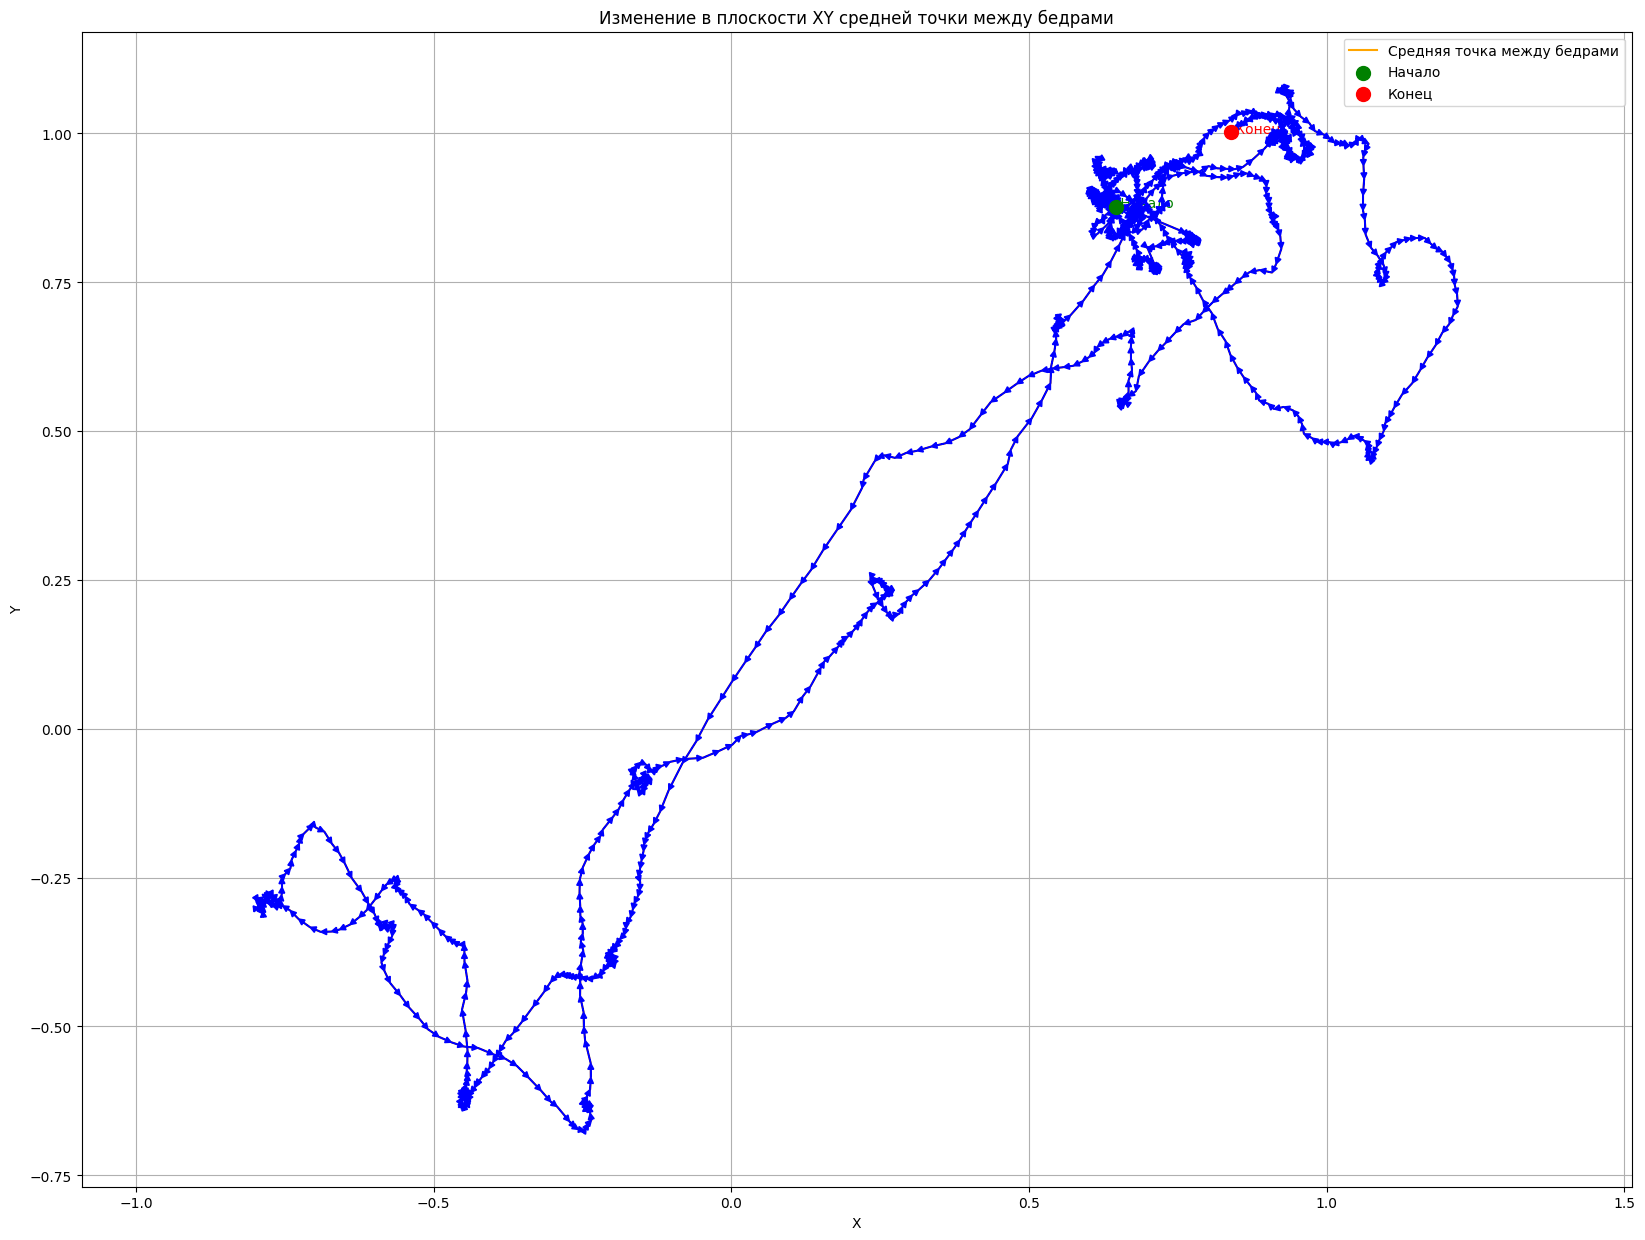

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров
mid_point_x = (frames_3d[:, 23, 0] + frames_3d[:, 24, 0]) / 2
mid_point_y = (frames_3d[:, 23, 1] + frames_3d[:, 24, 1]) / 2

# Фильтрация NaN значений
valid_indices = ~np.isnan(mid_point_x) & ~np.isnan(mid_point_y)
mid_point_x = mid_point_x[valid_indices]
mid_point_y = mid_point_y[valid_indices]

if len(mid_point_x) == 0 or len(mid_point_y) == 0:
    print("Нет валидных данных для построения графика. Проверьте входные данные.")
else:
    # Построение графика
    plt.figure(figsize=(20, 15))
    plt.plot(mid_point_x, mid_point_y, label="Средняя точка между бедрами", color="orange")

    # Добавление точки начала
    plt.scatter(mid_point_x[0], mid_point_y[0], color="green", s=100, label="Начало", zorder=5)
    plt.text(mid_point_x[0], mid_point_y[0], " Начало", color="green", fontsize=10)

    # Добавление точки конца
    plt.scatter(mid_point_x[-1], mid_point_y[-1], color="red", s=100, label="Конец", zorder=5)
    plt.text(mid_point_x[-1], mid_point_y[-1], " Конец", color="red", fontsize=10)

    # Добавление стрелок для указания направления движения
    for i in range(len(mid_point_x) - 1):
        # Координаты начальной и конечной точек стрелки
        x_start, y_start = mid_point_x[i], mid_point_y[i]
        x_end, y_end = mid_point_x[i + 1], mid_point_y[i + 1]

        # Рисуем стрелку
        plt.arrow(
            x_start, y_start,  # Начало стрелки
            x_end - x_start, y_end - y_start,  # Длина и направление стрелки
            head_width=0.01,  # Ширина головы стрелки
            head_length=0.01,  # Длина головы стрелки
            fc="blue",  # Цвет стрелки
            ec="blue",  # Цвет границы стрелки
            length_includes_head=True,  # Учитывать длину головы в общей длине
            zorder=3  # Уровень отображения стрелки
        )

    # Настройка графика
    plt.title("Изменение в плоскости XY средней точки между бедрами")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Сохранение пропорций осей
    plt.show()